In [ ]:
!nvidia-smi

Wed Jul 15 01:45:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch 
import torchvision
import numpy as np 
import random
import os
import glob
import copy
from tqdm import tqdm as tqdm
from torchsummary import summary

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)

best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# train class samples 
print('Normal Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/NORMAL | wc -l
print('Pneumonia Samples in Training Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/train/PNEUMONIA | wc -l

Normal Samples in Training Data
1342
Pneumonia Samples in Training Data
3876


In [ ]:
# Validation samples
print('Normal Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/NORMAL | wc -l
print('Pneumonia Samples in Validation Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/val/PNEUMONIA | wc -l

Normal Samples in Validation Data
9
Pneumonia Samples in Validation Data
9


In [ ]:
# Testing samples
print('Normal Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/NORMAL | wc -l
print('Pneumonia Samples in Testing Data')
!ls -l /content/drive/"My Drive"/NDP_Data/chest_xray/test/PNEUMONIA | wc -l

Normal Samples in Testing Data
235
Pneumonia Samples in Testing Data
391


In [ ]:
# Copying to Non DP data(train, val and test) to local to process/run faster during training & inference

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/train ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/val ./

!cp -R /content/drive/"My Drive"/NDP_Data/chest_xray/test ./

In [ ]:
!ls -lrt

total 20
drwxr-xr-x 1 root root 4096 Jul 10 16:29 sample_data
drwx------ 4 root root 4096 Jul 15 01:45 drive
drwx------ 4 root root 4096 Jul 15 01:57 train
drwx------ 4 root root 4096 Jul 15 02:26 val
drwx------ 4 root root 4096 Jul 15 02:27 test


In [ ]:
!ls -l ./train/NORMAL | wc -l

!ls -l ./train/PNEUMONIA | wc -l

1342
3876


In [ ]:
!ls -l ./val/NORMAL | wc -l

!ls -l ./val/PNEUMONIA | wc -l

9
9


In [ ]:
!ls -l ./test/NORMAL | wc -l

!ls -l ./test/PNEUMONIA | wc -l

235
391


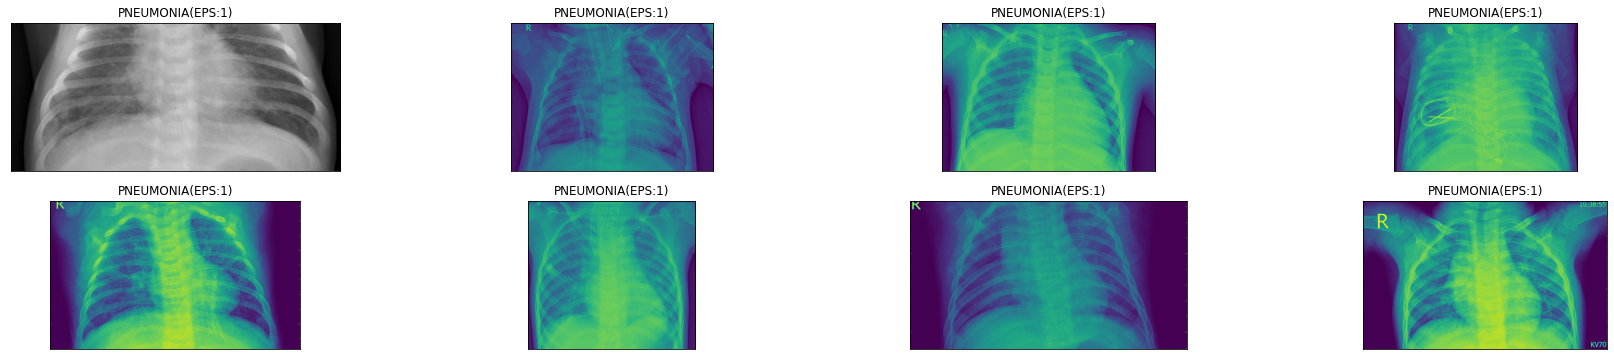

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 PNEUMONIA images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/PNEUMONIA")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/PNEUMONIA/" + img)
    plt.imshow(im)
    ax.set_title('PNEUMONIA(EPS:1)')

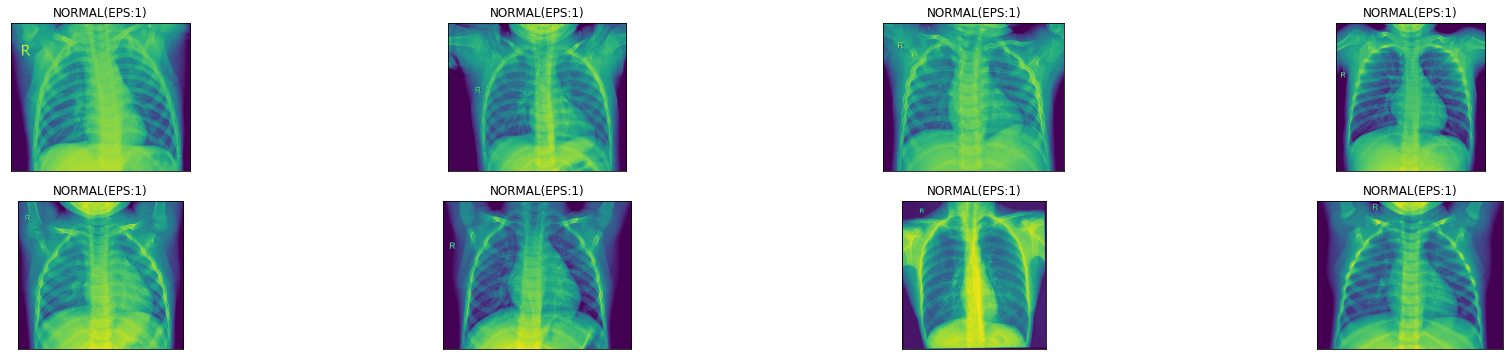

In [ ]:
fig = plt.figure(figsize=(30, 6))
base_dir = './train'
# display 8 NORMAL images(train) for Epsilon :1
train_imgs = os.listdir(base_dir+"/NORMAL")
for idx, img in enumerate(np.random.choice(train_imgs, 8)):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/NORMAL/" + img)
    plt.imshow(im)
    ax.set_title('NORMAL(EPS:1)')

In [ ]:
class ChestXRay(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        sample, target = super().__getitem__(index)
        path, _ = self.samples[index]
        
        target = 0
        if 'PNEUMONIA' in path:
            target = 1
        
        return sample, target
       

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ChestXRay('./train/', transform=train_transforms)
val_dataset = ChestXRay('./val/', transform=train_transforms)
test_dataset = ChestXRay('./test/', transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [ ]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 32
    S = 1
    z = 5.002 # n=5218, batch_size=128, noise_multiplier=5.002, epochs=50, delta=1e-4. This gives DP-SGD with sampling rate = 2.45% and noise_multiplier = 5.002 iterated over 2039 steps satisfies differential privacy with eps = 0.994 and delta = 0.0001.
              # The optimal RDP order is 20.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [ ]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [22]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0
train batch [0/41]: loss 0.5737420320510864

1it [00:12, 12.20s/it]

train batch [1/41]: loss 0.5014692544937134

2it [00:24, 12.17s/it]

train batch [2/41]: loss 0.5401807427406311

3it [00:36, 12.25s/it]

train batch [3/41]: loss 0.5516189336776733

4it [00:49, 12.44s/it]

train batch [4/41]: loss 0.5014297962188721

5it [01:02, 12.52s/it]

train batch [5/41]: loss 0.49040472507476807

6it [01:15, 12.60s/it]

train batch [6/41]: loss 0.5131015181541443

7it [01:28, 12.75s/it]

train batch [7/41]: loss 0.4678869843482971

8it [01:41, 12.94s/it]

train batch [8/41]: loss 0.4929462671279907

9it [01:55, 13.13s/it]

train batch [9/41]: loss 0.484796941280365

10it [02:08, 13.31s/it]

train batch [10/41]: loss 0.4483490586280823

11it [02:22, 13.44s/it]

train batch [11/41]: loss 0.45214471220970154

12it [02:36, 13.46s/it]

train batch [12/41]: loss 0.513823390007019

13it [02:49, 13.45s/it]

train batch [13/41]: loss 0.4745226502418518

14it [03:03, 13.44s/it]

train batch [14/41]: loss 0.4642364978790283

15it [03:16, 13.45s/it]

train batch [15/41]: loss 0.4912573993206024

16it [03:30, 13.53s/it]

train batch [16/41]: loss 0.44708144664764404

17it [03:43, 13.53s/it]

train batch [17/41]: loss 0.5328798890113831

18it [03:57, 13.57s/it]

train batch [18/41]: loss 0.4378868043422699

19it [04:10, 13.50s/it]

train batch [19/41]: loss 0.44830453395843506

20it [04:24, 13.55s/it]

train batch [20/41]: loss 0.42749762535095215

21it [04:38, 13.58s/it]

train batch [21/41]: loss 0.41042953729629517

22it [04:51, 13.55s/it]

train batch [22/41]: loss 0.460964560508728

23it [05:05, 13.54s/it]

train batch [23/41]: loss 0.43431293964385986

24it [05:18, 13.55s/it]

train batch [24/41]: loss 0.4554647207260132

25it [05:32, 13.56s/it]

train batch [25/41]: loss 0.5006052255630493

26it [05:45, 13.56s/it]

train batch [26/41]: loss 0.3887619972229004

27it [05:59, 13.53s/it]

train batch [27/41]: loss 0.48925185203552246

28it [06:12, 13.56s/it]

train batch [28/41]: loss 0.40726709365844727

29it [06:26, 13.50s/it]

train batch [29/41]: loss 0.44571685791015625

30it [06:39, 13.48s/it]

train batch [30/41]: loss 0.4128358066082001

31it [06:53, 13.51s/it]

train batch [31/41]: loss 0.43659675121307373

32it [07:06, 13.54s/it]

train batch [32/41]: loss 0.47096389532089233

33it [07:20, 13.56s/it]

train batch [33/41]: loss 0.42241135239601135

34it [07:33, 13.53s/it]

train batch [34/41]: loss 0.4322736859321594

35it [07:47, 13.52s/it]

train batch [35/41]: loss 0.3865969479084015

36it [08:00, 13.47s/it]

train batch [36/41]: loss 0.42817866802215576

37it [08:14, 13.53s/it]

train batch [37/41]: loss 0.39218705892562866

38it [08:27, 13.52s/it]

train batch [38/41]: loss 0.4578069746494293

39it [08:41, 13.53s/it]

train batch [39/41]: loss 0.45287156105041504

40it [08:54, 13.52s/it]

train batch [40/41]: loss 0.5318423509597778

41it [09:05, 13.30s/it]

val batch [1/4]: loss 1.9741101264953613

test batch [4/5]: loss 0.1406143605709076

0it [00:00, ?it/s]


Train loss: 0.4651927053928375, Train accuracy: 0.7737730145454407
Val loss: 1.1861552745103836, Val accuracy: 0.5
Test loss: 0.8406657636165619, Test accuracy: 0.625

=============== Epoch: 1
train batch [0/41]: loss 0.4366472661495209

1it [00:13, 13.58s/it]

train batch [1/41]: loss 0.3679060935974121

2it [00:27, 13.62s/it]

train batch [2/41]: loss 0.43259957432746887

3it [00:41, 13.65s/it]

train batch [3/41]: loss 0.48207157850265503

4it [00:54, 13.64s/it]

train batch [4/41]: loss 0.46229496598243713

5it [01:08, 13.60s/it]

train batch [5/41]: loss 0.4413689374923706

6it [01:21, 13.57s/it]

train batch [6/41]: loss 0.5171980857849121

7it [01:35, 13.60s/it]

train batch [7/41]: loss 0.390572726726532

8it [01:48, 13.57s/it]

train batch [8/41]: loss 0.43182623386383057

9it [02:02, 13.57s/it]

train batch [9/41]: loss 0.44187262654304504

10it [02:15, 13.56s/it]

train batch [10/41]: loss 0.3714919090270996

11it [02:29, 13.45s/it]

train batch [11/41]: loss 0.4276249408721924

12it [02:42, 13.45s/it]

train batch [12/41]: loss 0.3854844868183136

13it [02:55, 13.44s/it]

train batch [13/41]: loss 0.510166585445404

14it [03:09, 13.54s/it]

train batch [14/41]: loss 0.5312260389328003

15it [03:23, 13.66s/it]

train batch [15/41]: loss 0.4398786425590515

16it [03:37, 13.63s/it]

train batch [16/41]: loss 0.45892947912216187

17it [03:50, 13.66s/it]

train batch [17/41]: loss 0.41308367252349854

18it [04:04, 13.55s/it]

train batch [18/41]: loss 0.4039057493209839

19it [04:17, 13.50s/it]

train batch [19/41]: loss 0.4102729856967926

20it [04:31, 13.51s/it]

train batch [20/41]: loss 0.41383928060531616

21it [04:44, 13.49s/it]

train batch [21/41]: loss 0.4410606622695923

22it [04:57, 13.44s/it]

train batch [22/41]: loss 0.3672597408294678

23it [05:11, 13.38s/it]

train batch [23/41]: loss 0.4017651677131653

24it [05:24, 13.37s/it]

train batch [24/41]: loss 0.4440074861049652

25it [05:37, 13.38s/it]

train batch [25/41]: loss 0.4385969042778015

26it [05:51, 13.46s/it]

train batch [26/41]: loss 0.38853564858436584

27it [06:05, 13.46s/it]

train batch [27/41]: loss 0.35149329900741577

28it [06:18, 13.43s/it]

train batch [28/41]: loss 0.45229214429855347

29it [06:31, 13.47s/it]

train batch [29/41]: loss 0.4100065529346466

30it [06:45, 13.47s/it]

train batch [30/41]: loss 0.41023749113082886

31it [06:59, 13.51s/it]

train batch [31/41]: loss 0.4481789469718933

32it [07:12, 13.52s/it]

train batch [32/41]: loss 0.43009626865386963

33it [07:26, 13.50s/it]

train batch [33/41]: loss 0.5018076300621033

34it [07:39, 13.53s/it]

train batch [34/41]: loss 0.41948217153549194

35it [07:53, 13.54s/it]

train batch [35/41]: loss 0.4732862412929535

36it [08:06, 13.61s/it]

train batch [36/41]: loss 0.4042294919490814

37it [08:20, 13.55s/it]

train batch [37/41]: loss 0.3659336566925049

38it [08:33, 13.49s/it]

train batch [38/41]: loss 0.4423474669456482

39it [08:47, 13.51s/it]

train batch [39/41]: loss 0.3691079020500183

40it [09:00, 13.46s/it]

train batch [40/41]: loss 0.44968217611312866

41it [09:10, 13.44s/it]

val batch [1/4]: loss 1.576881766319275

test batch [4/5]: loss 0.1815369576215744

0it [00:00, ?it/s]


Train loss: 0.4287724196910858, Train accuracy: 0.7659125328063965
Val loss: 0.8477512337267399, Val accuracy: 0.5
Test loss: 0.5587396174669266, Test accuracy: 0.6490384936332703

=============== Epoch: 2
train batch [0/41]: loss 0.3826557993888855

1it [00:13, 13.54s/it]

train batch [1/41]: loss 0.3667244017124176

2it [00:27, 13.61s/it]

train batch [2/41]: loss 0.4164692163467407

3it [00:40, 13.62s/it]

train batch [3/41]: loss 0.4343813359737396

4it [00:54, 13.57s/it]

train batch [4/41]: loss 0.4471357762813568

5it [01:07, 13.52s/it]

train batch [5/41]: loss 0.46394070982933044

6it [01:21, 13.48s/it]

train batch [6/41]: loss 0.41434890031814575

7it [01:34, 13.55s/it]

train batch [7/41]: loss 0.4602643847465515

8it [01:48, 13.61s/it]

train batch [8/41]: loss 0.4212343096733093

9it [02:02, 13.58s/it]

train batch [9/41]: loss 0.4008339047431946

10it [02:15, 13.56s/it]

train batch [10/41]: loss 0.3623029589653015

11it [02:29, 13.54s/it]

train batch [11/41]: loss 0.432774156332016

12it [02:42, 13.54s/it]

train batch [12/41]: loss 0.42016440629959106

13it [02:56, 13.53s/it]

train batch [13/41]: loss 0.4068828821182251

14it [03:09, 13.59s/it]

train batch [14/41]: loss 0.3995940089225769

15it [03:23, 13.57s/it]

train batch [15/41]: loss 0.35879844427108765

16it [03:37, 13.59s/it]

train batch [16/41]: loss 0.43814605474472046

17it [03:50, 13.61s/it]

train batch [17/41]: loss 0.365123450756073

18it [04:04, 13.61s/it]

train batch [18/41]: loss 0.36391761898994446

19it [04:17, 13.56s/it]

train batch [19/41]: loss 0.4272095263004303

20it [04:31, 13.56s/it]

train batch [20/41]: loss 0.36679959297180176

21it [04:44, 13.54s/it]

train batch [21/41]: loss 0.3961886763572693

22it [04:58, 13.54s/it]

train batch [22/41]: loss 0.3916248083114624

23it [05:12, 13.58s/it]

train batch [23/41]: loss 0.43585777282714844

24it [05:25, 13.56s/it]

train batch [24/41]: loss 0.33946749567985535

25it [05:38, 13.49s/it]

train batch [25/41]: loss 0.3491290211677551

26it [05:52, 13.48s/it]

train batch [26/41]: loss 0.505403995513916

27it [06:06, 13.52s/it]

train batch [27/41]: loss 0.3668689429759979

28it [06:19, 13.54s/it]

train batch [28/41]: loss 0.4310178756713867

29it [06:33, 13.54s/it]

train batch [29/41]: loss 0.4248045086860657

30it [06:46, 13.54s/it]

train batch [30/41]: loss 0.387420654296875

31it [07:00, 13.53s/it]

train batch [31/41]: loss 0.41661179065704346

32it [07:13, 13.56s/it]

train batch [32/41]: loss 0.45680031180381775

33it [07:27, 13.59s/it]

train batch [33/41]: loss 0.4063170552253723

34it [07:41, 13.58s/it]

train batch [34/41]: loss 0.3787194490432739

35it [07:54, 13.54s/it]

train batch [35/41]: loss 0.3484150171279907

36it [08:07, 13.52s/it]

train batch [36/41]: loss 0.3550068140029907

37it [08:21, 13.51s/it]

train batch [37/41]: loss 0.3652390241622925

38it [08:34, 13.51s/it]

train batch [38/41]: loss 0.3861091732978821

39it [08:48, 13.55s/it]

train batch [39/41]: loss 0.33678120374679565

40it [09:02, 13.55s/it]

train batch [40/41]: loss 0.4134596288204193

41it [09:12, 13.47s/it]

val batch [1/4]: loss 1.7197766304016113

test batch [4/5]: loss 0.1457301825284958

0it [00:00, ?it/s]


Train loss: 0.40099865852332695, Train accuracy: 0.7699386477470398
Val loss: 0.8741803057491779, Val accuracy: 0.5
Test loss: 0.5972251057624817, Test accuracy: 0.629807710647583

=============== Epoch: 3
train batch [0/41]: loss 0.35439780354499817

1it [00:13, 13.48s/it]

train batch [1/41]: loss 0.4294309616088867

2it [00:27, 13.65s/it]

train batch [2/41]: loss 0.3539794385433197

3it [00:41, 13.65s/it]

train batch [3/41]: loss 0.46602022647857666

4it [00:54, 13.68s/it]

train batch [4/41]: loss 0.4058888852596283

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.43016085028648376

6it [01:22, 13.65s/it]

train batch [6/41]: loss 0.3764270544052124

7it [01:35, 13.62s/it]

train batch [7/41]: loss 0.4591934084892273

8it [01:49, 13.74s/it]

train batch [8/41]: loss 0.34305283427238464

9it [02:03, 13.70s/it]

train batch [9/41]: loss 0.3366251289844513

10it [02:16, 13.61s/it]

train batch [10/41]: loss 0.4517790675163269

11it [02:30, 13.66s/it]

train batch [11/41]: loss 0.3964579701423645

12it [02:44, 13.67s/it]

train batch [12/41]: loss 0.39841437339782715

13it [02:57, 13.65s/it]

train batch [13/41]: loss 0.35287609696388245

14it [03:11, 13.63s/it]

train batch [14/41]: loss 0.31101518869400024

15it [03:24, 13.59s/it]

train batch [15/41]: loss 0.42299890518188477

16it [03:38, 13.61s/it]

train batch [16/41]: loss 0.3992767930030823

17it [03:51, 13.56s/it]

train batch [17/41]: loss 0.40255415439605713

18it [04:05, 13.55s/it]

train batch [18/41]: loss 0.409410297870636

19it [04:19, 13.57s/it]

train batch [19/41]: loss 0.3815564513206482

20it [04:32, 13.56s/it]

train batch [20/41]: loss 0.36164921522140503

21it [04:46, 13.54s/it]

train batch [21/41]: loss 0.4210936427116394

22it [04:59, 13.60s/it]

train batch [22/41]: loss 0.3943686783313751

23it [05:13, 13.60s/it]

train batch [23/41]: loss 0.44942817091941833

24it [05:27, 13.63s/it]

train batch [24/41]: loss 0.38237014412879944

25it [05:40, 13.60s/it]

train batch [25/41]: loss 0.40031611919403076

26it [05:54, 13.61s/it]

train batch [26/41]: loss 0.38215869665145874

27it [06:07, 13.57s/it]

train batch [27/41]: loss 0.3957700729370117

28it [06:21, 13.56s/it]

train batch [28/41]: loss 0.4577797055244446

29it [06:35, 13.59s/it]

train batch [29/41]: loss 0.45401546359062195

30it [06:48, 13.68s/it]

train batch [30/41]: loss 0.44938209652900696

31it [07:02, 13.70s/it]

train batch [31/41]: loss 0.3807600736618042

32it [07:16, 13.64s/it]

train batch [32/41]: loss 0.40251943469047546

33it [07:29, 13.63s/it]

train batch [33/41]: loss 0.44082483649253845

34it [07:43, 13.68s/it]

train batch [34/41]: loss 0.40253502130508423

35it [07:57, 13.68s/it]

train batch [35/41]: loss 0.3592264652252197

36it [08:10, 13.60s/it]

train batch [36/41]: loss 0.3579409718513489

37it [08:24, 13.57s/it]

train batch [37/41]: loss 0.36343544721603394

38it [08:37, 13.53s/it]

train batch [38/41]: loss 0.4135212302207947

39it [08:51, 13.58s/it]

train batch [39/41]: loss 0.3720141649246216

40it [09:04, 13.59s/it]

train batch [40/41]: loss 0.4093708395957947

41it [09:15, 13.54s/it]

val batch [0/4]: loss 0.9121872186660767

test batch [4/5]: loss 0.2705792188644409

0it [00:00, ?it/s]


Train loss: 0.3983413693381519, Train accuracy: 0.7768404483795166
Val loss: 0.566655345261097, Val accuracy: 0.5
Test loss: 0.5266192197799683, Test accuracy: 0.6907051205635071

=============== Epoch: 4
train batch [0/41]: loss 0.40046393871307373

1it [00:13, 13.46s/it]

train batch [1/41]: loss 0.39882129430770874

2it [00:27, 13.67s/it]

train batch [2/41]: loss 0.38564640283584595

3it [00:41, 13.71s/it]

train batch [3/41]: loss 0.3320019841194153

4it [00:54, 13.63s/it]

train batch [4/41]: loss 0.3578237295150757

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.3646116256713867

6it [01:21, 13.56s/it]

train batch [6/41]: loss 0.3687930405139923

7it [01:35, 13.56s/it]

train batch [7/41]: loss 0.3099367916584015

8it [01:49, 13.60s/it]

train batch [8/41]: loss 0.3382623493671417

9it [02:02, 13.61s/it]

train batch [9/41]: loss 0.41542676091194153

10it [02:16, 13.65s/it]

train batch [10/41]: loss 0.35238534212112427

11it [02:30, 13.63s/it]

train batch [11/41]: loss 0.39075350761413574

12it [02:43, 13.64s/it]

train batch [12/41]: loss 0.4185943901538849

13it [02:57, 13.64s/it]

train batch [13/41]: loss 0.399682879447937

14it [03:10, 13.62s/it]

train batch [14/41]: loss 0.36901766061782837

15it [03:24, 13.61s/it]

train batch [15/41]: loss 0.3924357295036316

16it [03:37, 13.55s/it]

train batch [16/41]: loss 0.3895614445209503

17it [03:51, 13.58s/it]

train batch [17/41]: loss 0.453519344329834

18it [04:05, 13.58s/it]

train batch [18/41]: loss 0.3237870931625366

19it [04:18, 13.56s/it]

train batch [19/41]: loss 0.37920942902565

20it [04:32, 13.54s/it]

train batch [20/41]: loss 0.4294765591621399

21it [04:45, 13.55s/it]

train batch [21/41]: loss 0.33193087577819824

22it [04:59, 13.50s/it]

train batch [22/41]: loss 0.4283517003059387

23it [05:12, 13.57s/it]

train batch [23/41]: loss 0.35312169790267944

24it [05:26, 13.51s/it]

train batch [24/41]: loss 0.48181408643722534

25it [05:40, 13.60s/it]

train batch [25/41]: loss 0.5167039036750793

26it [05:53, 13.66s/it]

train batch [26/41]: loss 0.31554460525512695

27it [06:07, 13.58s/it]

train batch [27/41]: loss 0.49308982491493225

28it [06:20, 13.61s/it]

train batch [28/41]: loss 0.4976482093334198

29it [06:34, 13.66s/it]

train batch [29/41]: loss 0.43487662076950073

30it [06:48, 13.64s/it]

train batch [30/41]: loss 0.5030878782272339

31it [07:01, 13.64s/it]

train batch [31/41]: loss 0.5413593649864197

32it [07:15, 13.67s/it]

train batch [32/41]: loss 0.3922486901283264

33it [07:29, 13.61s/it]

train batch [33/41]: loss 0.3999744653701782

34it [07:42, 13.58s/it]

train batch [34/41]: loss 0.38155755400657654

35it [07:56, 13.59s/it]

train batch [35/41]: loss 0.4965026378631592

36it [08:09, 13.62s/it]

train batch [36/41]: loss 0.43206101655960083

37it [08:23, 13.59s/it]

train batch [37/41]: loss 0.419156014919281

38it [08:37, 13.63s/it]

train batch [38/41]: loss 0.41743698716163635

39it [08:50, 13.63s/it]

train batch [39/41]: loss 0.41970494389533997

40it [09:04, 13.69s/it]

train batch [40/41]: loss 0.564048707485199

41it [09:15, 13.54s/it]

val batch [1/4]: loss 1.4574640989303589

test batch [4/5]: loss 0.1451445370912552

0it [00:00, ?it/s]


Train loss: 0.40952270423493736, Train accuracy: 0.7684049010276794
Val loss: 0.8339171856641769, Val accuracy: 0.5
Test loss: 0.5686309665441514, Test accuracy: 0.6458333134651184

=============== Epoch: 5
train batch [0/41]: loss 0.39972367882728577

1it [00:13, 13.58s/it]

train batch [1/41]: loss 0.3863612115383148

2it [00:27, 13.71s/it]

train batch [2/41]: loss 0.44460737705230713

3it [00:41, 13.78s/it]

train batch [3/41]: loss 0.40221932530403137

4it [00:55, 13.73s/it]

train batch [4/41]: loss 0.3871003985404968

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.3992878794670105

6it [01:22, 13.58s/it]

train batch [6/41]: loss 0.2812645435333252

7it [01:35, 13.45s/it]

train batch [7/41]: loss 0.3875367045402527

8it [01:48, 13.56s/it]

train batch [8/41]: loss 0.4455552101135254

9it [02:02, 13.66s/it]

train batch [9/41]: loss 0.4273332357406616

10it [02:16, 13.69s/it]

train batch [10/41]: loss 0.4698852002620697

11it [02:30, 13.67s/it]

train batch [11/41]: loss 0.30365702509880066

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.3747446537017822

13it [02:57, 13.53s/it]

train batch [13/41]: loss 0.41622593998908997

14it [03:10, 13.59s/it]

train batch [14/41]: loss 0.439850777387619

15it [03:24, 13.60s/it]

train batch [15/41]: loss 0.4672320485115051

16it [03:38, 13.61s/it]

train batch [16/41]: loss 0.5358000993728638

17it [03:51, 13.66s/it]

train batch [17/41]: loss 0.35211825370788574

18it [04:05, 13.62s/it]

train batch [18/41]: loss 0.40695157647132874

19it [04:19, 13.66s/it]

train batch [19/41]: loss 0.334296315908432

20it [04:32, 13.56s/it]

train batch [20/41]: loss 0.3571639657020569

21it [04:45, 13.57s/it]

train batch [21/41]: loss 0.38259732723236084

22it [04:59, 13.57s/it]

train batch [22/41]: loss 0.33854153752326965

23it [05:13, 13.55s/it]

train batch [23/41]: loss 0.34313395619392395

24it [05:26, 13.53s/it]

train batch [24/41]: loss 0.390377938747406

25it [05:39, 13.48s/it]

train batch [25/41]: loss 0.5147403478622437

26it [05:53, 13.53s/it]

train batch [26/41]: loss 0.3501055836677551

27it [06:07, 13.56s/it]

train batch [27/41]: loss 0.35573121905326843

28it [06:20, 13.53s/it]

train batch [28/41]: loss 0.4160139560699463

29it [06:34, 13.58s/it]

train batch [29/41]: loss 0.3897269666194916

30it [06:47, 13.53s/it]

train batch [30/41]: loss 0.4270305037498474

31it [07:01, 13.57s/it]

train batch [31/41]: loss 0.4707191586494446

32it [07:15, 13.59s/it]

train batch [32/41]: loss 0.541374683380127

33it [07:28, 13.62s/it]

train batch [33/41]: loss 0.43118077516555786

34it [07:42, 13.62s/it]

train batch [34/41]: loss 0.35070517659187317

35it [07:55, 13.56s/it]

train batch [35/41]: loss 0.31762975454330444

36it [08:09, 13.53s/it]

train batch [36/41]: loss 0.3736013174057007

37it [08:22, 13.52s/it]

train batch [37/41]: loss 0.3738322854042053

38it [08:36, 13.54s/it]

train batch [38/41]: loss 0.46507662534713745

39it [08:49, 13.54s/it]

train batch [39/41]: loss 0.3102972209453583

40it [09:03, 13.48s/it]

train batch [40/41]: loss 0.3581937551498413

41it [09:13, 13.50s/it]

val batch [1/4]: loss 1.489343285560608

test batch [4/5]: loss 0.10920919477939606

0it [00:00, ?it/s]


Train loss: 0.3980372090165208, Train accuracy: 0.7603527307510376
Val loss: 0.9201337695121765, Val accuracy: 0.5
Test loss: 0.5950889945030212, Test accuracy: 0.6410256624221802

=============== Epoch: 6
train batch [0/41]: loss 0.40214455127716064

1it [00:13, 13.53s/it]

train batch [1/41]: loss 0.4064944088459015

2it [00:27, 13.68s/it]

train batch [2/41]: loss 0.4047973155975342

3it [00:41, 13.74s/it]

train batch [3/41]: loss 0.33188629150390625

4it [00:55, 13.70s/it]

train batch [4/41]: loss 0.37060004472732544

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.426116943359375

6it [01:22, 13.59s/it]

train batch [6/41]: loss 0.2818133533000946

7it [01:35, 13.49s/it]

train batch [7/41]: loss 0.2932789921760559

8it [01:48, 13.48s/it]

train batch [8/41]: loss 0.4493721127510071

9it [02:02, 13.52s/it]

train batch [9/41]: loss 0.32344168424606323

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.39640045166015625

11it [02:29, 13.54s/it]

train batch [11/41]: loss 0.32833173871040344

12it [02:42, 13.48s/it]

train batch [12/41]: loss 0.33434635400772095

13it [02:56, 13.45s/it]

train batch [13/41]: loss 0.36467933654785156

14it [03:09, 13.50s/it]

train batch [14/41]: loss 0.36507874727249146

15it [03:23, 13.48s/it]

train batch [15/41]: loss 0.3536173105239868

16it [03:36, 13.52s/it]

train batch [16/41]: loss 0.40401870012283325

17it [03:50, 13.54s/it]

train batch [17/41]: loss 0.3713335394859314

18it [04:03, 13.49s/it]

train batch [18/41]: loss 0.3352607786655426

19it [04:17, 13.50s/it]

train batch [19/41]: loss 0.40820515155792236

20it [04:30, 13.55s/it]

train batch [20/41]: loss 0.4102092981338501

21it [04:44, 13.56s/it]

train batch [21/41]: loss 0.3906251788139343

22it [04:58, 13.58s/it]

train batch [22/41]: loss 0.34025079011917114

23it [05:11, 13.59s/it]

train batch [23/41]: loss 0.3674990236759186

24it [05:25, 13.54s/it]

train batch [24/41]: loss 0.3738161325454712

25it [05:38, 13.48s/it]

train batch [25/41]: loss 0.3727254867553711

26it [05:52, 13.50s/it]

train batch [26/41]: loss 0.36099106073379517

27it [06:05, 13.52s/it]

train batch [27/41]: loss 0.2965657114982605

28it [06:19, 13.50s/it]

train batch [28/41]: loss 0.2995606064796448

29it [06:32, 13.48s/it]

train batch [29/41]: loss 0.3556782603263855

30it [06:45, 13.47s/it]

train batch [30/41]: loss 0.38910675048828125

31it [06:59, 13.47s/it]

train batch [31/41]: loss 0.3439001441001892

32it [07:12, 13.48s/it]

train batch [32/41]: loss 0.33970141410827637

33it [07:26, 13.47s/it]

train batch [33/41]: loss 0.35410961508750916

34it [07:39, 13.47s/it]

train batch [34/41]: loss 0.4408504366874695

35it [07:53, 13.56s/it]

train batch [35/41]: loss 0.3772079348564148

36it [08:07, 13.56s/it]

train batch [36/41]: loss 0.3849964737892151

37it [08:20, 13.56s/it]

train batch [37/41]: loss 0.30333849787712097

38it [08:34, 13.50s/it]

train batch [38/41]: loss 0.33228957653045654

39it [08:47, 13.45s/it]

train batch [39/41]: loss 0.2991136312484741

40it [09:00, 13.47s/it]

train batch [40/41]: loss 0.4517100751399994

41it [09:11, 13.45s/it]

val batch [1/4]: loss 1.2023193836212158

test batch [4/5]: loss 0.17041271924972534

0it [00:00, ?it/s]


Train loss: 0.3642796059934104, Train accuracy: 0.7933282256126404
Val loss: 0.8039451763033867, Val accuracy: 0.5625
Test loss: 0.49593058228492737, Test accuracy: 0.7067307829856873

=============== Epoch: 7
train batch [0/41]: loss 0.3658957779407501

1it [00:13, 13.29s/it]

train batch [1/41]: loss 0.28058549761772156

2it [00:26, 13.40s/it]

train batch [2/41]: loss 0.3906274437904358

3it [00:40, 13.53s/it]

train batch [3/41]: loss 0.3805866837501526

4it [00:54, 13.54s/it]

train batch [4/41]: loss 0.45022088289260864

5it [01:07, 13.55s/it]

train batch [5/41]: loss 0.3204815983772278

6it [01:21, 13.53s/it]

train batch [6/41]: loss 0.29435408115386963

7it [01:34, 13.50s/it]

train batch [7/41]: loss 0.35849055647850037

8it [01:48, 13.53s/it]

train batch [8/41]: loss 0.36668333411216736

9it [02:01, 13.51s/it]

train batch [9/41]: loss 0.4246957302093506

10it [02:15, 13.55s/it]

train batch [10/41]: loss 0.3370978832244873

11it [02:28, 13.51s/it]

train batch [11/41]: loss 0.3878577947616577

12it [02:42, 13.56s/it]

train batch [12/41]: loss 0.4607221484184265

13it [02:56, 13.60s/it]

train batch [13/41]: loss 0.31582123041152954

14it [03:09, 13.58s/it]

train batch [14/41]: loss 0.4162587523460388

15it [03:23, 13.63s/it]

train batch [15/41]: loss 0.3758029639720917

16it [03:37, 13.62s/it]

train batch [16/41]: loss 0.37923136353492737

17it [03:50, 13.63s/it]

train batch [17/41]: loss 0.4028036296367645

18it [04:04, 13.65s/it]

train batch [18/41]: loss 0.3636816740036011

19it [04:18, 13.65s/it]

train batch [19/41]: loss 0.33157864212989807

20it [04:31, 13.62s/it]

train batch [20/41]: loss 0.3176019787788391

21it [04:45, 13.61s/it]

train batch [21/41]: loss 0.42208969593048096

22it [04:59, 13.64s/it]

train batch [22/41]: loss 0.4351995587348938

23it [05:12, 13.67s/it]

train batch [23/41]: loss 0.3526451885700226

24it [05:26, 13.65s/it]

train batch [24/41]: loss 0.36628419160842896

25it [05:40, 13.66s/it]

train batch [25/41]: loss 0.3111504912376404

26it [05:53, 13.64s/it]

train batch [26/41]: loss 0.32625770568847656

27it [06:07, 13.60s/it]

train batch [27/41]: loss 0.3293443024158478

28it [06:20, 13.55s/it]

train batch [28/41]: loss 0.36191248893737793

29it [06:34, 13.53s/it]

train batch [29/41]: loss 0.39588338136672974

30it [06:47, 13.63s/it]

train batch [30/41]: loss 0.3270750343799591

31it [07:01, 13.60s/it]

train batch [31/41]: loss 0.3668922185897827

32it [07:15, 13.58s/it]

train batch [32/41]: loss 0.3699040412902832

33it [07:28, 13.57s/it]

train batch [33/41]: loss 0.32318294048309326

34it [07:42, 13.59s/it]

train batch [34/41]: loss 0.2909848392009735

35it [07:55, 13.54s/it]

train batch [35/41]: loss 0.3175542652606964

36it [08:09, 13.55s/it]

train batch [36/41]: loss 0.3552919030189514

37it [08:22, 13.60s/it]

train batch [37/41]: loss 0.3181750774383545

38it [08:36, 13.58s/it]

train batch [38/41]: loss 0.3284637928009033

39it [08:50, 13.59s/it]

train batch [39/41]: loss 0.30737826228141785

40it [09:03, 13.58s/it]

train batch [40/41]: loss 0.3436632752418518

41it [09:13, 13.51s/it]

val batch [1/4]: loss 1.0753992795944214

test batch [4/5]: loss 0.22059670090675354

0it [00:00, ?it/s]


Train loss: 0.35781492910734036, Train accuracy: 0.8042561411857605
Val loss: 0.7281148433685303, Val accuracy: 0.5625
Test loss: 0.5285614192485809, Test accuracy: 0.6907051205635071

=============== Epoch: 8
train batch [0/41]: loss 0.3416456878185272

1it [00:13, 13.55s/it]

train batch [1/41]: loss 0.367140531539917

2it [00:27, 13.67s/it]

train batch [2/41]: loss 0.38937461376190186

3it [00:41, 13.79s/it]

train batch [3/41]: loss 0.29921239614486694

4it [00:55, 13.72s/it]

train batch [4/41]: loss 0.381465345621109

5it [01:08, 13.71s/it]

train batch [5/41]: loss 0.33036163449287415

6it [01:22, 13.64s/it]

train batch [6/41]: loss 0.3061775267124176

7it [01:35, 13.58s/it]

train batch [7/41]: loss 0.34512659907341003

8it [01:49, 13.63s/it]

train batch [8/41]: loss 0.316350519657135

9it [02:03, 13.63s/it]

train batch [9/41]: loss 0.31747081875801086

10it [02:16, 13.61s/it]

train batch [10/41]: loss 0.3374626040458679

11it [02:30, 13.63s/it]

train batch [11/41]: loss 0.4172484576702118

12it [02:44, 13.65s/it]

train batch [12/41]: loss 0.31455516815185547

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.3701432943344116

14it [03:11, 13.69s/it]

train batch [14/41]: loss 0.3218774199485779

15it [03:25, 13.74s/it]

train batch [15/41]: loss 0.36390531063079834

16it [03:39, 13.75s/it]

train batch [16/41]: loss 0.32150977849960327

17it [03:52, 13.76s/it]

train batch [17/41]: loss 0.39248788356781006

18it [04:06, 13.79s/it]

train batch [18/41]: loss 0.3476378321647644

19it [04:20, 13.73s/it]

train batch [19/41]: loss 0.32019034028053284

20it [04:33, 13.62s/it]

train batch [20/41]: loss 0.2958052158355713

21it [04:47, 13.60s/it]

train batch [21/41]: loss 0.31091195344924927

22it [05:00, 13.56s/it]

train batch [22/41]: loss 0.38114383816719055

23it [05:14, 13.57s/it]

train batch [23/41]: loss 0.39750975370407104

24it [05:27, 13.59s/it]

train batch [24/41]: loss 0.35760214924812317

25it [05:41, 13.56s/it]

train batch [25/41]: loss 0.34072691202163696

26it [05:54, 13.55s/it]

train batch [26/41]: loss 0.3633117079734802

27it [06:08, 13.56s/it]

train batch [27/41]: loss 0.3195229768753052

28it [06:22, 13.57s/it]

train batch [28/41]: loss 0.3395407199859619

29it [06:35, 13.61s/it]

train batch [29/41]: loss 0.3487655818462372

30it [06:49, 13.64s/it]

train batch [30/41]: loss 0.29793065786361694

31it [07:03, 13.67s/it]

train batch [31/41]: loss 0.31615108251571655

32it [07:16, 13.62s/it]

train batch [32/41]: loss 0.3476884961128235

33it [07:30, 13.62s/it]

train batch [33/41]: loss 0.38243022561073303

34it [07:44, 13.66s/it]

train batch [34/41]: loss 0.3177768588066101

35it [07:57, 13.69s/it]

train batch [35/41]: loss 0.3751419186592102

36it [08:11, 13.70s/it]

train batch [36/41]: loss 0.3803758919239044

37it [08:25, 13.68s/it]

train batch [37/41]: loss 0.3203243911266327

38it [08:38, 13.62s/it]

train batch [38/41]: loss 0.3846814036369324

39it [08:52, 13.65s/it]

train batch [39/41]: loss 0.33264195919036865

40it [09:06, 13.64s/it]

train batch [40/41]: loss 0.344122052192688

41it [09:16, 13.57s/it]

val batch [0/4]: loss 1.7483868598937988

test batch [4/5]: loss 0.15642333030700684

0it [00:00, ?it/s]


Train loss: 0.3452548639076512, Train accuracy: 0.8105828166007996
Val loss: 0.851301982998848, Val accuracy: 0.5
Test loss: 0.5383549988269806, Test accuracy: 0.6810897588729858

=============== Epoch: 9
train batch [0/41]: loss 0.2623804807662964

1it [00:13, 13.34s/it]

train batch [1/41]: loss 0.3468979001045227

2it [00:27, 13.53s/it]

train batch [2/41]: loss 0.3592256009578705

3it [00:41, 13.63s/it]

train batch [3/41]: loss 0.37873974442481995

4it [00:54, 13.64s/it]

train batch [4/41]: loss 0.35966506600379944

5it [01:08, 13.59s/it]

train batch [5/41]: loss 0.32623225450515747

6it [01:21, 13.56s/it]

train batch [6/41]: loss 0.34942618012428284

7it [01:35, 13.55s/it]

train batch [7/41]: loss 0.3178150951862335

8it [01:49, 13.63s/it]

train batch [8/41]: loss 0.3915214538574219

9it [02:02, 13.69s/it]

train batch [9/41]: loss 0.3293922543525696

10it [02:16, 13.66s/it]

train batch [10/41]: loss 0.3339858651161194

11it [02:29, 13.57s/it]

train batch [11/41]: loss 0.3743754029273987

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.3574536442756653

13it [02:57, 13.61s/it]

train batch [13/41]: loss 0.30811822414398193

14it [03:10, 13.59s/it]

train batch [14/41]: loss 0.3970947861671448

15it [03:24, 13.65s/it]

train batch [15/41]: loss 0.392780065536499

16it [03:38, 13.66s/it]

train batch [16/41]: loss 0.3574100434780121

17it [03:52, 13.69s/it]

train batch [17/41]: loss 0.3273870646953583

18it [04:05, 13.64s/it]

train batch [18/41]: loss 0.3638553023338318

19it [04:19, 13.64s/it]

train batch [19/41]: loss 0.2846033573150635

20it [04:32, 13.63s/it]

train batch [20/41]: loss 0.3379846215248108

21it [04:46, 13.64s/it]

train batch [21/41]: loss 0.3025968670845032

22it [05:00, 13.67s/it]

train batch [22/41]: loss 0.42419111728668213

23it [05:13, 13.65s/it]

train batch [23/41]: loss 0.31900227069854736

24it [05:27, 13.61s/it]

train batch [24/41]: loss 0.43869128823280334

25it [05:41, 13.69s/it]

train batch [25/41]: loss 0.34524935483932495

26it [05:54, 13.66s/it]

train batch [26/41]: loss 0.29772424697875977

27it [06:08, 13.61s/it]

train batch [27/41]: loss 0.32796886563301086

28it [06:21, 13.59s/it]

train batch [28/41]: loss 0.33309346437454224

29it [06:35, 13.55s/it]

train batch [29/41]: loss 0.338351309299469

30it [06:48, 13.59s/it]

train batch [30/41]: loss 0.3413219749927521

31it [07:02, 13.61s/it]

train batch [31/41]: loss 0.34255677461624146

32it [07:16, 13.56s/it]

train batch [32/41]: loss 0.40884125232696533

33it [07:30, 13.68s/it]

train batch [33/41]: loss 0.3742864429950714

34it [07:43, 13.64s/it]

train batch [34/41]: loss 0.3226669728755951

35it [07:57, 13.64s/it]

train batch [35/41]: loss 0.3118039667606354

36it [08:10, 13.59s/it]

train batch [36/41]: loss 0.33813977241516113

37it [08:24, 13.56s/it]

train batch [37/41]: loss 0.38479214906692505

38it [08:37, 13.61s/it]

train batch [38/41]: loss 0.39835578203201294

39it [08:51, 13.62s/it]

train batch [39/41]: loss 0.33470532298088074

40it [09:04, 13.58s/it]

train batch [40/41]: loss 0.4354928433895111

41it [09:15, 13.55s/it]

val batch [1/4]: loss 1.1124855279922485

test batch [4/5]: loss 0.20241230726242065

0it [00:00, ?it/s]


Train loss: 0.350638449918933, Train accuracy: 0.8017637729644775
Val loss: 0.8569145053625107, Val accuracy: 0.5
Test loss: 0.5268896281719208, Test accuracy: 0.6810897588729858

=============== Epoch: 10
train batch [0/41]: loss 0.3301165997982025

1it [00:13, 13.50s/it]

train batch [1/41]: loss 0.36975744366645813

2it [00:27, 13.64s/it]

train batch [2/41]: loss 0.40774303674697876

3it [00:41, 13.71s/it]

train batch [3/41]: loss 0.34154534339904785

4it [00:54, 13.65s/it]

train batch [4/41]: loss 0.40552574396133423

5it [01:08, 13.65s/it]

train batch [5/41]: loss 0.33988362550735474

6it [01:22, 13.62s/it]

train batch [6/41]: loss 0.30437570810317993

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.3299219608306885

8it [01:49, 13.58s/it]

train batch [8/41]: loss 0.3622249960899353

9it [02:02, 13.66s/it]

train batch [9/41]: loss 0.40864646434783936

10it [02:16, 13.65s/it]

train batch [10/41]: loss 0.3280256986618042

11it [02:30, 13.65s/it]

train batch [11/41]: loss 0.35292738676071167

12it [02:43, 13.63s/it]

train batch [12/41]: loss 0.34656471014022827

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.34160083532333374

14it [03:11, 13.63s/it]

train batch [14/41]: loss 0.33637410402297974

15it [03:24, 13.58s/it]

train batch [15/41]: loss 0.37387824058532715

16it [03:38, 13.64s/it]

train batch [16/41]: loss 0.3283194303512573

17it [03:51, 13.61s/it]

train batch [17/41]: loss 0.4237682819366455

18it [04:05, 13.67s/it]

train batch [18/41]: loss 0.33151984214782715

19it [04:19, 13.69s/it]

train batch [19/41]: loss 0.32484060525894165

20it [04:32, 13.63s/it]

train batch [20/41]: loss 0.33906835317611694

21it [04:46, 13.62s/it]

train batch [21/41]: loss 0.3372598886489868

22it [05:00, 13.64s/it]

train batch [22/41]: loss 0.32195940613746643

23it [05:13, 13.63s/it]

train batch [23/41]: loss 0.36433514952659607

24it [05:27, 13.61s/it]

train batch [24/41]: loss 0.32127630710601807

25it [05:40, 13.60s/it]

train batch [25/41]: loss 0.3802313804626465

26it [05:54, 13.66s/it]

train batch [26/41]: loss 0.3805452883243561

27it [06:08, 13.62s/it]

train batch [27/41]: loss 0.34931451082229614

28it [06:21, 13.59s/it]

train batch [28/41]: loss 0.2722615897655487

29it [06:35, 13.51s/it]

train batch [29/41]: loss 0.34839051961898804

30it [06:48, 13.55s/it]

train batch [30/41]: loss 0.39545202255249023

31it [07:02, 13.61s/it]

train batch [31/41]: loss 0.33255136013031006

32it [07:16, 13.66s/it]

train batch [32/41]: loss 0.3695197105407715

33it [07:29, 13.63s/it]

train batch [33/41]: loss 0.33864331245422363

34it [07:43, 13.60s/it]

train batch [34/41]: loss 0.2826492190361023

35it [07:56, 13.58s/it]

train batch [35/41]: loss 0.37146180868148804

36it [08:10, 13.56s/it]

train batch [36/41]: loss 0.4046485424041748

37it [08:24, 13.62s/it]

train batch [37/41]: loss 0.3182060122489929

38it [08:37, 13.55s/it]

train batch [38/41]: loss 0.3360704779624939

39it [08:51, 13.60s/it]

train batch [39/41]: loss 0.3096931278705597

40it [09:04, 13.59s/it]

train batch [40/41]: loss 0.3044549822807312

41it [09:15, 13.54s/it]

val batch [1/4]: loss 1.1542646884918213

test batch [4/5]: loss 0.28853070735931396

0it [00:00, ?it/s]


Train loss: 0.3479403199219122, Train accuracy: 0.8119248151779175
Val loss: 0.7320887744426727, Val accuracy: 0.5625
Test loss: 0.46836581230163576, Test accuracy: 0.7692307829856873

=============== Epoch: 11
train batch [0/41]: loss 0.33795425295829773

1it [00:13, 13.75s/it]

train batch [1/41]: loss 0.3626887798309326

2it [00:27, 13.81s/it]

train batch [2/41]: loss 0.25543707609176636

3it [00:41, 13.79s/it]

train batch [3/41]: loss 0.36926954984664917

4it [00:55, 13.77s/it]

train batch [4/41]: loss 0.343574583530426

5it [01:08, 13.73s/it]

train batch [5/41]: loss 0.34630322456359863

6it [01:22, 13.74s/it]

train batch [6/41]: loss 0.2861970067024231

7it [01:36, 13.72s/it]

train batch [7/41]: loss 0.29699766635894775

8it [01:50, 13.75s/it]

train batch [8/41]: loss 0.37626492977142334

9it [02:04, 13.81s/it]

train batch [9/41]: loss 0.32223081588745117

10it [02:17, 13.78s/it]

train batch [10/41]: loss 0.35553428530693054

11it [02:31, 13.72s/it]

train batch [11/41]: loss 0.35468313097953796

12it [02:44, 13.66s/it]

train batch [12/41]: loss 0.28508231043815613

13it [02:58, 13.60s/it]

train batch [13/41]: loss 0.3051759600639343

14it [03:11, 13.59s/it]

train batch [14/41]: loss 0.383051335811615

15it [03:25, 13.59s/it]

train batch [15/41]: loss 0.304029643535614

16it [03:38, 13.56s/it]

train batch [16/41]: loss 0.25468480587005615

17it [03:52, 13.45s/it]

train batch [17/41]: loss 0.38981392979621887

18it [04:05, 13.48s/it]

train batch [18/41]: loss 0.37305521965026855

19it [04:19, 13.54s/it]

train batch [19/41]: loss 0.3217017650604248

20it [04:32, 13.55s/it]

train batch [20/41]: loss 0.3844584822654724

21it [04:46, 13.55s/it]

train batch [21/41]: loss 0.3261287808418274

22it [04:59, 13.53s/it]

train batch [22/41]: loss 0.37007391452789307

23it [05:13, 13.46s/it]

train batch [23/41]: loss 0.37872105836868286

24it [05:26, 13.45s/it]

train batch [24/41]: loss 0.4246717095375061

25it [05:40, 13.52s/it]

train batch [25/41]: loss 0.35651499032974243

26it [05:54, 13.59s/it]

train batch [26/41]: loss 0.3083920478820801

27it [06:07, 13.58s/it]

train batch [27/41]: loss 0.34097862243652344

28it [06:21, 13.60s/it]

train batch [28/41]: loss 0.3487008810043335

29it [06:35, 13.64s/it]

train batch [29/41]: loss 0.39154160022735596

30it [06:48, 13.62s/it]

train batch [30/41]: loss 0.2906349301338196

31it [07:02, 13.58s/it]

train batch [31/41]: loss 0.35083451867103577

32it [07:15, 13.54s/it]

train batch [32/41]: loss 0.3275550901889801

33it [07:29, 13.54s/it]

train batch [33/41]: loss 0.27848270535469055

34it [07:42, 13.48s/it]

train batch [34/41]: loss 0.4000469446182251

35it [07:56, 13.54s/it]

train batch [35/41]: loss 0.3607039451599121

36it [08:09, 13.55s/it]

train batch [36/41]: loss 0.3798637390136719

37it [08:23, 13.62s/it]

train batch [37/41]: loss 0.30123236775398254

38it [08:36, 13.59s/it]

train batch [38/41]: loss 0.31123489141464233

39it [08:50, 13.59s/it]

train batch [39/41]: loss 0.3095044493675232

40it [09:04, 13.57s/it]

train batch [40/41]: loss 0.38924503326416016

41it [09:14, 13.53s/it]

val batch [1/4]: loss 1.0543173551559448

test batch [4/5]: loss 0.23384429514408112

0it [00:00, ?it/s]


Train loss: 0.3403231894097677, Train accuracy: 0.8220858573913574
Val loss: 0.7036801241338253, Val accuracy: 0.625
Test loss: 0.4428884744644165, Test accuracy: 0.7868589758872986

=============== Epoch: 12
train batch [0/41]: loss 0.2911249101161957

1it [00:13, 13.39s/it]

train batch [1/41]: loss 0.28014397621154785

2it [00:27, 13.62s/it]

train batch [2/41]: loss 0.3468155860900879

3it [00:41, 13.63s/it]

train batch [3/41]: loss 0.34479761123657227

4it [00:54, 13.62s/it]

train batch [4/41]: loss 0.24151864647865295

5it [01:08, 13.51s/it]

train batch [5/41]: loss 0.30907705426216125

6it [01:21, 13.48s/it]

train batch [6/41]: loss 0.3222690522670746

7it [01:34, 13.46s/it]

train batch [7/41]: loss 0.37480390071868896

8it [01:48, 13.57s/it]

train batch [8/41]: loss 0.3796021342277527

9it [02:02, 13.59s/it]

train batch [9/41]: loss 0.32035112380981445

10it [02:15, 13.60s/it]

train batch [10/41]: loss 0.4004043638706207

11it [02:29, 13.60s/it]

train batch [11/41]: loss 0.3218501806259155

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.340300977230072

13it [02:56, 13.54s/it]

train batch [13/41]: loss 0.29319941997528076

14it [03:09, 13.50s/it]

train batch [14/41]: loss 0.34289422631263733

15it [03:23, 13.54s/it]

train batch [15/41]: loss 0.3544253408908844

16it [03:37, 13.58s/it]

train batch [16/41]: loss 0.36752593517303467

17it [03:50, 13.57s/it]

train batch [17/41]: loss 0.3581041097640991

18it [04:04, 13.58s/it]

train batch [18/41]: loss 0.34849411249160767

19it [04:17, 13.57s/it]

train batch [19/41]: loss 0.27359649538993835

20it [04:31, 13.53s/it]

train batch [20/41]: loss 0.31709206104278564

21it [04:44, 13.47s/it]

train batch [21/41]: loss 0.3233674466609955

22it [04:58, 13.51s/it]

train batch [22/41]: loss 0.3649579882621765

23it [05:11, 13.56s/it]

train batch [23/41]: loss 0.37036675214767456

24it [05:25, 13.65s/it]

train batch [24/41]: loss 0.34807372093200684

25it [05:39, 13.67s/it]

train batch [25/41]: loss 0.31956252455711365

26it [05:52, 13.59s/it]

train batch [26/41]: loss 0.27997106313705444

27it [06:06, 13.60s/it]

train batch [27/41]: loss 0.34788864850997925

28it [06:20, 13.70s/it]

train batch [28/41]: loss 0.33533450961112976

29it [06:34, 13.72s/it]

train batch [29/41]: loss 0.30923014879226685

30it [06:47, 13.70s/it]

train batch [30/41]: loss 0.3172302842140198

31it [07:01, 13.69s/it]

train batch [31/41]: loss 0.3364069163799286

32it [07:15, 13.64s/it]

train batch [32/41]: loss 0.3816070556640625

33it [07:28, 13.66s/it]

train batch [33/41]: loss 0.3575021028518677

34it [07:42, 13.65s/it]

train batch [34/41]: loss 0.3139640688896179

35it [07:56, 13.63s/it]

train batch [35/41]: loss 0.31774240732192993

36it [08:09, 13.59s/it]

train batch [36/41]: loss 0.3560484051704407

37it [08:23, 13.61s/it]

train batch [37/41]: loss 0.350646436214447

38it [08:36, 13.65s/it]

train batch [38/41]: loss 0.4336050748825073

39it [08:50, 13.68s/it]

train batch [39/41]: loss 0.3202860355377197

40it [09:04, 13.63s/it]

train batch [40/41]: loss 0.3717043399810791

41it [09:14, 13.53s/it]

val batch [1/4]: loss 0.8271421790122986

test batch [4/5]: loss 0.2044120579957962

0it [00:00, ?it/s]


Train loss: 0.3361923709148314, Train accuracy: 0.8324386477470398
Val loss: 0.6687495559453964, Val accuracy: 0.625
Test loss: 0.452230304479599, Test accuracy: 0.7820512652397156

=============== Epoch: 13
train batch [0/41]: loss 0.4150348901748657

1it [00:13, 13.59s/it]

train batch [1/41]: loss 0.350517213344574

2it [00:27, 13.76s/it]

train batch [2/41]: loss 0.35077667236328125

3it [00:41, 13.77s/it]

train batch [3/41]: loss 0.3718729615211487

4it [00:55, 13.73s/it]

train batch [4/41]: loss 0.4267682433128357

5it [01:08, 13.70s/it]

train batch [5/41]: loss 0.32893654704093933

6it [01:22, 13.62s/it]

train batch [6/41]: loss 0.35164135694503784

7it [01:35, 13.61s/it]

train batch [7/41]: loss 0.2659679353237152

8it [01:49, 13.59s/it]

train batch [8/41]: loss 0.37602129578590393

9it [02:03, 13.68s/it]

train batch [9/41]: loss 0.3289424777030945

10it [02:16, 13.64s/it]

train batch [10/41]: loss 0.30137646198272705

11it [02:30, 13.59s/it]

train batch [11/41]: loss 0.3293848931789398

12it [02:43, 13.60s/it]

train batch [12/41]: loss 0.3090149164199829

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.31663331389427185

14it [03:11, 13.61s/it]

train batch [14/41]: loss 0.30962079763412476

15it [03:24, 13.65s/it]

train batch [15/41]: loss 0.2918711304664612

16it [03:38, 13.61s/it]

train batch [16/41]: loss 0.3591318428516388

17it [03:51, 13.57s/it]

train batch [17/41]: loss 0.2866903841495514

18it [04:05, 13.59s/it]

train batch [18/41]: loss 0.3349987864494324

19it [04:18, 13.53s/it]

train batch [19/41]: loss 0.29350656270980835

20it [04:32, 13.54s/it]

train batch [20/41]: loss 0.29185351729393005

21it [04:45, 13.53s/it]

train batch [21/41]: loss 0.39115849137306213

22it [04:59, 13.59s/it]

train batch [22/41]: loss 0.3124614953994751

23it [05:13, 13.56s/it]

train batch [23/41]: loss 0.325955867767334

24it [05:26, 13.56s/it]

train batch [24/41]: loss 0.2939354181289673

25it [05:40, 13.53s/it]

train batch [25/41]: loss 0.3233567476272583

26it [05:54, 13.61s/it]

train batch [26/41]: loss 0.26198136806488037

27it [06:07, 13.60s/it]

train batch [27/41]: loss 0.3221886456012726

28it [06:21, 13.61s/it]

train batch [28/41]: loss 0.3584480583667755

29it [06:34, 13.65s/it]

train batch [29/41]: loss 0.40565651655197144

30it [06:48, 13.72s/it]

train batch [30/41]: loss 0.34403902292251587

31it [07:02, 13.69s/it]

train batch [31/41]: loss 0.25294581055641174

32it [07:15, 13.59s/it]

train batch [32/41]: loss 0.3433781862258911

33it [07:29, 13.64s/it]

train batch [33/41]: loss 0.24924008548259735

34it [07:42, 13.55s/it]

train batch [34/41]: loss 0.31558868288993835

35it [07:56, 13.52s/it]

train batch [35/41]: loss 0.34007900953292847

36it [08:10, 13.59s/it]

train batch [36/41]: loss 0.30369848012924194

37it [08:23, 13.58s/it]

train batch [37/41]: loss 0.3518953323364258

38it [08:37, 13.61s/it]

train batch [38/41]: loss 0.25886270403862

39it [08:50, 13.55s/it]

train batch [39/41]: loss 0.3219611942768097

40it [09:04, 13.59s/it]

train batch [40/41]: loss 0.40687045454978943

41it [09:14, 13.53s/it]

val batch [1/4]: loss 1.3424004316329956

test batch [4/5]: loss 0.14193309843540192

0it [00:00, ?it/s]


Train loss: 0.32864058235796484, Train accuracy: 0.8504601120948792
Val loss: 0.8558945432305336, Val accuracy: 0.625
Test loss: 0.5054521292448044, Test accuracy: 0.7211538553237915

=============== Epoch: 14
train batch [0/41]: loss 0.3211257755756378

1it [00:13, 13.45s/it]

train batch [1/41]: loss 0.3693884611129761

2it [00:27, 13.64s/it]

train batch [2/41]: loss 0.278201699256897

3it [00:41, 13.70s/it]

train batch [3/41]: loss 0.31884443759918213

4it [00:54, 13.67s/it]

train batch [4/41]: loss 0.33717668056488037

5it [01:08, 13.61s/it]

train batch [5/41]: loss 0.4111889600753784

6it [01:22, 13.64s/it]

train batch [6/41]: loss 0.3498247265815735

7it [01:35, 13.59s/it]

train batch [7/41]: loss 0.37900310754776

8it [01:49, 13.64s/it]

train batch [8/41]: loss 0.3351179361343384

9it [02:03, 13.67s/it]

train batch [9/41]: loss 0.4000256061553955

10it [02:16, 13.64s/it]

train batch [10/41]: loss 0.272969126701355

11it [02:30, 13.61s/it]

train batch [11/41]: loss 0.3682234585285187

12it [02:43, 13.59s/it]

train batch [12/41]: loss 0.3078961968421936

13it [02:57, 13.58s/it]

train batch [13/41]: loss 0.3151441514492035

14it [03:10, 13.58s/it]

train batch [14/41]: loss 0.46743443608283997

15it [03:24, 13.66s/it]

train batch [15/41]: loss 0.3002048432826996

16it [03:38, 13.56s/it]

train batch [16/41]: loss 0.4096592664718628

17it [03:51, 13.63s/it]

train batch [17/41]: loss 0.3634498417377472

18it [04:05, 13.60s/it]

train batch [18/41]: loss 0.33492374420166016

19it [04:18, 13.58s/it]

train batch [19/41]: loss 0.4336227774620056

20it [04:32, 13.61s/it]

train batch [20/41]: loss 0.30997610092163086

21it [04:46, 13.61s/it]

train batch [21/41]: loss 0.2929041385650635

22it [04:59, 13.55s/it]

train batch [22/41]: loss 0.2732895612716675

23it [05:13, 13.52s/it]

train batch [23/41]: loss 0.3299199640750885

24it [05:26, 13.52s/it]

train batch [24/41]: loss 0.2695801854133606

25it [05:40, 13.54s/it]

train batch [25/41]: loss 0.322590172290802

26it [05:53, 13.56s/it]

train batch [26/41]: loss 0.4510234296321869

27it [06:07, 13.67s/it]

train batch [27/41]: loss 0.38794147968292236

28it [06:21, 13.69s/it]

train batch [28/41]: loss 0.38617274165153503

29it [06:35, 13.68s/it]

train batch [29/41]: loss 0.3075830340385437

30it [06:48, 13.67s/it]

train batch [30/41]: loss 0.33909034729003906

31it [07:02, 13.57s/it]

train batch [31/41]: loss 0.3549904227256775

32it [07:15, 13.56s/it]

train batch [32/41]: loss 0.3374190628528595

33it [07:29, 13.55s/it]

train batch [33/41]: loss 0.402587890625

34it [07:42, 13.62s/it]

train batch [34/41]: loss 0.28234121203422546

35it [07:56, 13.57s/it]

train batch [35/41]: loss 0.3683936595916748

36it [08:10, 13.59s/it]

train batch [36/41]: loss 0.3754945695400238

37it [08:23, 13.58s/it]

train batch [37/41]: loss 0.34862303733825684

38it [08:37, 13.57s/it]

train batch [38/41]: loss 0.3542543947696686

39it [08:50, 13.58s/it]

train batch [39/41]: loss 0.3641677796840668

40it [09:04, 13.64s/it]

train batch [40/41]: loss 0.4561428725719452

41it [09:15, 13.54s/it]

val batch [0/4]: loss 1.5486408472061157

test batch [4/5]: loss 0.22073180973529816

0it [00:00, ?it/s]


Train loss: 0.3509246612467417, Train accuracy: 0.8013803362846375
Val loss: 0.6909710168838501, Val accuracy: 0.625
Test loss: 0.46335928738117216, Test accuracy: 0.7580128312110901

=============== Epoch: 15
train batch [0/41]: loss 0.41066092252731323

1it [00:13, 13.81s/it]

train batch [1/41]: loss 0.36165469884872437

2it [00:27, 13.90s/it]

train batch [2/41]: loss 0.30352985858917236

3it [00:41, 13.87s/it]

train batch [3/41]: loss 0.37088119983673096

4it [00:55, 13.82s/it]

train batch [4/41]: loss 0.3790145516395569

5it [01:08, 13.74s/it]

train batch [5/41]: loss 0.3555328845977783

6it [01:22, 13.66s/it]

train batch [6/41]: loss 0.3215939402580261

7it [01:36, 13.63s/it]

train batch [7/41]: loss 0.3223385214805603

8it [01:49, 13.67s/it]

train batch [8/41]: loss 0.3632347583770752

9it [02:03, 13.64s/it]

train batch [9/41]: loss 0.336204469203949

10it [02:17, 13.64s/it]

train batch [10/41]: loss 0.22844712436199188

11it [02:30, 13.61s/it]

train batch [11/41]: loss 0.3050926625728607

12it [02:44, 13.61s/it]

train batch [12/41]: loss 0.3112491965293884

13it [02:57, 13.59s/it]

train batch [13/41]: loss 0.3825724422931671

14it [03:11, 13.63s/it]

train batch [14/41]: loss 0.3236936032772064

15it [03:24, 13.57s/it]

train batch [15/41]: loss 0.35836249589920044

16it [03:38, 13.60s/it]

train batch [16/41]: loss 0.2872767448425293

17it [03:51, 13.52s/it]

train batch [17/41]: loss 0.37857091426849365

18it [04:05, 13.59s/it]

train batch [18/41]: loss 0.38227522373199463

19it [04:19, 13.59s/it]

train batch [19/41]: loss 0.3092714250087738

20it [04:32, 13.54s/it]

train batch [20/41]: loss 0.36533987522125244

21it [04:46, 13.61s/it]

train batch [21/41]: loss 0.3590722680091858

22it [04:59, 13.61s/it]

train batch [22/41]: loss 0.28754615783691406

23it [05:13, 13.54s/it]

train batch [23/41]: loss 0.37652650475502014

24it [05:27, 13.61s/it]

train batch [24/41]: loss 0.318328857421875

25it [05:40, 13.60s/it]

train batch [25/41]: loss 0.4279147982597351

26it [05:54, 13.63s/it]

train batch [26/41]: loss 0.3346143066883087

27it [06:07, 13.62s/it]

train batch [27/41]: loss 0.3196820616722107

28it [06:21, 13.65s/it]

train batch [28/41]: loss 0.28394827246665955

29it [06:35, 13.66s/it]

train batch [29/41]: loss 0.33940380811691284

30it [06:49, 13.65s/it]

train batch [30/41]: loss 0.3738006353378296

31it [07:02, 13.66s/it]

train batch [31/41]: loss 0.30895382165908813

32it [07:16, 13.69s/it]

train batch [32/41]: loss 0.2983117401599884

33it [07:29, 13.64s/it]

train batch [33/41]: loss 0.31552717089653015

34it [07:43, 13.62s/it]

train batch [34/41]: loss 0.319291889667511

35it [07:57, 13.63s/it]

train batch [35/41]: loss 0.28191936016082764

36it [08:11, 13.68s/it]

train batch [36/41]: loss 0.3171842098236084

37it [08:24, 13.66s/it]

train batch [37/41]: loss 0.27062198519706726

38it [08:38, 13.62s/it]

train batch [38/41]: loss 0.3034703731536865

39it [08:51, 13.59s/it]

train batch [39/41]: loss 0.33969846367836

40it [09:05, 13.58s/it]

train batch [40/41]: loss 0.30955374240875244

41it [09:15, 13.55s/it]

val batch [1/4]: loss 1.1633437871932983

test batch [4/5]: loss 0.17705145478248596

0it [00:00, ?it/s]


Train loss: 0.3327357997981513, Train accuracy: 0.8217024207115173
Val loss: 0.6678732242435217, Val accuracy: 0.5625
Test loss: 0.4767734527587891, Test accuracy: 0.7275640964508057

=============== Epoch: 16
train batch [0/41]: loss 0.295923113822937

1it [00:13, 13.46s/it]

train batch [1/41]: loss 0.3163313567638397

2it [00:27, 13.59s/it]

train batch [2/41]: loss 0.35433724522590637

3it [00:41, 13.69s/it]

train batch [3/41]: loss 0.32221370935440063

4it [00:54, 13.62s/it]

train batch [4/41]: loss 0.2859407365322113

5it [01:08, 13.57s/it]

train batch [5/41]: loss 0.40265393257141113

6it [01:21, 13.57s/it]

train batch [6/41]: loss 0.3038468360900879

7it [01:35, 13.58s/it]

train batch [7/41]: loss 0.21864333748817444

8it [01:49, 13.61s/it]

train batch [8/41]: loss 0.38976019620895386

9it [02:02, 13.62s/it]

train batch [9/41]: loss 0.3911978304386139

10it [02:16, 13.64s/it]

train batch [10/41]: loss 0.3399297595024109

11it [02:29, 13.62s/it]

train batch [11/41]: loss 0.3232179284095764

12it [02:43, 13.60s/it]

train batch [12/41]: loss 0.3710663318634033

13it [02:56, 13.54s/it]

train batch [13/41]: loss 0.34378552436828613

14it [03:10, 13.61s/it]

train batch [14/41]: loss 0.33779221773147583

15it [03:24, 13.61s/it]

train batch [15/41]: loss 0.33459359407424927

16it [03:37, 13.62s/it]

train batch [16/41]: loss 0.40393441915512085

17it [03:51, 13.62s/it]

train batch [17/41]: loss 0.299822598695755

18it [04:05, 13.65s/it]

train batch [18/41]: loss 0.3705727458000183

19it [04:18, 13.64s/it]

train batch [19/41]: loss 0.3239661455154419

20it [04:32, 13.68s/it]

train batch [20/41]: loss 0.29404693841934204

21it [04:46, 13.75s/it]

train batch [21/41]: loss 0.29775604605674744

22it [05:00, 13.68s/it]

train batch [22/41]: loss 0.29570311307907104

23it [05:13, 13.65s/it]

train batch [23/41]: loss 0.37676602602005005

24it [05:27, 13.62s/it]

train batch [24/41]: loss 0.3050914406776428

25it [05:40, 13.58s/it]

train batch [25/41]: loss 0.3137021064758301

26it [05:54, 13.62s/it]

train batch [26/41]: loss 0.40555986762046814

27it [06:08, 13.64s/it]

train batch [27/41]: loss 0.4799758791923523

28it [06:21, 13.71s/it]

train batch [28/41]: loss 0.2765437364578247

29it [06:35, 13.63s/it]

train batch [29/41]: loss 0.27984702587127686

30it [06:49, 13.63s/it]

train batch [30/41]: loss 0.3538554310798645

31it [07:02, 13.63s/it]

train batch [31/41]: loss 0.350081205368042

32it [07:16, 13.74s/it]

train batch [32/41]: loss 0.3327908515930176

33it [07:30, 13.68s/it]

train batch [33/41]: loss 0.3529450595378876

34it [07:43, 13.67s/it]

train batch [34/41]: loss 0.31669002771377563

35it [07:57, 13.69s/it]

train batch [35/41]: loss 0.29347094893455505

36it [08:11, 13.67s/it]

train batch [36/41]: loss 0.2556067705154419

37it [08:24, 13.62s/it]

train batch [37/41]: loss 0.23340418934822083

38it [08:38, 13.55s/it]

train batch [38/41]: loss 0.33476921916007996

39it [08:51, 13.59s/it]

train batch [39/41]: loss 0.32085543870925903

40it [09:05, 13.63s/it]

train batch [40/41]: loss 0.45169663429260254

41it [09:15, 13.56s/it]

val batch [1/4]: loss 1.1730284690856934

test batch [4/5]: loss 0.18296639621257782

0it [00:00, ?it/s]


Train loss: 0.3329436019426439, Train accuracy: 0.82304447889328
Val loss: 0.8135189283639193, Val accuracy: 0.5625
Test loss: 0.4714995175600052, Test accuracy: 0.7852564454078674

=============== Epoch: 17
train batch [0/41]: loss 0.4239494204521179

1it [00:13, 13.73s/it]

train batch [1/41]: loss 0.2822306156158447

2it [00:27, 13.82s/it]

train batch [2/41]: loss 0.34225744009017944

3it [00:41, 13.86s/it]

train batch [3/41]: loss 0.2666189670562744

4it [00:55, 13.77s/it]

train batch [4/41]: loss 0.3173615336418152

5it [01:08, 13.68s/it]

train batch [5/41]: loss 0.2749515175819397

6it [01:22, 13.55s/it]

train batch [6/41]: loss 0.31419530510902405

7it [01:35, 13.58s/it]

train batch [7/41]: loss 0.2752752900123596

8it [01:49, 13.61s/it]

train batch [8/41]: loss 0.3698410391807556

9it [02:03, 13.65s/it]

train batch [9/41]: loss 0.43388718366622925

10it [02:16, 13.73s/it]

train batch [10/41]: loss 0.309793621301651

11it [02:30, 13.67s/it]

train batch [11/41]: loss 0.3384811282157898

12it [02:44, 13.69s/it]

train batch [12/41]: loss 0.3368479907512665

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.302126407623291

14it [03:11, 13.57s/it]

train batch [14/41]: loss 0.3476470410823822

15it [03:24, 13.60s/it]

train batch [15/41]: loss 0.31800180673599243

16it [03:38, 13.59s/it]

train batch [16/41]: loss 0.29805412888526917

17it [03:52, 13.60s/it]

train batch [17/41]: loss 0.32710152864456177

18it [04:05, 13.58s/it]

train batch [18/41]: loss 0.3578829765319824

19it [04:19, 13.57s/it]

train batch [19/41]: loss 0.30562490224838257

20it [04:32, 13.57s/it]

train batch [20/41]: loss 0.32734251022338867

21it [04:46, 13.55s/it]

train batch [21/41]: loss 0.2850393056869507

22it [04:59, 13.56s/it]

train batch [22/41]: loss 0.39537206292152405

23it [05:13, 13.55s/it]

train batch [23/41]: loss 0.30553752183914185

24it [05:26, 13.56s/it]

train batch [24/41]: loss 0.40948057174682617

25it [05:40, 13.64s/it]

train batch [25/41]: loss 0.3564753532409668

26it [05:54, 13.70s/it]

train batch [26/41]: loss 0.28493279218673706

27it [06:08, 13.65s/it]

train batch [27/41]: loss 0.34562283754348755

28it [06:21, 13.65s/it]

train batch [28/41]: loss 0.3283812403678894

29it [06:35, 13.71s/it]

train batch [29/41]: loss 0.2784605026245117

30it [06:48, 13.61s/it]

train batch [30/41]: loss 0.43448418378829956

31it [07:02, 13.65s/it]

train batch [31/41]: loss 0.4948032796382904

32it [07:16, 13.72s/it]

train batch [32/41]: loss 0.32122451066970825

33it [07:30, 13.73s/it]

train batch [33/41]: loss 0.30465859174728394

34it [07:43, 13.70s/it]

train batch [34/41]: loss 0.3902962803840637

35it [07:57, 13.72s/it]

train batch [35/41]: loss 0.314949631690979

36it [08:11, 13.67s/it]

train batch [36/41]: loss 0.2984928488731384

37it [08:24, 13.60s/it]

train batch [37/41]: loss 0.4092915654182434

38it [08:38, 13.62s/it]

train batch [38/41]: loss 0.3161502480506897

39it [08:52, 13.64s/it]

train batch [39/41]: loss 0.3514222800731659

40it [09:05, 13.67s/it]

train batch [40/41]: loss 0.4135943055152893

41it [09:16, 13.57s/it]

val batch [1/4]: loss 1.5594968795776367

test batch [4/5]: loss 0.13306932151317596

0it [00:00, ?it/s]


Train loss: 0.33922297852795297, Train accuracy: 0.8132668733596802
Val loss: 0.9576542042195797, Val accuracy: 0.5625
Test loss: 0.537234091758728, Test accuracy: 0.7099359035491943

=============== Epoch: 18
train batch [0/41]: loss 0.34834641218185425

1it [00:13, 13.37s/it]

train batch [1/41]: loss 0.30080658197402954

2it [00:27, 13.51s/it]

train batch [2/41]: loss 0.39308062195777893

3it [00:41, 13.71s/it]

train batch [3/41]: loss 0.34026357531547546

4it [00:55, 13.70s/it]

train batch [4/41]: loss 0.32341769337654114

5it [01:08, 13.64s/it]

train batch [5/41]: loss 0.36430999636650085

6it [01:21, 13.55s/it]

train batch [6/41]: loss 0.3709717392921448

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.25474846363067627

8it [01:49, 13.59s/it]

train batch [8/41]: loss 0.38810110092163086

9it [02:02, 13.62s/it]

train batch [9/41]: loss 0.30893051624298096

10it [02:16, 13.68s/it]

train batch [10/41]: loss 0.39861196279525757

11it [02:30, 13.67s/it]

train batch [11/41]: loss 0.31599241495132446

12it [02:43, 13.68s/it]

train batch [12/41]: loss 0.30881065130233765

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.3188483715057373

14it [03:11, 13.59s/it]

train batch [14/41]: loss 0.2625182867050171

15it [03:24, 13.56s/it]

train batch [15/41]: loss 0.29944831132888794

16it [03:38, 13.62s/it]

train batch [16/41]: loss 0.31459611654281616

17it [03:51, 13.63s/it]

train batch [17/41]: loss 0.31727856397628784

18it [04:05, 13.52s/it]

train batch [18/41]: loss 0.3170144557952881

19it [04:18, 13.46s/it]

train batch [19/41]: loss 0.3082263469696045

20it [04:31, 13.47s/it]

train batch [20/41]: loss 0.3315054476261139

21it [04:45, 13.54s/it]

train batch [21/41]: loss 0.22236409783363342

22it [04:59, 13.49s/it]

train batch [22/41]: loss 0.2882976233959198

23it [05:12, 13.53s/it]

train batch [23/41]: loss 0.38594526052474976

24it [05:26, 13.59s/it]

train batch [24/41]: loss 0.3031173646450043

25it [05:40, 13.59s/it]

train batch [25/41]: loss 0.4798189699649811

26it [05:53, 13.67s/it]

train batch [26/41]: loss 0.3234419822692871

27it [06:07, 13.64s/it]

train batch [27/41]: loss 0.34161877632141113

28it [06:21, 13.66s/it]

train batch [28/41]: loss 0.4137977957725525

29it [06:34, 13.70s/it]

train batch [29/41]: loss 0.29763296246528625

30it [06:48, 13.60s/it]

train batch [30/41]: loss 0.2916942834854126

31it [07:01, 13.53s/it]

train batch [31/41]: loss 0.3097144067287445

32it [07:15, 13.54s/it]

train batch [32/41]: loss 0.2783607840538025

33it [07:28, 13.56s/it]

train batch [33/41]: loss 0.2981162369251251

34it [07:42, 13.55s/it]

train batch [34/41]: loss 0.22859489917755127

35it [07:55, 13.48s/it]

train batch [35/41]: loss 0.3044045567512512

36it [08:09, 13.48s/it]

train batch [36/41]: loss 0.3624507188796997

37it [08:22, 13.52s/it]

train batch [37/41]: loss 0.32382073998451233

38it [08:36, 13.52s/it]

train batch [38/41]: loss 0.28216552734375

39it [08:49, 13.49s/it]

train batch [39/41]: loss 0.3113487958908081

40it [09:03, 13.48s/it]

train batch [40/41]: loss 0.42474111914634705

41it [09:13, 13.50s/it]

val batch [1/4]: loss 1.3433704376220703

test batch [4/5]: loss 0.1554657518863678

0it [00:00, ?it/s]


Train loss: 0.32578718662261963, Train accuracy: 0.8330137729644775
Val loss: 0.8325758259743452, Val accuracy: 0.5
Test loss: 0.47985348105430603, Test accuracy: 0.7580128312110901

=============== Epoch: 19
train batch [0/41]: loss 0.40000563859939575

1it [00:13, 13.63s/it]

train batch [1/41]: loss 0.30744290351867676

2it [00:27, 13.71s/it]

train batch [2/41]: loss 0.29218748211860657

3it [00:41, 13.75s/it]

train batch [3/41]: loss 0.35362380743026733

4it [00:55, 13.73s/it]

train batch [4/41]: loss 0.28667712211608887

5it [01:08, 13.64s/it]

train batch [5/41]: loss 0.2870415449142456

6it [01:21, 13.58s/it]

train batch [6/41]: loss 0.36251991987228394

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.3008081912994385

8it [01:49, 13.59s/it]

train batch [8/41]: loss 0.29516738653182983

9it [02:02, 13.54s/it]

train batch [9/41]: loss 0.32971590757369995

10it [02:16, 13.58s/it]

train batch [10/41]: loss 0.25421082973480225

11it [02:29, 13.51s/it]

train batch [11/41]: loss 0.3673904538154602

12it [02:43, 13.51s/it]

train batch [12/41]: loss 0.26652979850769043

13it [02:56, 13.42s/it]

train batch [13/41]: loss 0.33865177631378174

14it [03:09, 13.47s/it]

train batch [14/41]: loss 0.3809766173362732

15it [03:23, 13.62s/it]

train batch [15/41]: loss 0.3130130171775818

16it [03:37, 13.66s/it]

train batch [16/41]: loss 0.30098825693130493

17it [03:51, 13.65s/it]

train batch [17/41]: loss 0.43044376373291016

18it [04:04, 13.63s/it]

train batch [18/41]: loss 0.3378691077232361

19it [04:18, 13.61s/it]

train batch [19/41]: loss 0.3039725124835968

20it [04:31, 13.59s/it]

train batch [20/41]: loss 0.3115289509296417

21it [04:45, 13.56s/it]

train batch [21/41]: loss 0.33482810854911804

22it [04:59, 13.63s/it]

train batch [22/41]: loss 0.31385666131973267

23it [05:12, 13.61s/it]

train batch [23/41]: loss 0.35299116373062134

24it [05:26, 13.54s/it]

train batch [24/41]: loss 0.3621395230293274

25it [05:39, 13.57s/it]

train batch [25/41]: loss 0.32113099098205566

26it [05:53, 13.53s/it]

train batch [26/41]: loss 0.3122293949127197

27it [06:06, 13.50s/it]

train batch [27/41]: loss 0.31615063548088074

28it [06:20, 13.49s/it]

train batch [28/41]: loss 0.3450738489627838

29it [06:33, 13.49s/it]

train batch [29/41]: loss 0.2810654044151306

30it [06:47, 13.47s/it]

train batch [30/41]: loss 0.2893785834312439

31it [07:00, 13.46s/it]

train batch [31/41]: loss 0.31863370537757874

32it [07:13, 13.46s/it]

train batch [32/41]: loss 0.30449217557907104

33it [07:27, 13.44s/it]

train batch [33/41]: loss 0.3605576753616333

34it [07:40, 13.47s/it]

train batch [34/41]: loss 0.29406195878982544

35it [07:54, 13.48s/it]

train batch [35/41]: loss 0.3040003180503845

36it [08:07, 13.44s/it]

train batch [36/41]: loss 0.38885748386383057

37it [08:21, 13.48s/it]

train batch [37/41]: loss 0.25333893299102783

38it [08:34, 13.43s/it]

train batch [38/41]: loss 0.2803195118904114

39it [08:47, 13.40s/it]

train batch [39/41]: loss 0.27954548597335815

40it [09:01, 13.39s/it]

train batch [40/41]: loss 0.3689732551574707

41it [09:11, 13.45s/it]

val batch [1/4]: loss 1.6063475608825684

test batch [4/5]: loss 0.12463752180337906

0it [00:00, ?it/s]


Train loss: 0.3220095125640311, Train accuracy: 0.8378067016601562
Val loss: 0.9014594294130802, Val accuracy: 0.5625
Test loss: 0.5447820812463761, Test accuracy: 0.6891025900840759

=============== Epoch: 20
train batch [0/41]: loss 0.4694332778453827

1it [00:13, 13.57s/it]

train batch [1/41]: loss 0.3173491060733795

2it [00:27, 13.64s/it]

train batch [2/41]: loss 0.3342571258544922

3it [00:40, 13.63s/it]

train batch [3/41]: loss 0.3384958505630493

4it [00:54, 13.55s/it]

train batch [4/41]: loss 0.41977202892303467

5it [01:07, 13.51s/it]

train batch [5/41]: loss 0.33468160033226013

6it [01:21, 13.43s/it]

train batch [6/41]: loss 0.45174622535705566

7it [01:34, 13.53s/it]

train batch [7/41]: loss 0.31950443983078003

8it [01:48, 13.53s/it]

train batch [8/41]: loss 0.413335919380188

9it [02:01, 13.55s/it]

train batch [9/41]: loss 0.3249668776988983

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.359100341796875

11it [02:28, 13.50s/it]

train batch [11/41]: loss 0.31238478422164917

12it [02:42, 13.49s/it]

train batch [12/41]: loss 0.29471856355667114

13it [02:55, 13.40s/it]

train batch [13/41]: loss 0.32522016763687134

14it [03:08, 13.45s/it]

train batch [14/41]: loss 0.3852267563343048

15it [03:22, 13.49s/it]

train batch [15/41]: loss 0.3716357946395874

16it [03:36, 13.56s/it]

train batch [16/41]: loss 0.30636924505233765

17it [03:49, 13.53s/it]

train batch [17/41]: loss 0.3110475540161133

18it [04:03, 13.52s/it]

train batch [18/41]: loss 0.3228492736816406

19it [04:16, 13.46s/it]

train batch [19/41]: loss 0.2961552143096924

20it [04:30, 13.45s/it]

train batch [20/41]: loss 0.42900288105010986

21it [04:43, 13.49s/it]

train batch [21/41]: loss 0.2755112648010254

22it [04:56, 13.44s/it]

train batch [22/41]: loss 0.3687337040901184

23it [05:10, 13.51s/it]

train batch [23/41]: loss 0.36392322182655334

24it [05:24, 13.52s/it]

train batch [24/41]: loss 0.3277275860309601

25it [05:37, 13.49s/it]

train batch [25/41]: loss 0.34140029549598694

26it [05:50, 13.47s/it]

train batch [26/41]: loss 0.36203646659851074

27it [06:04, 13.49s/it]

train batch [27/41]: loss 0.3220383822917938

28it [06:17, 13.47s/it]

train batch [28/41]: loss 0.33792322874069214

29it [06:31, 13.44s/it]

train batch [29/41]: loss 0.2816240191459656

30it [06:44, 13.45s/it]

train batch [30/41]: loss 0.4039498567581177

31it [06:58, 13.50s/it]

train batch [31/41]: loss 0.34929126501083374

32it [07:11, 13.48s/it]

train batch [32/41]: loss 0.3590615391731262

33it [07:25, 13.43s/it]

train batch [33/41]: loss 0.3659062385559082

34it [07:38, 13.48s/it]

train batch [34/41]: loss 0.32972201704978943

35it [07:52, 13.54s/it]

train batch [35/41]: loss 0.3792250454425812

36it [08:06, 13.59s/it]

train batch [36/41]: loss 0.3483281433582306

37it [08:19, 13.58s/it]

train batch [37/41]: loss 0.3443338871002197

38it [08:33, 13.57s/it]

train batch [38/41]: loss 0.31081485748291016

39it [08:46, 13.53s/it]

train batch [39/41]: loss 0.3036250174045563

40it [09:00, 13.53s/it]

train batch [40/41]: loss 0.3122518062591553

41it [09:10, 13.43s/it]

val batch [1/4]: loss 1.3295918703079224

test batch [4/5]: loss 0.1370324343442917

0it [00:00, ?it/s]


Train loss: 0.346943438780017, Train accuracy: 0.8094325065612793
Val loss: 0.8767353370785713, Val accuracy: 0.625
Test loss: 0.544066758453846, Test accuracy: 0.6794871687889099

=============== Epoch: 21
train batch [0/41]: loss 0.33041706681251526

1it [00:13, 13.46s/it]

train batch [1/41]: loss 0.2921622097492218

2it [00:27, 13.56s/it]

train batch [2/41]: loss 0.33060017228126526

3it [00:40, 13.61s/it]

train batch [3/41]: loss 0.44209566712379456

4it [00:54, 13.59s/it]

train batch [4/41]: loss 0.3131013810634613

5it [01:07, 13.53s/it]

train batch [5/41]: loss 0.3977869153022766

6it [01:21, 13.52s/it]

train batch [6/41]: loss 0.28362104296684265

7it [01:34, 13.44s/it]

train batch [7/41]: loss 0.34421706199645996

8it [01:48, 13.46s/it]

train batch [8/41]: loss 0.3830285966396332

9it [02:01, 13.50s/it]

train batch [9/41]: loss 0.35294634103775024

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.35216400027275085

11it [02:28, 13.45s/it]

train batch [11/41]: loss 0.459006130695343

12it [02:42, 13.56s/it]

train batch [12/41]: loss 0.35993486642837524

13it [02:55, 13.56s/it]

train batch [13/41]: loss 0.3160531222820282

14it [03:09, 13.55s/it]

train batch [14/41]: loss 0.3879210352897644

15it [03:23, 13.54s/it]

train batch [15/41]: loss 0.3137931823730469

16it [03:36, 13.47s/it]

train batch [16/41]: loss 0.32871752977371216

17it [03:49, 13.47s/it]

train batch [17/41]: loss 0.3832312226295471

18it [04:03, 13.44s/it]

train batch [18/41]: loss 0.2858774662017822

19it [04:16, 13.39s/it]

train batch [19/41]: loss 0.31284165382385254

20it [04:29, 13.43s/it]

train batch [20/41]: loss 0.29374825954437256

21it [04:43, 13.42s/it]

train batch [21/41]: loss 0.3854469656944275

22it [04:57, 13.49s/it]

train batch [22/41]: loss 0.48214560747146606

23it [05:10, 13.57s/it]

train batch [23/41]: loss 0.3125491738319397

24it [05:24, 13.53s/it]

train batch [24/41]: loss 0.26218336820602417

25it [05:37, 13.48s/it]

train batch [25/41]: loss 0.37185603380203247

26it [05:51, 13.49s/it]

train batch [26/41]: loss 0.40813106298446655

27it [06:04, 13.51s/it]

train batch [27/41]: loss 0.3662048876285553

28it [06:18, 13.51s/it]

train batch [28/41]: loss 0.362324595451355

29it [06:31, 13.54s/it]

train batch [29/41]: loss 0.3477654457092285

30it [06:45, 13.60s/it]

train batch [30/41]: loss 0.30310580134391785

31it [06:59, 13.58s/it]

train batch [31/41]: loss 0.32228946685791016

32it [07:12, 13.57s/it]

train batch [32/41]: loss 0.3266552984714508

33it [07:26, 13.57s/it]

train batch [33/41]: loss 0.3912193179130554

34it [07:39, 13.61s/it]

train batch [34/41]: loss 0.31148043274879456

35it [07:53, 13.59s/it]

train batch [35/41]: loss 0.30672234296798706

36it [08:06, 13.58s/it]

train batch [36/41]: loss 0.39557579159736633

37it [08:20, 13.60s/it]

train batch [37/41]: loss 0.4119654893875122

38it [08:34, 13.60s/it]

train batch [38/41]: loss 0.31108954548835754

39it [08:47, 13.56s/it]

train batch [39/41]: loss 0.2874377369880676

40it [09:01, 13.58s/it]

train batch [40/41]: loss 0.378612220287323

41it [09:11, 13.45s/it]

val batch [1/4]: loss 1.1672247648239136

test batch [4/5]: loss 0.1764375865459442

0it [00:00, ?it/s]


Train loss: 0.34897623411039025, Train accuracy: 0.8128834366798401
Val loss: 0.7443328648805618, Val accuracy: 0.5
Test loss: 0.48459180295467374, Test accuracy: 0.7307692170143127

=============== Epoch: 22
train batch [0/41]: loss 0.26662272214889526

1it [00:13, 13.31s/it]

train batch [1/41]: loss 0.40030133724212646

2it [00:27, 13.52s/it]

train batch [2/41]: loss 0.3928070664405823

3it [00:41, 13.64s/it]

train batch [3/41]: loss 0.3320808708667755

4it [00:54, 13.65s/it]

train batch [4/41]: loss 0.3300313353538513

5it [01:08, 13.62s/it]

train batch [5/41]: loss 0.32448840141296387

6it [01:21, 13.55s/it]

train batch [6/41]: loss 0.33454129099845886

7it [01:35, 13.48s/it]

train batch [7/41]: loss 0.3262413740158081

8it [01:48, 13.52s/it]

train batch [8/41]: loss 0.36936214566230774

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.2760649025440216

10it [02:15, 13.55s/it]

train batch [10/41]: loss 0.3324655592441559

11it [02:29, 13.52s/it]

train batch [11/41]: loss 0.37792161107063293

12it [02:43, 13.57s/it]

train batch [12/41]: loss 0.2978336811065674

13it [02:56, 13.57s/it]

train batch [13/41]: loss 0.2772158086299896

14it [03:10, 13.52s/it]

train batch [14/41]: loss 0.30398690700531006

15it [03:23, 13.53s/it]

train batch [15/41]: loss 0.35188397765159607

16it [03:37, 13.60s/it]

train batch [16/41]: loss 0.26751336455345154

17it [03:50, 13.55s/it]

train batch [17/41]: loss 0.3760511577129364

18it [04:04, 13.65s/it]

train batch [18/41]: loss 0.3562723994255066

19it [04:18, 13.63s/it]

train batch [19/41]: loss 0.31714382767677307

20it [04:31, 13.58s/it]

train batch [20/41]: loss 0.3342455327510834

21it [04:45, 13.56s/it]

train batch [21/41]: loss 0.354704350233078

22it [04:58, 13.58s/it]

train batch [22/41]: loss 0.318055123090744

23it [05:12, 13.56s/it]

train batch [23/41]: loss 0.2875522971153259

24it [05:25, 13.55s/it]

train batch [24/41]: loss 0.3607937693595886

25it [05:39, 13.57s/it]

train batch [25/41]: loss 0.28599923849105835

26it [05:53, 13.55s/it]

train batch [26/41]: loss 0.2927369475364685

27it [06:06, 13.52s/it]

train batch [27/41]: loss 0.2923370897769928

28it [06:19, 13.50s/it]

train batch [28/41]: loss 0.3122957944869995

29it [06:33, 13.45s/it]

train batch [29/41]: loss 0.3232661485671997

30it [06:46, 13.43s/it]

train batch [30/41]: loss 0.41178375482559204

31it [07:00, 13.47s/it]

train batch [31/41]: loss 0.49039462208747864

32it [07:13, 13.54s/it]

train batch [32/41]: loss 0.38909912109375

33it [07:27, 13.56s/it]

train batch [33/41]: loss 0.35402846336364746

34it [07:41, 13.54s/it]

train batch [34/41]: loss 0.30722782015800476

35it [07:54, 13.51s/it]

train batch [35/41]: loss 0.3403852581977844

36it [08:08, 13.52s/it]

train batch [36/41]: loss 0.34681200981140137

37it [08:21, 13.50s/it]

train batch [37/41]: loss 0.3837893009185791

38it [08:35, 13.56s/it]

train batch [38/41]: loss 0.35203278064727783

39it [08:48, 13.57s/it]

train batch [39/41]: loss 0.40432772040367126

40it [09:02, 13.62s/it]

train batch [40/41]: loss 0.28095731139183044

41it [09:12, 13.48s/it]

val batch [1/4]: loss 1.1898335218429565

test batch [4/5]: loss 0.20526234805583954

0it [00:00, ?it/s]


Train loss: 0.33740620278730626, Train accuracy: 0.8209355473518372
Val loss: 0.7273329235613346, Val accuracy: 0.625
Test loss: 0.48861047327518464, Test accuracy: 0.7259615659713745

=============== Epoch: 23
train batch [0/41]: loss 0.2581343650817871

1it [00:13, 13.47s/it]

train batch [1/41]: loss 0.2725280523300171

2it [00:27, 13.54s/it]

train batch [2/41]: loss 0.4119841456413269

3it [00:41, 13.66s/it]

train batch [3/41]: loss 0.4009009599685669

4it [00:54, 13.66s/it]

train batch [4/41]: loss 0.2901715636253357

5it [01:08, 13.57s/it]

train batch [5/41]: loss 0.40439629554748535

6it [01:21, 13.59s/it]

train batch [6/41]: loss 0.2825760245323181

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.3192955255508423

8it [01:49, 13.62s/it]

train batch [8/41]: loss 0.33773523569107056

9it [02:02, 13.59s/it]

train batch [9/41]: loss 0.3208331763744354

10it [02:15, 13.55s/it]

train batch [10/41]: loss 0.31385254859924316

11it [02:29, 13.59s/it]

train batch [11/41]: loss 0.4293436110019684

12it [02:43, 13.60s/it]

train batch [12/41]: loss 0.3281159996986389

13it [02:57, 13.64s/it]

train batch [13/41]: loss 0.3479282259941101

14it [03:10, 13.59s/it]

train batch [14/41]: loss 0.3095338046550751

15it [03:24, 13.59s/it]

train batch [15/41]: loss 0.37558841705322266

16it [03:37, 13.63s/it]

train batch [16/41]: loss 0.3755952715873718

17it [03:51, 13.65s/it]

train batch [17/41]: loss 0.36414289474487305

18it [04:05, 13.72s/it]

train batch [18/41]: loss 0.28581133484840393

19it [04:18, 13.64s/it]

train batch [19/41]: loss 0.3514711856842041

20it [04:32, 13.69s/it]

train batch [20/41]: loss 0.42004650831222534

21it [04:46, 13.72s/it]

train batch [21/41]: loss 0.3030858635902405

22it [04:59, 13.63s/it]

train batch [22/41]: loss 0.27399080991744995

23it [05:13, 13.59s/it]

train batch [23/41]: loss 0.33046382665634155

24it [05:26, 13.58s/it]

train batch [24/41]: loss 0.34073495864868164

25it [05:40, 13.56s/it]

train batch [25/41]: loss 0.38681066036224365

26it [05:54, 13.59s/it]

train batch [26/41]: loss 0.3744480013847351

27it [06:07, 13.61s/it]

train batch [27/41]: loss 0.2583478093147278

28it [06:21, 13.59s/it]

train batch [28/41]: loss 0.32454782724380493

29it [06:34, 13.55s/it]

train batch [29/41]: loss 0.3291472792625427

30it [06:48, 13.52s/it]

train batch [30/41]: loss 0.3391186594963074

31it [07:01, 13.57s/it]

train batch [31/41]: loss 0.2927241921424866

32it [07:15, 13.62s/it]

train batch [32/41]: loss 0.3213255703449249

33it [07:29, 13.58s/it]

train batch [33/41]: loss 0.4924270510673523

34it [07:42, 13.66s/it]

train batch [34/41]: loss 0.33626917004585266

35it [07:56, 13.63s/it]

train batch [35/41]: loss 0.33125555515289307

36it [08:10, 13.62s/it]

train batch [36/41]: loss 0.3108291029930115

37it [08:23, 13.63s/it]

train batch [37/41]: loss 0.4105875492095947

38it [08:37, 13.72s/it]

train batch [38/41]: loss 0.37954413890838623

39it [08:51, 13.70s/it]

train batch [39/41]: loss 0.274918794631958

40it [09:04, 13.64s/it]

train batch [40/41]: loss 0.3013451099395752

41it [09:15, 13.54s/it]

val batch [1/4]: loss 1.2635269165039062

test batch [4/5]: loss 0.1673630028963089

0it [00:00, ?it/s]


Train loss: 0.33931480893274635, Train accuracy: 0.8255367875099182
Val loss: 0.8064643442630768, Val accuracy: 0.625
Test loss: 0.5466334134340286, Test accuracy: 0.6891025900840759

=============== Epoch: 24
train batch [0/41]: loss 0.30163899064064026

1it [00:13, 13.34s/it]

train batch [1/41]: loss 0.3166508078575134

2it [00:27, 13.55s/it]

train batch [2/41]: loss 0.3453330993652344

3it [00:41, 13.61s/it]

train batch [3/41]: loss 0.357217937707901

4it [00:54, 13.60s/it]

train batch [4/41]: loss 0.3487006425857544

5it [01:08, 13.67s/it]

train batch [5/41]: loss 0.3441399335861206

6it [01:21, 13.54s/it]

train batch [6/41]: loss 0.34880968928337097

7it [01:35, 13.54s/it]

train batch [7/41]: loss 0.4277964234352112

8it [01:49, 13.65s/it]

train batch [8/41]: loss 0.48017093539237976

9it [02:03, 13.74s/it]

train batch [9/41]: loss 0.3151080012321472

10it [02:16, 13.68s/it]

train batch [10/41]: loss 0.36564743518829346

11it [02:30, 13.63s/it]

train batch [11/41]: loss 0.3404507040977478

12it [02:43, 13.61s/it]

train batch [12/41]: loss 0.422135591506958

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.2969377636909485

14it [03:11, 13.61s/it]

train batch [14/41]: loss 0.298523485660553

15it [03:24, 13.61s/it]

train batch [15/41]: loss 0.30841535329818726

16it [03:38, 13.55s/it]

train batch [16/41]: loss 0.31905850768089294

17it [03:51, 13.46s/it]

train batch [17/41]: loss 0.3014175295829773

18it [04:04, 13.45s/it]

train batch [18/41]: loss 0.43954625725746155

19it [04:18, 13.49s/it]

train batch [19/41]: loss 0.2915261685848236

20it [04:31, 13.53s/it]

train batch [20/41]: loss 0.3849433660507202

21it [04:45, 13.55s/it]

train batch [21/41]: loss 0.35919302701950073

22it [04:58, 13.52s/it]

train batch [22/41]: loss 0.3278537094593048

23it [05:12, 13.55s/it]

train batch [23/41]: loss 0.4122297167778015

24it [05:26, 13.65s/it]

train batch [24/41]: loss 0.3340468406677246

25it [05:40, 13.67s/it]

train batch [25/41]: loss 0.37072694301605225

26it [05:53, 13.65s/it]

train batch [26/41]: loss 0.3119981288909912

27it [06:07, 13.67s/it]

train batch [27/41]: loss 0.2813633382320404

28it [06:21, 13.64s/it]

train batch [28/41]: loss 0.3900916576385498

29it [06:34, 13.64s/it]

train batch [29/41]: loss 0.40665319561958313

30it [06:48, 13.63s/it]

train batch [30/41]: loss 0.4019656777381897

31it [07:02, 13.68s/it]

train batch [31/41]: loss 0.3617565929889679

32it [07:15, 13.66s/it]

train batch [32/41]: loss 0.3172241449356079

33it [07:29, 13.68s/it]

train batch [33/41]: loss 0.2638559341430664

34it [07:43, 13.68s/it]

train batch [34/41]: loss 0.3161923885345459

35it [07:56, 13.69s/it]

train batch [35/41]: loss 0.3097918927669525

36it [08:10, 13.68s/it]

train batch [36/41]: loss 0.36036884784698486

37it [08:24, 13.64s/it]

train batch [37/41]: loss 0.3521978557109833

38it [08:37, 13.66s/it]

train batch [38/41]: loss 0.3426578640937805

39it [08:51, 13.63s/it]

train batch [39/41]: loss 0.3504778742790222

40it [09:04, 13.55s/it]

train batch [40/41]: loss 0.4004828929901123

41it [09:14, 13.53s/it]

val batch [1/4]: loss 1.3733514547348022

test batch [4/5]: loss 0.15501566231250763

0it [00:00, ?it/s]


Train loss: 0.34939749647931356, Train accuracy: 0.8107745051383972
Val loss: 0.9241686016321182, Val accuracy: 0.5625
Test loss: 0.5620102673768997, Test accuracy: 0.6666666865348816

=============== Epoch: 25
train batch [0/41]: loss 0.39326807856559753

1it [00:13, 13.52s/it]

train batch [1/41]: loss 0.3454013764858246

2it [00:27, 13.63s/it]

train batch [2/41]: loss 0.36634618043899536

3it [00:41, 13.70s/it]

train batch [3/41]: loss 0.35814395546913147

4it [00:54, 13.69s/it]

train batch [4/41]: loss 0.3318079710006714

5it [01:08, 13.59s/it]

train batch [5/41]: loss 0.42676350474357605

6it [01:21, 13.59s/it]

train batch [6/41]: loss 0.24029619991779327

7it [01:35, 13.46s/it]

train batch [7/41]: loss 0.46490713953971863

8it [01:48, 13.60s/it]

train batch [8/41]: loss 0.358531653881073

9it [02:02, 13.55s/it]

train batch [9/41]: loss 0.33022913336753845

10it [02:15, 13.54s/it]

train batch [10/41]: loss 0.3421500325202942

11it [02:29, 13.48s/it]

train batch [11/41]: loss 0.38949429988861084

12it [02:42, 13.56s/it]

train batch [12/41]: loss 0.2997194528579712

13it [02:56, 13.57s/it]

train batch [13/41]: loss 0.3029179573059082

14it [03:10, 13.60s/it]

train batch [14/41]: loss 0.2973705232143402

15it [03:23, 13.57s/it]

train batch [15/41]: loss 0.24868635833263397

16it [03:37, 13.50s/it]

train batch [16/41]: loss 0.3051892817020416

17it [03:50, 13.53s/it]

train batch [17/41]: loss 0.3061976730823517

18it [04:04, 13.49s/it]

train batch [18/41]: loss 0.3523348271846771

19it [04:17, 13.53s/it]

train batch [19/41]: loss 0.35346224904060364

20it [04:31, 13.50s/it]

train batch [20/41]: loss 0.4328504204750061

21it [04:44, 13.54s/it]

train batch [21/41]: loss 0.3077101707458496

22it [04:58, 13.51s/it]

train batch [22/41]: loss 0.402935653924942

23it [05:11, 13.53s/it]

train batch [23/41]: loss 0.40459632873535156

24it [05:25, 13.53s/it]

train batch [24/41]: loss 0.34868258237838745

25it [05:39, 13.59s/it]

train batch [25/41]: loss 0.33282509446144104

26it [05:52, 13.57s/it]

train batch [26/41]: loss 0.2650764584541321

27it [06:06, 13.53s/it]

train batch [27/41]: loss 0.30066829919815063

28it [06:19, 13.54s/it]

train batch [28/41]: loss 0.32766997814178467

29it [06:33, 13.51s/it]

train batch [29/41]: loss 0.30448728799819946

30it [06:46, 13.53s/it]

train batch [30/41]: loss 0.4363752007484436

31it [07:00, 13.60s/it]

train batch [31/41]: loss 0.28302937746047974

32it [07:13, 13.57s/it]

train batch [32/41]: loss 0.3269188106060028

33it [07:27, 13.55s/it]

train batch [33/41]: loss 0.3115290105342865

34it [07:40, 13.55s/it]

train batch [34/41]: loss 0.2875242233276367

35it [07:54, 13.56s/it]

train batch [35/41]: loss 0.41247498989105225

36it [08:08, 13.62s/it]

train batch [36/41]: loss 0.3993978500366211

37it [08:21, 13.65s/it]

train batch [37/41]: loss 0.26944029331207275

38it [08:35, 13.62s/it]

train batch [38/41]: loss 0.2610761523246765

39it [08:49, 13.59s/it]

train batch [39/41]: loss 0.2906436324119568

40it [09:02, 13.57s/it]

train batch [40/41]: loss 0.38156795501708984

41it [09:13, 13.49s/it]

val batch [0/4]: loss 1.4203323125839233

test batch [4/5]: loss 0.1731203943490982

0it [00:00, ?it/s]


Train loss: 0.33904140351749046, Train accuracy: 0.8194018006324768
Val loss: 0.7607227936387062, Val accuracy: 0.625
Test loss: 0.47725659906864165, Test accuracy: 0.7371795177459717

=============== Epoch: 26
train batch [0/41]: loss 0.31857627630233765

1it [00:13, 13.47s/it]

train batch [1/41]: loss 0.3206637501716614

2it [00:27, 13.63s/it]

train batch [2/41]: loss 0.4021182954311371

3it [00:41, 13.69s/it]

train batch [3/41]: loss 0.27068525552749634

4it [00:54, 13.62s/it]

train batch [4/41]: loss 0.27082017064094543

5it [01:08, 13.55s/it]

train batch [5/41]: loss 0.35296890139579773

6it [01:21, 13.56s/it]

train batch [6/41]: loss 0.3388007581233978

7it [01:35, 13.59s/it]

train batch [7/41]: loss 0.2875894606113434

8it [01:48, 13.58s/it]

train batch [8/41]: loss 0.31584692001342773

9it [02:02, 13.64s/it]

train batch [9/41]: loss 0.32880085706710815

10it [02:16, 13.64s/it]

train batch [10/41]: loss 0.3241369128227234

11it [02:30, 13.66s/it]

train batch [11/41]: loss 0.36892169713974

12it [02:43, 13.63s/it]

train batch [12/41]: loss 0.33402615785598755

13it [02:57, 13.63s/it]

train batch [13/41]: loss 0.3280562162399292

14it [03:10, 13.60s/it]

train batch [14/41]: loss 0.29350078105926514

15it [03:24, 13.56s/it]

train batch [15/41]: loss 0.35870909690856934

16it [03:38, 13.63s/it]

train batch [16/41]: loss 0.32770997285842896

17it [03:51, 13.58s/it]

train batch [17/41]: loss 0.3237430453300476

18it [04:05, 13.58s/it]

train batch [18/41]: loss 0.28470081090927124

19it [04:18, 13.60s/it]

train batch [19/41]: loss 0.2610694468021393

20it [04:32, 13.58s/it]

train batch [20/41]: loss 0.31886059045791626

21it [04:45, 13.60s/it]

train batch [21/41]: loss 0.30611780285835266

22it [04:59, 13.60s/it]

train batch [22/41]: loss 0.3368777930736542

23it [05:13, 13.59s/it]

train batch [23/41]: loss 0.28048253059387207

24it [05:26, 13.58s/it]

train batch [24/41]: loss 0.3916319012641907

25it [05:40, 13.56s/it]

train batch [25/41]: loss 0.32552504539489746

26it [05:53, 13.56s/it]

train batch [26/41]: loss 0.33609041571617126

27it [06:07, 13.56s/it]

train batch [27/41]: loss 0.3608471751213074

28it [06:21, 13.61s/it]

train batch [28/41]: loss 0.3456033766269684

29it [06:34, 13.60s/it]

train batch [29/41]: loss 0.35687312483787537

30it [06:48, 13.64s/it]

train batch [30/41]: loss 0.40587276220321655

31it [07:02, 13.67s/it]

train batch [31/41]: loss 0.36344823241233826

32it [07:15, 13.69s/it]

train batch [32/41]: loss 0.3033679127693176

33it [07:29, 13.61s/it]

train batch [33/41]: loss 0.29772794246673584

34it [07:42, 13.65s/it]

train batch [34/41]: loss 0.2984274923801422

35it [07:56, 13.56s/it]

train batch [35/41]: loss 0.3445703983306885

36it [08:09, 13.53s/it]

train batch [36/41]: loss 0.35447973012924194

37it [08:23, 13.57s/it]

train batch [37/41]: loss 0.36435258388519287

38it [08:37, 13.64s/it]

train batch [38/41]: loss 0.29648357629776

39it [08:50, 13.61s/it]

train batch [39/41]: loss 0.38592374324798584

40it [09:04, 13.68s/it]

train batch [40/41]: loss 0.33934450149536133

41it [09:14, 13.53s/it]

val batch [0/4]: loss 1.4037599563598633

test batch [4/5]: loss 0.14901575446128845

0it [00:00, ?it/s]


Train loss: 0.3298622755015769, Train accuracy: 0.8374232649803162
Val loss: 0.6772868409752846, Val accuracy: 0.625
Test loss: 0.5315216809511185, Test accuracy: 0.7067307829856873

=============== Epoch: 27
train batch [0/41]: loss 0.3931950032711029

1it [00:13, 13.69s/it]

train batch [1/41]: loss 0.36841344833374023

2it [00:27, 13.80s/it]

train batch [2/41]: loss 0.31888312101364136

3it [00:41, 13.81s/it]

train batch [3/41]: loss 0.3843439817428589

4it [00:55, 13.78s/it]

train batch [4/41]: loss 0.2837136685848236

5it [01:08, 13.68s/it]

train batch [5/41]: loss 0.40111151337623596

6it [01:22, 13.65s/it]

train batch [6/41]: loss 0.2889842391014099

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.4039207696914673

8it [01:49, 13.68s/it]

train batch [8/41]: loss 0.36145761609077454

9it [02:03, 13.72s/it]

train batch [9/41]: loss 0.40041565895080566

10it [02:17, 13.72s/it]

train batch [10/41]: loss 0.3967882990837097

11it [02:30, 13.69s/it]

train batch [11/41]: loss 0.3646243214607239

12it [02:44, 13.73s/it]

train batch [12/41]: loss 0.35408738255500793

13it [02:58, 13.71s/it]

train batch [13/41]: loss 0.3018072545528412

14it [03:11, 13.65s/it]

train batch [14/41]: loss 0.31241554021835327

15it [03:25, 13.63s/it]

train batch [15/41]: loss 0.3293989300727844

16it [03:39, 13.63s/it]

train batch [16/41]: loss 0.328880250453949

17it [03:52, 13.63s/it]

train batch [17/41]: loss 0.3164564371109009

18it [04:06, 13.64s/it]

train batch [18/41]: loss 0.3189229965209961

19it [04:20, 13.69s/it]

train batch [19/41]: loss 0.3177422285079956

20it [04:33, 13.67s/it]

train batch [20/41]: loss 0.3333244025707245

21it [04:47, 13.66s/it]

train batch [21/41]: loss 0.3385069668292999

22it [05:00, 13.62s/it]

train batch [22/41]: loss 0.28339067101478577

23it [05:14, 13.63s/it]

train batch [23/41]: loss 0.30501118302345276

24it [05:28, 13.61s/it]

train batch [24/41]: loss 0.3437970280647278

25it [05:41, 13.64s/it]

train batch [25/41]: loss 0.3313174247741699

26it [05:55, 13.58s/it]

train batch [26/41]: loss 0.3335726261138916

27it [06:08, 13.59s/it]

train batch [27/41]: loss 0.3132742941379547

28it [06:22, 13.61s/it]

train batch [28/41]: loss 0.2615753412246704

29it [06:35, 13.55s/it]

train batch [29/41]: loss 0.3012164235115051

30it [06:49, 13.56s/it]

train batch [30/41]: loss 0.32445070147514343

31it [07:03, 13.61s/it]

train batch [31/41]: loss 0.2964673340320587

32it [07:16, 13.63s/it]

train batch [32/41]: loss 0.2999247610569

33it [07:30, 13.64s/it]

train batch [33/41]: loss 0.31911754608154297

34it [07:44, 13.57s/it]

train batch [34/41]: loss 0.347833514213562

35it [07:57, 13.63s/it]

train batch [35/41]: loss 0.3143473267555237

36it [08:11, 13.66s/it]

train batch [36/41]: loss 0.24705028533935547

37it [08:24, 13.60s/it]

train batch [37/41]: loss 0.3616979718208313

38it [08:38, 13.58s/it]

train batch [38/41]: loss 0.3677021563053131

39it [08:52, 13.57s/it]

train batch [39/41]: loss 0.32139402627944946

40it [09:05, 13.52s/it]

train batch [40/41]: loss 0.3231995105743408

41it [09:15, 13.56s/it]

val batch [0/4]: loss 1.4236665964126587

test batch [4/5]: loss 0.1536446064710617

0it [00:00, ?it/s]


Train loss: 0.33204229757553194, Train accuracy: 0.8351227045059204
Val loss: 0.7124054431915283, Val accuracy: 0.625
Test loss: 0.48892581164836885, Test accuracy: 0.75

=============== Epoch: 28
train batch [0/41]: loss 0.25151631236076355

1it [00:13, 13.32s/it]

train batch [1/41]: loss 0.4033014178276062

2it [00:27, 13.53s/it]

train batch [2/41]: loss 0.3263026475906372

3it [00:41, 13.68s/it]

train batch [3/41]: loss 0.30450087785720825

4it [00:54, 13.66s/it]

train batch [4/41]: loss 0.3314938247203827

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.40254122018814087

6it [01:22, 13.65s/it]

train batch [6/41]: loss 0.3217911720275879

7it [01:35, 13.62s/it]

train batch [7/41]: loss 0.37037646770477295

8it [01:49, 13.72s/it]

train batch [8/41]: loss 0.23984159529209137

9it [02:03, 13.67s/it]

train batch [9/41]: loss 0.2694716453552246

10it [02:16, 13.57s/it]

train batch [10/41]: loss 0.29714998602867126

11it [02:30, 13.56s/it]

train batch [11/41]: loss 0.325855016708374

12it [02:43, 13.60s/it]

train batch [12/41]: loss 0.3103376626968384

13it [02:57, 13.64s/it]

train batch [13/41]: loss 0.2732679545879364

14it [03:11, 13.63s/it]

train batch [14/41]: loss 0.28962278366088867

15it [03:24, 13.61s/it]

train batch [15/41]: loss 0.33950355648994446

16it [03:38, 13.67s/it]

train batch [16/41]: loss 0.39511799812316895

17it [03:52, 13.72s/it]

train batch [17/41]: loss 0.36358895897865295

18it [04:06, 13.79s/it]

train batch [18/41]: loss 0.31838732957839966

19it [04:20, 13.76s/it]

train batch [19/41]: loss 0.42598986625671387

20it [04:34, 13.82s/it]

train batch [20/41]: loss 0.28199106454849243

21it [04:47, 13.74s/it]

train batch [21/41]: loss 0.27409252524375916

22it [05:00, 13.60s/it]

train batch [22/41]: loss 0.3422591984272003

23it [05:14, 13.64s/it]

train batch [23/41]: loss 0.25676241517066956

24it [05:27, 13.57s/it]

train batch [24/41]: loss 0.34601640701293945

25it [05:41, 13.53s/it]

train batch [25/41]: loss 0.3244478702545166

26it [05:55, 13.55s/it]

train batch [26/41]: loss 0.3086201846599579

27it [06:08, 13.51s/it]

train batch [27/41]: loss 0.3437098264694214

28it [06:22, 13.55s/it]

train batch [28/41]: loss 0.3422047793865204

29it [06:35, 13.64s/it]

train batch [29/41]: loss 0.2877834439277649

30it [06:49, 13.57s/it]

train batch [30/41]: loss 0.35485661029815674

31it [07:03, 13.63s/it]

train batch [31/41]: loss 0.3712090253829956

32it [07:16, 13.71s/it]

train batch [32/41]: loss 0.2977224588394165

33it [07:30, 13.68s/it]

train batch [33/41]: loss 0.34799692034721375

34it [07:44, 13.63s/it]

train batch [34/41]: loss 0.35425013303756714

35it [07:57, 13.65s/it]

train batch [35/41]: loss 0.295265793800354

36it [08:11, 13.63s/it]

train batch [36/41]: loss 0.2924715280532837

37it [08:24, 13.62s/it]

train batch [37/41]: loss 0.384784996509552

38it [08:38, 13.63s/it]

train batch [38/41]: loss 0.3461328148841858

39it [08:52, 13.60s/it]

train batch [39/41]: loss 0.38337454199790955

40it [09:05, 13.64s/it]

train batch [40/41]: loss 0.2703416049480438

41it [09:16, 13.56s/it]

val batch [0/4]: loss 1.2918188571929932

test batch [4/5]: loss 0.2109132707118988

0it [00:00, ?it/s]


Train loss: 0.3260061566422625, Train accuracy: 0.8389570116996765
Val loss: 0.6132274717092514, Val accuracy: 0.5625
Test loss: 0.44827079176902773, Test accuracy: 0.7708333730697632

=============== Epoch: 29
train batch [0/41]: loss 0.31198984384536743

1it [00:13, 13.39s/it]

train batch [1/41]: loss 0.2988491654396057

2it [00:27, 13.52s/it]

train batch [2/41]: loss 0.28934115171432495

3it [00:40, 13.60s/it]

train batch [3/41]: loss 0.2845425009727478

4it [00:54, 13.55s/it]

train batch [4/41]: loss 0.2966409921646118

5it [01:07, 13.49s/it]

train batch [5/41]: loss 0.24574360251426697

6it [01:21, 13.48s/it]

train batch [6/41]: loss 0.24838072061538696

7it [01:34, 13.46s/it]

train batch [7/41]: loss 0.39904069900512695

8it [01:48, 13.56s/it]

train batch [8/41]: loss 0.39781391620635986

9it [02:02, 13.66s/it]

train batch [9/41]: loss 0.2988833785057068

10it [02:15, 13.60s/it]

train batch [10/41]: loss 0.32358479499816895

11it [02:29, 13.56s/it]

train batch [11/41]: loss 0.3156416118144989

12it [02:42, 13.55s/it]

train batch [12/41]: loss 0.27913492918014526

13it [02:56, 13.54s/it]

train batch [13/41]: loss 0.37927618622779846

14it [03:09, 13.53s/it]

train batch [14/41]: loss 0.5558600425720215

15it [03:23, 13.64s/it]

train batch [15/41]: loss 0.26602351665496826

16it [03:37, 13.60s/it]

train batch [16/41]: loss 0.34905803203582764

17it [03:51, 13.66s/it]

train batch [17/41]: loss 0.3696003556251526

18it [04:04, 13.64s/it]

train batch [18/41]: loss 0.38759052753448486

19it [04:18, 13.67s/it]

train batch [19/41]: loss 0.46734586358070374

20it [04:32, 13.68s/it]

train batch [20/41]: loss 0.45856648683547974

21it [04:45, 13.66s/it]

train batch [21/41]: loss 0.3430570363998413

22it [04:59, 13.62s/it]

train batch [22/41]: loss 0.34903067350387573

23it [05:12, 13.64s/it]

train batch [23/41]: loss 0.3370570242404938

24it [05:26, 13.67s/it]

train batch [24/41]: loss 0.26459822058677673

25it [05:40, 13.59s/it]

train batch [25/41]: loss 0.42086663842201233

26it [05:53, 13.59s/it]

train batch [26/41]: loss 0.46161073446273804

27it [06:07, 13.66s/it]

train batch [27/41]: loss 0.3030714988708496

28it [06:20, 13.63s/it]

train batch [28/41]: loss 0.3518741726875305

29it [06:34, 13.62s/it]

train batch [29/41]: loss 0.4276982545852661

30it [06:48, 13.66s/it]

train batch [30/41]: loss 0.3863756060600281

31it [07:01, 13.64s/it]

train batch [31/41]: loss 0.35006237030029297

32it [07:15, 13.64s/it]

train batch [32/41]: loss 0.25878235697746277

33it [07:29, 13.63s/it]

train batch [33/41]: loss 0.33888208866119385

34it [07:42, 13.62s/it]

train batch [34/41]: loss 0.3467631936073303

35it [07:56, 13.58s/it]

train batch [35/41]: loss 0.3890737295150757

36it [08:09, 13.61s/it]

train batch [36/41]: loss 0.34200674295425415

37it [08:23, 13.57s/it]

train batch [37/41]: loss 0.37995898723602295

38it [08:36, 13.57s/it]

train batch [38/41]: loss 0.30966153740882874

39it [08:50, 13.51s/it]

train batch [39/41]: loss 0.37574392557144165

40it [09:03, 13.49s/it]

train batch [40/41]: loss 0.30414077639579773

41it [09:13, 13.51s/it]

val batch [0/4]: loss 2.384620189666748

test batch [4/5]: loss 0.08043906092643738

0it [00:00, ?it/s]


Train loss: 0.34788350506526666, Train accuracy: 0.8146088719367981
Val loss: 1.1939376387745142, Val accuracy: 0.5
Test loss: 0.6244013845920563, Test accuracy: 0.6698718070983887

=============== Epoch: 30
train batch [0/41]: loss 0.34063464403152466

1it [00:13, 13.50s/it]

train batch [1/41]: loss 0.43958529829978943

2it [00:27, 13.66s/it]

train batch [2/41]: loss 0.3579847812652588

3it [00:41, 13.70s/it]

train batch [3/41]: loss 0.2709192633628845

4it [00:55, 13.70s/it]

train batch [4/41]: loss 0.3728947639465332

5it [01:08, 13.68s/it]

train batch [5/41]: loss 0.2538098096847534

6it [01:21, 13.49s/it]

train batch [6/41]: loss 0.36638373136520386

7it [01:35, 13.50s/it]

train batch [7/41]: loss 0.3609963655471802

8it [01:48, 13.54s/it]

train batch [8/41]: loss 0.29022178053855896

9it [02:02, 13.55s/it]

train batch [9/41]: loss 0.5632940530776978

10it [02:16, 13.65s/it]

train batch [10/41]: loss 0.31426137685775757

11it [02:29, 13.60s/it]

train batch [11/41]: loss 0.39122939109802246

12it [02:43, 13.64s/it]

train batch [12/41]: loss 0.36332327127456665

13it [02:56, 13.58s/it]

train batch [13/41]: loss 0.3064793348312378

14it [03:10, 13.50s/it]

train batch [14/41]: loss 0.34297484159469604

15it [03:23, 13.51s/it]

train batch [15/41]: loss 0.34224003553390503

16it [03:37, 13.56s/it]

train batch [16/41]: loss 0.2908850312232971

17it [03:50, 13.53s/it]

train batch [17/41]: loss 0.36703649163246155

18it [04:04, 13.53s/it]

train batch [18/41]: loss 0.41330742835998535

19it [04:18, 13.58s/it]

train batch [19/41]: loss 0.288960337638855

20it [04:31, 13.59s/it]

train batch [20/41]: loss 0.3110153377056122

21it [04:45, 13.51s/it]

train batch [21/41]: loss 0.2871578335762024

22it [04:58, 13.52s/it]

train batch [22/41]: loss 0.4161137640476227

23it [05:12, 13.53s/it]

train batch [23/41]: loss 0.3291438817977905

24it [05:25, 13.53s/it]

train batch [24/41]: loss 0.31490641832351685

25it [05:39, 13.57s/it]

train batch [25/41]: loss 0.3977593183517456

26it [05:53, 13.60s/it]

train batch [26/41]: loss 0.46458181738853455

27it [06:06, 13.65s/it]

train batch [27/41]: loss 0.3839814364910126

28it [06:20, 13.61s/it]

train batch [28/41]: loss 0.33623260259628296

29it [06:34, 13.64s/it]

train batch [29/41]: loss 0.5618282556533813

30it [06:47, 13.68s/it]

train batch [30/41]: loss 0.3257938623428345

31it [07:01, 13.61s/it]

train batch [31/41]: loss 0.3821536898612976

32it [07:14, 13.61s/it]

train batch [32/41]: loss 0.305691123008728

33it [07:28, 13.59s/it]

train batch [33/41]: loss 0.29445213079452515

34it [07:41, 13.55s/it]

train batch [34/41]: loss 0.3405527174472809

35it [07:55, 13.56s/it]

train batch [35/41]: loss 0.37801599502563477

36it [08:08, 13.52s/it]

train batch [36/41]: loss 0.44455718994140625

37it [08:22, 13.57s/it]

train batch [37/41]: loss 0.3724293112754822

38it [08:36, 13.57s/it]

train batch [38/41]: loss 0.34266728162765503

39it [08:49, 13.61s/it]

train batch [39/41]: loss 0.35445255041122437

40it [09:03, 13.60s/it]

train batch [40/41]: loss 0.36050742864608765

41it [09:13, 13.51s/it]

val batch [0/4]: loss 2.213118076324463

test batch [4/5]: loss 0.10910722613334656

0it [00:00, ?it/s]


Train loss: 0.3595467311580007, Train accuracy: 0.8040643930435181
Val loss: 1.0271265786141157, Val accuracy: 0.625
Test loss: 0.5300176352262497, Test accuracy: 0.7275640964508057

=============== Epoch: 31
train batch [0/41]: loss 0.3406587541103363

1it [00:13, 13.43s/it]

train batch [1/41]: loss 0.5364476442337036

2it [00:27, 13.63s/it]

train batch [2/41]: loss 0.331939697265625

3it [00:41, 13.62s/it]

train batch [3/41]: loss 0.36744630336761475

4it [00:54, 13.57s/it]

train batch [4/41]: loss 0.3033965826034546

5it [01:08, 13.53s/it]

train batch [5/41]: loss 0.37205880880355835

6it [01:21, 13.54s/it]

train batch [6/41]: loss 0.33978307247161865

7it [01:35, 13.62s/it]

train batch [7/41]: loss 0.3388502895832062

8it [01:49, 13.63s/it]

train batch [8/41]: loss 0.31763699650764465

9it [02:02, 13.63s/it]

train batch [9/41]: loss 0.33806633949279785

10it [02:16, 13.66s/it]

train batch [10/41]: loss 0.286151260137558

11it [02:29, 13.60s/it]

train batch [11/41]: loss 0.35608863830566406

12it [02:43, 13.61s/it]

train batch [12/41]: loss 0.3667107820510864

13it [02:57, 13.67s/it]

train batch [13/41]: loss 0.39263105392456055

14it [03:10, 13.66s/it]

train batch [14/41]: loss 0.3885221481323242

15it [03:24, 13.67s/it]

train batch [15/41]: loss 0.4139871895313263

16it [03:38, 13.63s/it]

train batch [16/41]: loss 0.30447328090667725

17it [03:51, 13.56s/it]

train batch [17/41]: loss 0.24457500874996185

18it [04:05, 13.55s/it]

train batch [18/41]: loss 0.33512288331985474

19it [04:18, 13.56s/it]

train batch [19/41]: loss 0.2608857750892639

20it [04:32, 13.52s/it]

train batch [20/41]: loss 0.3164336085319519

21it [04:45, 13.56s/it]

train batch [21/41]: loss 0.26973673701286316

22it [04:59, 13.48s/it]

train batch [22/41]: loss 0.296514093875885

23it [05:12, 13.50s/it]

train batch [23/41]: loss 0.3139623999595642

24it [05:26, 13.51s/it]

train batch [24/41]: loss 0.2730666995048523

25it [05:39, 13.51s/it]

train batch [25/41]: loss 0.3663797676563263

26it [05:53, 13.56s/it]

train batch [26/41]: loss 0.2579087018966675

27it [06:06, 13.56s/it]

train batch [27/41]: loss 0.36561334133148193

28it [06:20, 13.54s/it]

train batch [28/41]: loss 0.45039552450180054

29it [06:34, 13.60s/it]

train batch [29/41]: loss 0.4104151725769043

30it [06:47, 13.59s/it]

train batch [30/41]: loss 0.33010774850845337

31it [07:01, 13.62s/it]

train batch [31/41]: loss 0.29621779918670654

32it [07:14, 13.58s/it]

train batch [32/41]: loss 0.24021820724010468

33it [07:28, 13.56s/it]

train batch [33/41]: loss 0.31496748328208923

34it [07:41, 13.55s/it]

train batch [34/41]: loss 0.27037060260772705

35it [07:55, 13.53s/it]

train batch [35/41]: loss 0.26340585947036743

36it [08:08, 13.52s/it]

train batch [36/41]: loss 0.36829662322998047

37it [08:22, 13.54s/it]

train batch [37/41]: loss 0.3080218434333801

38it [08:35, 13.49s/it]

train batch [38/41]: loss 0.2985828220844269

39it [08:49, 13.49s/it]

train batch [39/41]: loss 0.3283350467681885

40it [09:02, 13.53s/it]

train batch [40/41]: loss 0.25669926404953003

41it [09:13, 13.49s/it]

val batch [0/4]: loss 1.7861199378967285

test batch [4/5]: loss 0.18406520783901215

0it [00:00, ?it/s]


Train loss: 0.330026387804892, Train accuracy: 0.8295628428459167
Val loss: 0.7663984708487988, Val accuracy: 0.625
Test loss: 0.4854102790355682, Test accuracy: 0.7628205418586731

=============== Epoch: 32
train batch [0/41]: loss 0.3936144709587097

1it [00:13, 13.35s/it]

train batch [1/41]: loss 0.3033936619758606

2it [00:27, 13.46s/it]

train batch [2/41]: loss 0.27905282378196716

3it [00:40, 13.49s/it]

train batch [3/41]: loss 0.3323783278465271

4it [00:54, 13.56s/it]

train batch [4/41]: loss 0.32466328144073486

5it [01:08, 13.60s/it]

train batch [5/41]: loss 0.41373130679130554

6it [01:21, 13.61s/it]

train batch [6/41]: loss 0.3561898171901703

7it [01:35, 13.62s/it]

train batch [7/41]: loss 0.2659517526626587

8it [01:48, 13.60s/it]

train batch [8/41]: loss 0.32894158363342285

9it [02:02, 13.58s/it]

train batch [9/41]: loss 0.35979458689689636

10it [02:16, 13.59s/it]

train batch [10/41]: loss 0.269999235868454

11it [02:29, 13.53s/it]

train batch [11/41]: loss 0.3521301746368408

12it [02:43, 13.56s/it]

train batch [12/41]: loss 0.317126989364624

13it [02:56, 13.55s/it]

train batch [13/41]: loss 0.3469921350479126

14it [03:10, 13.56s/it]

train batch [14/41]: loss 0.26051655411720276

15it [03:23, 13.53s/it]

train batch [15/41]: loss 0.33244788646698

16it [03:37, 13.54s/it]

train batch [16/41]: loss 0.31877171993255615

17it [03:50, 13.49s/it]

train batch [17/41]: loss 0.33547836542129517

18it [04:04, 13.55s/it]

train batch [18/41]: loss 0.29543644189834595

19it [04:17, 13.55s/it]

train batch [19/41]: loss 0.3253188729286194

20it [04:31, 13.50s/it]

train batch [20/41]: loss 0.27857229113578796

21it [04:44, 13.55s/it]

train batch [21/41]: loss 0.30368542671203613

22it [04:58, 13.57s/it]

train batch [22/41]: loss 0.36027127504348755

23it [05:12, 13.60s/it]

train batch [23/41]: loss 0.2820607125759125

24it [05:25, 13.57s/it]

train batch [24/41]: loss 0.288274884223938

25it [05:39, 13.60s/it]

train batch [25/41]: loss 0.24267196655273438

26it [05:52, 13.53s/it]

train batch [26/41]: loss 0.2708275318145752

27it [06:06, 13.50s/it]

train batch [27/41]: loss 0.24961808323860168

28it [06:19, 13.48s/it]

train batch [28/41]: loss 0.24556057155132294

29it [06:33, 13.54s/it]

train batch [29/41]: loss 0.37712401151657104

30it [06:46, 13.52s/it]

train batch [30/41]: loss 0.2857661545276642

31it [07:00, 13.59s/it]

train batch [31/41]: loss 0.2920873761177063

32it [07:13, 13.58s/it]

train batch [32/41]: loss 0.35018423199653625

33it [07:27, 13.57s/it]

train batch [33/41]: loss 0.29883652925491333

34it [07:40, 13.50s/it]

train batch [34/41]: loss 0.3568461239337921

35it [07:54, 13.52s/it]

train batch [35/41]: loss 0.35500603914260864

36it [08:08, 13.53s/it]

train batch [36/41]: loss 0.3434411883354187

37it [08:21, 13.57s/it]

train batch [37/41]: loss 0.26136916875839233

38it [08:35, 13.58s/it]

train batch [38/41]: loss 0.26745960116386414

39it [08:48, 13.59s/it]

train batch [39/41]: loss 0.33190080523490906

40it [09:02, 13.57s/it]

train batch [40/41]: loss 0.26346415281295776

41it [09:12, 13.48s/it]

val batch [1/4]: loss 0.7387376427650452

test batch [4/5]: loss 0.31906449794769287

0it [00:00, ?it/s]


Train loss: 0.3126087326829026, Train accuracy: 0.8587039709091187
Val loss: 0.48397186398506165, Val accuracy: 0.8125
Test loss: 0.4313951373100281, Test accuracy: 0.7980769276618958

=============== Epoch: 33
train batch [0/41]: loss 0.2951173186302185

1it [00:13, 13.50s/it]

train batch [1/41]: loss 0.32865065336227417

2it [00:27, 13.59s/it]

train batch [2/41]: loss 0.31860363483428955

3it [00:40, 13.58s/it]

train batch [3/41]: loss 0.31084373593330383

4it [00:54, 13.59s/it]

train batch [4/41]: loss 0.3447117209434509

5it [01:08, 13.60s/it]

train batch [5/41]: loss 0.26491743326187134

6it [01:21, 13.54s/it]

train batch [6/41]: loss 0.3414822220802307

7it [01:34, 13.50s/it]

train batch [7/41]: loss 0.2621857225894928

8it [01:48, 13.52s/it]

train batch [8/41]: loss 0.2757720649242401

9it [02:01, 13.51s/it]

train batch [9/41]: loss 0.29106730222702026

10it [02:15, 13.49s/it]

train batch [10/41]: loss 0.309103786945343

11it [02:28, 13.46s/it]

train batch [11/41]: loss 0.24982905387878418

12it [02:42, 13.46s/it]

train batch [12/41]: loss 0.3051258325576782

13it [02:55, 13.52s/it]

train batch [13/41]: loss 0.31247442960739136

14it [03:09, 13.45s/it]

train batch [14/41]: loss 0.27896982431411743

15it [03:22, 13.49s/it]

train batch [15/41]: loss 0.32080042362213135

16it [03:36, 13.54s/it]

train batch [16/41]: loss 0.3363015651702881

17it [03:50, 13.57s/it]

train batch [17/41]: loss 0.29380175471305847

18it [04:03, 13.61s/it]

train batch [18/41]: loss 0.2889242470264435

19it [04:17, 13.54s/it]

train batch [19/41]: loss 0.3855935335159302

20it [04:30, 13.59s/it]

train batch [20/41]: loss 0.30725306272506714

21it [04:44, 13.58s/it]

train batch [21/41]: loss 0.3359813690185547

22it [04:57, 13.52s/it]

train batch [22/41]: loss 0.31705978512763977

23it [05:11, 13.54s/it]

train batch [23/41]: loss 0.37763965129852295

24it [05:25, 13.60s/it]

train batch [24/41]: loss 0.30681169033050537

25it [05:38, 13.61s/it]

train batch [25/41]: loss 0.34369587898254395

26it [05:52, 13.61s/it]

train batch [26/41]: loss 0.2835649847984314

27it [06:05, 13.60s/it]

train batch [27/41]: loss 0.33609437942504883

28it [06:19, 13.59s/it]

train batch [28/41]: loss 0.29951539635658264

29it [06:32, 13.50s/it]

train batch [29/41]: loss 0.27778366208076477

30it [06:46, 13.50s/it]

train batch [30/41]: loss 0.3106115758419037

31it [06:59, 13.47s/it]

train batch [31/41]: loss 0.3023332357406616

32it [07:13, 13.45s/it]

train batch [32/41]: loss 0.30037009716033936

33it [07:26, 13.41s/it]

train batch [33/41]: loss 0.3196490406990051

34it [07:40, 13.47s/it]

train batch [34/41]: loss 0.2430027425289154

35it [07:53, 13.55s/it]

train batch [35/41]: loss 0.2882702052593231

36it [08:07, 13.56s/it]

train batch [36/41]: loss 0.2967517375946045

37it [08:21, 13.60s/it]

train batch [37/41]: loss 0.3015645146369934

38it [08:34, 13.56s/it]

train batch [38/41]: loss 0.2603027820587158

39it [08:47, 13.55s/it]

train batch [39/41]: loss 0.2841074466705322

40it [09:01, 13.51s/it]

train batch [40/41]: loss 0.36705780029296875

41it [09:11, 13.46s/it]

val batch [1/4]: loss 1.3046061992645264

test batch [4/5]: loss 0.17776352167129517

0it [00:00, ?it/s]


Train loss: 0.3066755424185497, Train accuracy: 0.8675230145454407
Val loss: 0.7185681946575642, Val accuracy: 0.6875
Test loss: 0.4592079848051071, Test accuracy: 0.7756410241127014

=============== Epoch: 34
train batch [0/41]: loss 0.2931183874607086

1it [00:13, 13.48s/it]

train batch [1/41]: loss 0.2430780678987503

2it [00:27, 13.60s/it]

train batch [2/41]: loss 0.2809823155403137

3it [00:41, 13.61s/it]

train batch [3/41]: loss 0.2816144824028015

4it [00:54, 13.57s/it]

train batch [4/41]: loss 0.27785781025886536

5it [01:07, 13.50s/it]

train batch [5/41]: loss 0.3250357508659363

6it [01:21, 13.52s/it]

train batch [6/41]: loss 0.28372541069984436

7it [01:34, 13.49s/it]

train batch [7/41]: loss 0.31843841075897217

8it [01:48, 13.55s/it]

train batch [8/41]: loss 0.26798421144485474

9it [02:01, 13.53s/it]

train batch [9/41]: loss 0.30936336517333984

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.3019460439682007

11it [02:28, 13.47s/it]

train batch [11/41]: loss 0.3388150930404663

12it [02:42, 13.60s/it]

train batch [12/41]: loss 0.2658202350139618

13it [02:56, 13.61s/it]

train batch [13/41]: loss 0.3252527713775635

14it [03:09, 13.59s/it]

train batch [14/41]: loss 0.2758408188819885

15it [03:23, 13.52s/it]

train batch [15/41]: loss 0.3301743268966675

16it [03:36, 13.51s/it]

train batch [16/41]: loss 0.2730563282966614

17it [03:50, 13.57s/it]

train batch [17/41]: loss 0.31461963057518005

18it [04:03, 13.53s/it]

train batch [18/41]: loss 0.34729546308517456

19it [04:17, 13.59s/it]

train batch [19/41]: loss 0.31162363290786743

20it [04:31, 13.56s/it]

train batch [20/41]: loss 0.297073096036911

21it [04:44, 13.57s/it]

train batch [21/41]: loss 0.2932549715042114

22it [04:58, 13.56s/it]

train batch [22/41]: loss 0.3750201463699341

23it [05:11, 13.59s/it]

train batch [23/41]: loss 0.29589030146598816

24it [05:25, 13.55s/it]

train batch [24/41]: loss 0.3095036447048187

25it [05:38, 13.56s/it]

train batch [25/41]: loss 0.26956313848495483

26it [05:52, 13.53s/it]

train batch [26/41]: loss 0.33608847856521606

27it [06:05, 13.53s/it]

train batch [27/41]: loss 0.34101805090904236

28it [06:19, 13.54s/it]

train batch [28/41]: loss 0.3305104970932007

29it [06:33, 13.56s/it]

train batch [29/41]: loss 0.2742256224155426

30it [06:46, 13.54s/it]

train batch [30/41]: loss 0.3710399866104126

31it [07:00, 13.60s/it]

train batch [31/41]: loss 0.3018665313720703

32it [07:13, 13.58s/it]

train batch [32/41]: loss 0.31496164202690125

33it [07:27, 13.60s/it]

train batch [33/41]: loss 0.28456419706344604

34it [07:40, 13.51s/it]

train batch [34/41]: loss 0.2791919708251953

35it [07:54, 13.53s/it]

train batch [35/41]: loss 0.41032660007476807

36it [08:08, 13.67s/it]

train batch [36/41]: loss 0.27084535360336304

37it [08:21, 13.60s/it]

train batch [37/41]: loss 0.28806373476982117

38it [08:35, 13.55s/it]

train batch [38/41]: loss 0.31903085112571716

39it [08:48, 13.59s/it]

train batch [39/41]: loss 0.3009982109069824

40it [09:02, 13.56s/it]

train batch [40/41]: loss 0.351310670375824

41it [09:12, 13.48s/it]

val batch [1/4]: loss 0.8377628922462463

test batch [4/5]: loss 0.19162537157535553

0it [00:00, ?it/s]


Train loss: 0.30682902910360477, Train accuracy: 0.8621549010276794
Val loss: 0.7104476150125265, Val accuracy: 0.625
Test loss: 0.45959852635860443, Test accuracy: 0.7820512652397156

=============== Epoch: 35
train batch [0/41]: loss 0.33021581172943115

1it [00:13, 13.56s/it]

train batch [1/41]: loss 0.372717022895813

2it [00:27, 13.74s/it]

train batch [2/41]: loss 0.2660914361476898

3it [00:41, 13.75s/it]

train batch [3/41]: loss 0.2547381520271301

4it [00:55, 13.76s/it]

train batch [4/41]: loss 0.35183632373809814

5it [01:08, 13.72s/it]

train batch [5/41]: loss 0.31483229994773865

6it [01:22, 13.64s/it]

train batch [6/41]: loss 0.25808262825012207

7it [01:36, 13.66s/it]

train batch [7/41]: loss 0.2502218186855316

8it [01:49, 13.59s/it]

train batch [8/41]: loss 0.29085081815719604

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.3013721704483032

10it [02:16, 13.53s/it]

train batch [10/41]: loss 0.32836639881134033

11it [02:29, 13.52s/it]

train batch [11/41]: loss 0.35824674367904663

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.34985965490341187

13it [02:57, 13.60s/it]

train batch [13/41]: loss 0.22648051381111145

14it [03:10, 13.58s/it]

train batch [14/41]: loss 0.2647930681705475

15it [03:24, 13.55s/it]

train batch [15/41]: loss 0.33925512433052063

16it [03:37, 13.56s/it]

train batch [16/41]: loss 0.3598393201828003

17it [03:51, 13.53s/it]

train batch [17/41]: loss 0.2790186405181885

18it [04:04, 13.53s/it]

train batch [18/41]: loss 0.27459388971328735

19it [04:18, 13.51s/it]

train batch [19/41]: loss 0.3082315921783447

20it [04:32, 13.57s/it]

train batch [20/41]: loss 0.2674638628959656

21it [04:45, 13.56s/it]

train batch [21/41]: loss 0.29505041241645813

22it [04:59, 13.55s/it]

train batch [22/41]: loss 0.3103269636631012

23it [05:12, 13.57s/it]

train batch [23/41]: loss 0.35060936212539673

24it [05:26, 13.57s/it]

train batch [24/41]: loss 0.41092291474342346

25it [05:40, 13.65s/it]

train batch [25/41]: loss 0.36336249113082886

26it [05:53, 13.64s/it]

train batch [26/41]: loss 0.36399757862091064

27it [06:07, 13.60s/it]

train batch [27/41]: loss 0.35496222972869873

28it [06:20, 13.56s/it]

train batch [28/41]: loss 0.3881427049636841

29it [06:34, 13.59s/it]

train batch [29/41]: loss 0.27027103304862976

30it [06:47, 13.56s/it]

train batch [30/41]: loss 0.3125987648963928

31it [07:01, 13.52s/it]

train batch [31/41]: loss 0.3583391308784485

32it [07:14, 13.54s/it]

train batch [32/41]: loss 0.3211168646812439

33it [07:28, 13.56s/it]

train batch [33/41]: loss 0.3387966752052307

34it [07:42, 13.56s/it]

train batch [34/41]: loss 0.3070555329322815

35it [07:55, 13.58s/it]

train batch [35/41]: loss 0.32271426916122437

36it [08:09, 13.54s/it]

train batch [36/41]: loss 0.2637024521827698

37it [08:22, 13.56s/it]

train batch [37/41]: loss 0.35100099444389343

38it [08:36, 13.56s/it]

train batch [38/41]: loss 0.303422749042511

39it [08:49, 13.53s/it]

train batch [39/41]: loss 0.3797685503959656

40it [09:03, 13.54s/it]

train batch [40/41]: loss 0.33578789234161377

41it [09:13, 13.50s/it]

val batch [1/4]: loss 1.4962819814682007

test batch [4/5]: loss 0.07594171911478043

0it [00:00, ?it/s]


Train loss: 0.3182696794591299, Train accuracy: 0.8452837467193604
Val loss: 0.8886017743498087, Val accuracy: 0.5625
Test loss: 0.6077385723590851, Test accuracy: 0.6891025900840759

=============== Epoch: 36
train batch [0/41]: loss 0.32324135303497314

1it [00:13, 13.50s/it]

train batch [1/41]: loss 0.28428977727890015

2it [00:27, 13.56s/it]

train batch [2/41]: loss 0.3879126310348511

3it [00:41, 13.67s/it]

train batch [3/41]: loss 0.22891825437545776

4it [00:54, 13.61s/it]

train batch [4/41]: loss 0.35804587602615356

5it [01:08, 13.61s/it]

train batch [5/41]: loss 0.3810555934906006

6it [01:21, 13.59s/it]

train batch [6/41]: loss 0.4283480644226074

7it [01:35, 13.60s/it]

train batch [7/41]: loss 0.40216952562332153

8it [01:48, 13.59s/it]

train batch [8/41]: loss 0.35341745615005493

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.27682825922966003

10it [02:15, 13.55s/it]

train batch [10/41]: loss 0.3792437016963959

11it [02:29, 13.55s/it]

train batch [11/41]: loss 0.23042142391204834

12it [02:43, 13.54s/it]

train batch [12/41]: loss 0.3437616229057312

13it [02:56, 13.55s/it]

train batch [13/41]: loss 0.2813848853111267

14it [03:10, 13.52s/it]

train batch [14/41]: loss 0.30824708938598633

15it [03:23, 13.51s/it]

train batch [15/41]: loss 0.29176369309425354

16it [03:37, 13.57s/it]

train batch [16/41]: loss 0.3046412467956543

17it [03:50, 13.52s/it]

train batch [17/41]: loss 0.2505679726600647

18it [04:04, 13.49s/it]

train batch [18/41]: loss 0.4161428213119507

19it [04:17, 13.54s/it]

train batch [19/41]: loss 0.33085447549819946

20it [04:31, 13.54s/it]

train batch [20/41]: loss 0.43612635135650635

21it [04:44, 13.55s/it]

train batch [21/41]: loss 0.3746446669101715

22it [04:58, 13.50s/it]

train batch [22/41]: loss 0.48706328868865967

23it [05:12, 13.59s/it]

train batch [23/41]: loss 0.2878645658493042

24it [05:25, 13.56s/it]

train batch [24/41]: loss 0.3768700957298279

25it [05:39, 13.55s/it]

train batch [25/41]: loss 0.3879247009754181

26it [05:52, 13.51s/it]

train batch [26/41]: loss 0.48333048820495605

27it [06:05, 13.52s/it]

train batch [27/41]: loss 0.32494276762008667

28it [06:19, 13.53s/it]

train batch [28/41]: loss 0.32060837745666504

29it [06:33, 13.56s/it]

train batch [29/41]: loss 0.3221455514431

30it [06:46, 13.58s/it]

train batch [30/41]: loss 0.3297116160392761

31it [07:00, 13.58s/it]

train batch [31/41]: loss 0.2897866368293762

32it [07:13, 13.54s/it]

train batch [32/41]: loss 0.3608374297618866

33it [07:27, 13.53s/it]

train batch [33/41]: loss 0.280186265707016

34it [07:40, 13.57s/it]

train batch [34/41]: loss 0.3710867762565613

35it [07:54, 13.59s/it]

train batch [35/41]: loss 0.29252129793167114

36it [08:08, 13.54s/it]

train batch [36/41]: loss 0.29771506786346436

37it [08:21, 13.55s/it]

train batch [37/41]: loss 0.39332717657089233

38it [08:35, 13.58s/it]

train batch [38/41]: loss 0.33856508135795593

39it [08:48, 13.61s/it]

train batch [39/41]: loss 0.3745540678501129

40it [09:02, 13.66s/it]

train batch [40/41]: loss 0.3740149736404419

41it [09:12, 13.49s/it]

val batch [1/4]: loss 0.9103974103927612

test batch [4/5]: loss 0.2332993894815445

0it [00:00, ?it/s]


Train loss: 0.3430508051703616, Train accuracy: 0.824769914150238
Val loss: 0.7400933355093002, Val accuracy: 0.5625
Test loss: 0.45461918115615846, Test accuracy: 0.7868589758872986

=============== Epoch: 37
train batch [0/41]: loss 0.2132340520620346

1it [00:13, 13.44s/it]

train batch [1/41]: loss 0.2892942428588867

2it [00:27, 13.56s/it]

train batch [2/41]: loss 0.2837807834148407

3it [00:40, 13.58s/it]

train batch [3/41]: loss 0.3179383873939514

4it [00:54, 13.54s/it]

train batch [4/41]: loss 0.28330034017562866

5it [01:07, 13.48s/it]

train batch [5/41]: loss 0.3045021891593933

6it [01:20, 13.42s/it]

train batch [6/41]: loss 0.2784699499607086

7it [01:34, 13.44s/it]

train batch [7/41]: loss 0.2694993019104004

8it [01:48, 13.49s/it]

train batch [8/41]: loss 0.3459393382072449

9it [02:01, 13.50s/it]

train batch [9/41]: loss 0.22016684710979462

10it [02:14, 13.45s/it]

train batch [10/41]: loss 0.40620750188827515

11it [02:28, 13.50s/it]

train batch [11/41]: loss 0.27052825689315796

12it [02:41, 13.49s/it]

train batch [12/41]: loss 0.3019808530807495

13it [02:55, 13.52s/it]

train batch [13/41]: loss 0.2739878296852112

14it [03:09, 13.52s/it]

train batch [14/41]: loss 0.2851274013519287

15it [03:22, 13.52s/it]

train batch [15/41]: loss 0.44426971673965454

16it [03:36, 13.59s/it]

train batch [16/41]: loss 0.3805133104324341

17it [03:49, 13.58s/it]

train batch [17/41]: loss 0.3206183910369873

18it [04:03, 13.65s/it]

train batch [18/41]: loss 0.286837637424469

19it [04:17, 13.61s/it]

train batch [19/41]: loss 0.3508739769458771

20it [04:30, 13.59s/it]

train batch [20/41]: loss 0.29305699467658997

21it [04:44, 13.58s/it]

train batch [21/41]: loss 0.2836775481700897

22it [04:57, 13.54s/it]

train batch [22/41]: loss 0.2520490288734436

23it [05:11, 13.51s/it]

train batch [23/41]: loss 0.3002907931804657

24it [05:24, 13.58s/it]

train batch [24/41]: loss 0.34349489212036133

25it [05:38, 13.61s/it]

train batch [25/41]: loss 0.3748243451118469

26it [05:52, 13.57s/it]

train batch [26/41]: loss 0.3872789740562439

27it [06:05, 13.60s/it]

train batch [27/41]: loss 0.34466981887817383

28it [06:19, 13.63s/it]

train batch [28/41]: loss 0.3366360366344452

29it [06:33, 13.60s/it]

train batch [29/41]: loss 0.38159245252609253

30it [06:46, 13.61s/it]

train batch [30/41]: loss 0.2678587734699249

31it [07:00, 13.58s/it]

train batch [31/41]: loss 0.3302118480205536

32it [07:13, 13.57s/it]

train batch [32/41]: loss 0.2706434726715088

33it [07:27, 13.57s/it]

train batch [33/41]: loss 0.31274309754371643

34it [07:40, 13.57s/it]

train batch [34/41]: loss 0.2889872193336487

35it [07:54, 13.55s/it]

train batch [35/41]: loss 0.3885626196861267

36it [08:07, 13.55s/it]

train batch [36/41]: loss 0.3661847710609436

37it [08:21, 13.52s/it]

train batch [37/41]: loss 0.3703851103782654

38it [08:35, 13.56s/it]

train batch [38/41]: loss 0.33263084292411804

39it [08:48, 13.63s/it]

train batch [39/41]: loss 0.3582008481025696

40it [09:02, 13.68s/it]

train batch [40/41]: loss 0.33211344480514526

41it [09:13, 13.49s/it]

val batch [1/4]: loss 1.157671570777893

test batch [4/5]: loss 0.1081758439540863

0it [00:00, ?it/s]


Train loss: 0.318125926866764, Train accuracy: 0.8464340567588806
Val loss: 0.8577503003180027, Val accuracy: 0.5625
Test loss: 0.5997172176837922, Test accuracy: 0.7227564454078674

=============== Epoch: 38
train batch [0/41]: loss 0.30311405658721924

1it [00:13, 13.37s/it]

train batch [1/41]: loss 0.3260294497013092

2it [00:27, 13.46s/it]

train batch [2/41]: loss 0.3038496971130371

3it [00:40, 13.53s/it]

train batch [3/41]: loss 0.3849997818470001

4it [00:54, 13.49s/it]

train batch [4/41]: loss 0.3177390694618225

5it [01:07, 13.49s/it]

train batch [5/41]: loss 0.31579160690307617

6it [01:21, 13.50s/it]

train batch [6/41]: loss 0.32896488904953003

7it [01:34, 13.56s/it]

train batch [7/41]: loss 0.23093757033348083

8it [01:48, 13.51s/it]

train batch [8/41]: loss 0.36975276470184326

9it [02:01, 13.56s/it]

train batch [9/41]: loss 0.3491777181625366

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.31463688611984253

11it [02:28, 13.48s/it]

train batch [11/41]: loss 0.2732280194759369

12it [02:42, 13.50s/it]

train batch [12/41]: loss 0.27584928274154663

13it [02:55, 13.48s/it]

train batch [13/41]: loss 0.24776789546012878

14it [03:09, 13.52s/it]

train batch [14/41]: loss 0.3720640242099762

15it [03:22, 13.51s/it]

train batch [15/41]: loss 0.24519911408424377

16it [03:36, 13.50s/it]

train batch [16/41]: loss 0.3306625783443451

17it [03:49, 13.51s/it]

train batch [17/41]: loss 0.3114674389362335

18it [04:03, 13.50s/it]

train batch [18/41]: loss 0.2963543236255646

19it [04:16, 13.51s/it]

train batch [19/41]: loss 0.25457876920700073

20it [04:30, 13.51s/it]

train batch [20/41]: loss 0.2880598306655884

21it [04:44, 13.59s/it]

train batch [21/41]: loss 0.3144518733024597

22it [04:57, 13.58s/it]

train batch [22/41]: loss 0.3427576422691345

23it [05:11, 13.61s/it]

train batch [23/41]: loss 0.3943259119987488

24it [05:24, 13.62s/it]

train batch [24/41]: loss 0.3809528946876526

25it [05:38, 13.65s/it]

train batch [25/41]: loss 0.2444542646408081

26it [05:52, 13.60s/it]

train batch [26/41]: loss 0.32720938324928284

27it [06:05, 13.55s/it]

train batch [27/41]: loss 0.30223867297172546

28it [06:19, 13.53s/it]

train batch [28/41]: loss 0.3021155595779419

29it [06:32, 13.54s/it]

train batch [29/41]: loss 0.314463347196579

30it [06:46, 13.56s/it]

train batch [30/41]: loss 0.34871941804885864

31it [06:59, 13.56s/it]

train batch [31/41]: loss 0.3403937816619873

32it [07:13, 13.54s/it]

train batch [32/41]: loss 0.3509855270385742

33it [07:27, 13.63s/it]

train batch [33/41]: loss 0.3288061022758484

34it [07:40, 13.59s/it]

train batch [34/41]: loss 0.28404688835144043

35it [07:54, 13.61s/it]

train batch [35/41]: loss 0.28915467858314514

36it [08:07, 13.61s/it]

train batch [36/41]: loss 0.3829113841056824

37it [08:21, 13.54s/it]

train batch [37/41]: loss 0.330849826335907

38it [08:34, 13.52s/it]

train batch [38/41]: loss 0.4097033143043518

39it [08:48, 13.56s/it]

train batch [39/41]: loss 0.23092183470726013

40it [09:01, 13.53s/it]

train batch [40/41]: loss 0.27179476618766785

41it [09:12, 13.47s/it]

val batch [1/4]: loss 1.1811938285827637

test batch [4/5]: loss 0.11496229469776154

0it [00:00, ?it/s]


Train loss: 0.315401991329542, Train accuracy: 0.8504601120948792
Val loss: 0.8027329072356224, Val accuracy: 0.625
Test loss: 0.518910638988018, Test accuracy: 0.7355769276618958

=============== Epoch: 39
train batch [0/41]: loss 0.33841627836227417

1it [00:13, 13.36s/it]

train batch [1/41]: loss 0.4237459897994995

2it [00:27, 13.55s/it]

train batch [2/41]: loss 0.2443094551563263

3it [00:40, 13.54s/it]

train batch [3/41]: loss 0.38018351793289185

4it [00:54, 13.54s/it]

train batch [4/41]: loss 0.34584394097328186

5it [01:07, 13.51s/it]

train batch [5/41]: loss 0.3031274080276489

6it [01:21, 13.52s/it]

train batch [6/41]: loss 0.2804836630821228

7it [01:35, 13.57s/it]

train batch [7/41]: loss 0.33000022172927856

8it [01:48, 13.60s/it]

train batch [8/41]: loss 0.30861696600914

9it [02:02, 13.62s/it]

train batch [9/41]: loss 0.31815120577812195

10it [02:15, 13.57s/it]

train batch [10/41]: loss 0.24425750970840454

11it [02:29, 13.48s/it]

train batch [11/41]: loss 0.36965808272361755

12it [02:42, 13.47s/it]

train batch [12/41]: loss 0.3662121891975403

13it [02:56, 13.49s/it]

train batch [13/41]: loss 0.30912306904792786

14it [03:09, 13.50s/it]

train batch [14/41]: loss 0.30817967653274536

15it [03:22, 13.44s/it]

train batch [15/41]: loss 0.35520651936531067

16it [03:36, 13.42s/it]

train batch [16/41]: loss 0.23618993163108826

17it [03:49, 13.40s/it]

train batch [17/41]: loss 0.3100876212120056

18it [04:03, 13.40s/it]

train batch [18/41]: loss 0.3415229320526123

19it [04:16, 13.42s/it]

train batch [19/41]: loss 0.2981874346733093

20it [04:29, 13.43s/it]

train batch [20/41]: loss 0.32377558946609497

21it [04:43, 13.41s/it]

train batch [21/41]: loss 0.2830427885055542

22it [04:56, 13.45s/it]

train batch [22/41]: loss 0.26677367091178894

23it [05:10, 13.46s/it]

train batch [23/41]: loss 0.2919425368309021

24it [05:24, 13.53s/it]

train batch [24/41]: loss 0.2575678825378418

25it [05:37, 13.51s/it]

train batch [25/41]: loss 0.4067343473434448

26it [05:51, 13.58s/it]

train batch [26/41]: loss 0.33323052525520325

27it [06:04, 13.50s/it]

train batch [27/41]: loss 0.4567153751850128

28it [06:18, 13.58s/it]

train batch [28/41]: loss 0.32450130581855774

29it [06:31, 13.59s/it]

train batch [29/41]: loss 0.34311264753341675

30it [06:45, 13.58s/it]

train batch [30/41]: loss 0.4623125493526459

31it [06:59, 13.61s/it]

train batch [31/41]: loss 0.2281964123249054

32it [07:12, 13.59s/it]

train batch [32/41]: loss 0.3405415117740631

33it [07:26, 13.58s/it]

train batch [33/41]: loss 0.3049625754356384

34it [07:39, 13.59s/it]

train batch [34/41]: loss 0.363470196723938

35it [07:53, 13.62s/it]

train batch [35/41]: loss 0.31883347034454346

36it [08:07, 13.68s/it]

train batch [36/41]: loss 0.36254268884658813

37it [08:21, 13.69s/it]

train batch [37/41]: loss 0.35337650775909424

38it [08:34, 13.66s/it]

train batch [38/41]: loss 0.3166748881340027

39it [08:48, 13.62s/it]

train batch [39/41]: loss 0.3488727807998657

40it [09:01, 13.61s/it]

train batch [40/41]: loss 0.38259458541870117

41it [09:12, 13.47s/it]

val batch [0/4]: loss 1.3593614101409912

test batch [4/5]: loss 0.13083051145076752

0it [00:00, ?it/s]


Train loss: 0.32881167567357783, Train accuracy: 0.8431748151779175
Val loss: 0.7249820418655872, Val accuracy: 0.5625
Test loss: 0.48454467952251434, Test accuracy: 0.7532051205635071

=============== Epoch: 40
train batch [0/41]: loss 0.4100048542022705

1it [00:13, 13.51s/it]

train batch [1/41]: loss 0.32743996381759644

2it [00:27, 13.62s/it]

train batch [2/41]: loss 0.28061237931251526

3it [00:41, 13.63s/it]

train batch [3/41]: loss 0.30167508125305176

4it [00:54, 13.58s/it]

train batch [4/41]: loss 0.3115890622138977

5it [01:07, 13.53s/it]

train batch [5/41]: loss 0.3506818413734436

6it [01:21, 13.54s/it]

train batch [6/41]: loss 0.3806827664375305

7it [01:35, 13.68s/it]

train batch [7/41]: loss 0.22868913412094116

8it [01:48, 13.63s/it]

train batch [8/41]: loss 0.30792343616485596

9it [02:02, 13.63s/it]

train batch [9/41]: loss 0.33368438482284546

10it [02:16, 13.64s/it]

train batch [10/41]: loss 0.2774028778076172

11it [02:29, 13.61s/it]

train batch [11/41]: loss 0.30003729462623596

12it [02:43, 13.55s/it]

train batch [12/41]: loss 0.33335286378860474

13it [02:56, 13.55s/it]

train batch [13/41]: loss 0.2729499042034149

14it [03:10, 13.53s/it]

train batch [14/41]: loss 0.24703645706176758

15it [03:23, 13.57s/it]

train batch [15/41]: loss 0.34542083740234375

16it [03:37, 13.54s/it]

train batch [16/41]: loss 0.3555087447166443

17it [03:51, 13.57s/it]

train batch [17/41]: loss 0.25154465436935425

18it [04:04, 13.55s/it]

train batch [18/41]: loss 0.3831578493118286

19it [04:18, 13.59s/it]

train batch [19/41]: loss 0.31520313024520874

20it [04:31, 13.61s/it]

train batch [20/41]: loss 0.33343732357025146

21it [04:45, 13.61s/it]

train batch [21/41]: loss 0.24659492075443268

22it [04:59, 13.62s/it]

train batch [22/41]: loss 0.3670278489589691

23it [05:12, 13.57s/it]

train batch [23/41]: loss 0.2892332077026367

24it [05:26, 13.58s/it]

train batch [24/41]: loss 0.31344449520111084

25it [05:40, 13.65s/it]

train batch [25/41]: loss 0.2851126194000244

26it [05:53, 13.63s/it]

train batch [26/41]: loss 0.3355856239795685

27it [06:07, 13.61s/it]

train batch [27/41]: loss 0.356589674949646

28it [06:20, 13.58s/it]

train batch [28/41]: loss 0.2853127121925354

29it [06:34, 13.61s/it]

train batch [29/41]: loss 0.3398820757865906

30it [06:47, 13.61s/it]

train batch [30/41]: loss 0.4580287039279938

31it [07:01, 13.64s/it]

train batch [31/41]: loss 0.30906349420547485

32it [07:15, 13.61s/it]

train batch [32/41]: loss 0.3101091980934143

33it [07:28, 13.58s/it]

train batch [33/41]: loss 0.3796583414077759

34it [07:42, 13.58s/it]

train batch [34/41]: loss 0.3907795250415802

35it [07:55, 13.53s/it]

train batch [35/41]: loss 0.2903723418712616

36it [08:09, 13.52s/it]

train batch [36/41]: loss 0.3735121488571167

37it [08:22, 13.55s/it]

train batch [37/41]: loss 0.30195194482803345

38it [08:36, 13.53s/it]

train batch [38/41]: loss 0.30775734782218933

39it [08:49, 13.49s/it]

train batch [39/41]: loss 0.3508945405483246

40it [09:03, 13.55s/it]

train batch [40/41]: loss 0.32565343379974365

41it [09:13, 13.51s/it]

val batch [1/4]: loss 1.082750916481018

test batch [4/5]: loss 0.1514071673154831

0it [00:00, ?it/s]


Train loss: 0.3235268076745475, Train accuracy: 0.8470091819763184
Val loss: 0.7471107989549637, Val accuracy: 0.6875
Test loss: 0.490787273645401, Test accuracy: 0.754807710647583

=============== Epoch: 41
train batch [0/41]: loss 0.31118011474609375

1it [00:13, 13.35s/it]

train batch [1/41]: loss 0.2888871729373932

2it [00:27, 13.52s/it]

train batch [2/41]: loss 0.2799607813358307

3it [00:40, 13.58s/it]

train batch [3/41]: loss 0.31675562262535095

4it [00:54, 13.52s/it]

train batch [4/41]: loss 0.3112610876560211

5it [01:07, 13.49s/it]

train batch [5/41]: loss 0.22127938270568848

6it [01:21, 13.46s/it]

train batch [6/41]: loss 0.3984528183937073

7it [01:34, 13.49s/it]

train batch [7/41]: loss 0.30480462312698364

8it [01:48, 13.55s/it]

train batch [8/41]: loss 0.34156715869903564

9it [02:02, 13.61s/it]

train batch [9/41]: loss 0.2663712799549103

10it [02:15, 13.64s/it]

train batch [10/41]: loss 0.2856839895248413

11it [02:29, 13.64s/it]

train batch [11/41]: loss 0.3250197172164917

12it [02:43, 13.64s/it]

train batch [12/41]: loss 0.3042704164981842

13it [02:56, 13.58s/it]

train batch [13/41]: loss 0.35346293449401855

14it [03:10, 13.62s/it]

train batch [14/41]: loss 0.3002967834472656

15it [03:23, 13.60s/it]

train batch [15/41]: loss 0.35210081934928894

16it [03:37, 13.63s/it]

train batch [16/41]: loss 0.32078415155410767

17it [03:51, 13.64s/it]

train batch [17/41]: loss 0.3763428330421448

18it [04:05, 13.68s/it]

train batch [18/41]: loss 0.3750078082084656

19it [04:18, 13.70s/it]

train batch [19/41]: loss 0.33802470564842224

20it [04:32, 13.76s/it]

train batch [20/41]: loss 0.2916725277900696

21it [04:46, 13.70s/it]

train batch [21/41]: loss 0.355262815952301

22it [04:59, 13.68s/it]

train batch [22/41]: loss 0.24218514561653137

23it [05:13, 13.69s/it]

train batch [23/41]: loss 0.3051243722438812

24it [05:27, 13.65s/it]

train batch [24/41]: loss 0.33382782340049744

25it [05:40, 13.65s/it]

train batch [25/41]: loss 0.2696813642978668

26it [05:54, 13.64s/it]

train batch [26/41]: loss 0.3372165858745575

27it [06:08, 13.64s/it]

train batch [27/41]: loss 0.27670472860336304

28it [06:21, 13.61s/it]

train batch [28/41]: loss 0.28300803899765015

29it [06:35, 13.62s/it]

train batch [29/41]: loss 0.2677351236343384

30it [06:48, 13.58s/it]

train batch [30/41]: loss 0.3379751145839691

31it [07:02, 13.56s/it]

train batch [31/41]: loss 0.28706103563308716

32it [07:15, 13.55s/it]

train batch [32/41]: loss 0.3625892996788025

33it [07:29, 13.63s/it]

train batch [33/41]: loss 0.2791544198989868

34it [07:43, 13.67s/it]

train batch [34/41]: loss 0.27807945013046265

35it [07:56, 13.62s/it]

train batch [35/41]: loss 0.2822101414203644

36it [08:10, 13.63s/it]

train batch [36/41]: loss 0.3623417019844055

37it [08:24, 13.72s/it]

train batch [37/41]: loss 0.32295548915863037

38it [08:38, 13.70s/it]

train batch [38/41]: loss 0.3331381380558014

39it [08:51, 13.66s/it]

train batch [39/41]: loss 0.3643205761909485

40it [09:05, 13.71s/it]

train batch [40/41]: loss 0.26826977729797363

41it [09:15, 13.55s/it]

val batch [1/4]: loss 1.0821470022201538

test batch [4/5]: loss 0.11936138570308685

0it [00:00, ?it/s]


Train loss: 0.31248848794437034, Train accuracy: 0.8512269854545593
Val loss: 0.6460632085800171, Val accuracy: 0.6875
Test loss: 0.5050512745976448, Test accuracy: 0.7612179517745972

=============== Epoch: 42
train batch [0/41]: loss 0.36050668358802795

1it [00:13, 13.56s/it]

train batch [1/41]: loss 0.2497549057006836

2it [00:27, 13.67s/it]

train batch [2/41]: loss 0.3213074207305908

3it [00:41, 13.72s/it]

train batch [3/41]: loss 0.34731125831604004

4it [00:54, 13.68s/it]

train batch [4/41]: loss 0.26691359281539917

5it [01:08, 13.59s/it]

train batch [5/41]: loss 0.31837984919548035

6it [01:21, 13.57s/it]

train batch [6/41]: loss 0.3162550926208496

7it [01:35, 13.59s/it]

train batch [7/41]: loss 0.3034430146217346

8it [01:49, 13.65s/it]

train batch [8/41]: loss 0.3298127055168152

9it [02:02, 13.61s/it]

train batch [9/41]: loss 0.2388576865196228

10it [02:16, 13.53s/it]

train batch [10/41]: loss 0.3088535666465759

11it [02:29, 13.46s/it]

train batch [11/41]: loss 0.384376585483551

12it [02:42, 13.48s/it]

train batch [12/41]: loss 0.38449785113334656

13it [02:56, 13.51s/it]

train batch [13/41]: loss 0.3062891662120819

14it [03:10, 13.54s/it]

train batch [14/41]: loss 0.29263216257095337

15it [03:23, 13.54s/it]

train batch [15/41]: loss 0.3619004487991333

16it [03:37, 13.53s/it]

train batch [16/41]: loss 0.23024143278598785

17it [03:50, 13.50s/it]

train batch [17/41]: loss 0.4254997968673706

18it [04:04, 13.54s/it]

train batch [18/41]: loss 0.3670949339866638

19it [04:17, 13.54s/it]

train batch [19/41]: loss 0.345161497592926

20it [04:31, 13.58s/it]

train batch [20/41]: loss 0.3879794478416443

21it [04:45, 13.58s/it]

train batch [21/41]: loss 0.30173683166503906

22it [04:58, 13.64s/it]

train batch [22/41]: loss 0.39536726474761963

23it [05:12, 13.61s/it]

train batch [23/41]: loss 0.32114332914352417

24it [05:25, 13.61s/it]

train batch [24/41]: loss 0.3169289231300354

25it [05:39, 13.61s/it]

train batch [25/41]: loss 0.4174885153770447

26it [05:53, 13.63s/it]

train batch [26/41]: loss 0.2482023388147354

27it [06:06, 13.53s/it]

train batch [27/41]: loss 0.34332919120788574

28it [06:20, 13.56s/it]

train batch [28/41]: loss 0.2814922630786896

29it [06:33, 13.51s/it]

train batch [29/41]: loss 0.3265218734741211

30it [06:47, 13.52s/it]

train batch [30/41]: loss 0.2738684415817261

31it [07:00, 13.54s/it]

train batch [31/41]: loss 0.3061414062976837

32it [07:14, 13.52s/it]

train batch [32/41]: loss 0.42722222208976746

33it [07:27, 13.53s/it]

train batch [33/41]: loss 0.36139732599258423

34it [07:41, 13.54s/it]

train batch [34/41]: loss 0.32256656885147095

35it [07:55, 13.61s/it]

train batch [35/41]: loss 0.362850159406662

36it [08:08, 13.59s/it]

train batch [36/41]: loss 0.47396284341812134

37it [08:22, 13.65s/it]

train batch [37/41]: loss 0.37488001585006714

38it [08:35, 13.62s/it]

train batch [38/41]: loss 0.36456620693206787

39it [08:49, 13.61s/it]

train batch [39/41]: loss 0.37855297327041626

40it [09:03, 13.61s/it]

train batch [40/41]: loss 0.34959909319877625

41it [09:13, 13.50s/it]

val batch [0/4]: loss 2.161257266998291

test batch [4/5]: loss 0.09906633198261261

0it [00:00, ?it/s]


Train loss: 0.3364606499671936, Train accuracy: 0.8309049010276794
Val loss: 0.9712648913264275, Val accuracy: 0.5625
Test loss: 0.5470682740211487, Test accuracy: 0.7051281929016113

=============== Epoch: 43
train batch [0/41]: loss 0.4170834720134735

1it [00:13, 13.68s/it]

train batch [1/41]: loss 0.24131518602371216

2it [00:27, 13.71s/it]

train batch [2/41]: loss 0.41261184215545654

3it [00:41, 13.74s/it]

train batch [3/41]: loss 0.41577333211898804

4it [00:54, 13.70s/it]

train batch [4/41]: loss 0.3502790331840515

5it [01:08, 13.61s/it]

train batch [5/41]: loss 0.321734756231308

6it [01:21, 13.58s/it]

train batch [6/41]: loss 0.35420212149620056

7it [01:35, 13.56s/it]

train batch [7/41]: loss 0.25931763648986816

8it [01:48, 13.54s/it]

train batch [8/41]: loss 0.302894651889801

9it [02:02, 13.55s/it]

train batch [9/41]: loss 0.32466229796409607

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.42334210872650146

11it [02:29, 13.57s/it]

train batch [11/41]: loss 0.3722948431968689

12it [02:43, 13.58s/it]

train batch [12/41]: loss 0.3709610104560852

13it [02:56, 13.57s/it]

train batch [13/41]: loss 0.3822590112686157

14it [03:10, 13.63s/it]

train batch [14/41]: loss 0.2481851577758789

15it [03:23, 13.56s/it]

train batch [15/41]: loss 0.3950923979282379

16it [03:37, 13.60s/it]

train batch [16/41]: loss 0.25336113572120667

17it [03:50, 13.53s/it]

train batch [17/41]: loss 0.4293152093887329

18it [04:04, 13.52s/it]

train batch [18/41]: loss 0.2677886486053467

19it [04:17, 13.48s/it]

train batch [19/41]: loss 0.29440608620643616

20it [04:31, 13.48s/it]

train batch [20/41]: loss 0.36038196086883545

21it [04:44, 13.52s/it]

train batch [21/41]: loss 0.4052159786224365

22it [04:58, 13.56s/it]

train batch [22/41]: loss 0.3727115988731384

23it [05:12, 13.58s/it]

train batch [23/41]: loss 0.37046530842781067

24it [05:25, 13.62s/it]

train batch [24/41]: loss 0.4232490658760071

25it [05:39, 13.63s/it]

train batch [25/41]: loss 0.23749810457229614

26it [05:52, 13.57s/it]

train batch [26/41]: loss 0.3175720274448395

27it [06:06, 13.52s/it]

train batch [27/41]: loss 0.31351757049560547

28it [06:19, 13.52s/it]

train batch [28/41]: loss 0.3341108560562134

29it [06:33, 13.49s/it]

train batch [29/41]: loss 0.3649252951145172

30it [06:46, 13.52s/it]

train batch [30/41]: loss 0.28414255380630493

31it [07:00, 13.52s/it]

train batch [31/41]: loss 0.347959041595459

32it [07:13, 13.50s/it]

train batch [32/41]: loss 0.3637376129627228

33it [07:27, 13.48s/it]

train batch [33/41]: loss 0.3065614104270935

34it [07:40, 13.50s/it]

train batch [34/41]: loss 0.4347895383834839

35it [07:54, 13.51s/it]

train batch [35/41]: loss 0.3199422359466553

36it [08:07, 13.54s/it]

train batch [36/41]: loss 0.3843100965023041

37it [08:21, 13.62s/it]

train batch [37/41]: loss 0.3601321876049042

38it [08:35, 13.66s/it]

train batch [38/41]: loss 0.37472057342529297

39it [08:49, 13.64s/it]

train batch [39/41]: loss 0.3920786380767822

40it [09:02, 13.66s/it]

train batch [40/41]: loss 0.3683231472969055

41it [09:13, 13.49s/it]

val batch [1/4]: loss 1.4895128011703491

test batch [4/5]: loss 0.08076724410057068

0it [00:00, ?it/s]


Train loss: 0.34812743489335224, Train accuracy: 0.8245782256126404
Val loss: 1.11821504868567, Val accuracy: 0.625
Test loss: 0.6512786865234375, Test accuracy: 0.6891025900840759

=============== Epoch: 44
train batch [0/41]: loss 0.25927460193634033

1it [00:13, 13.58s/it]

train batch [1/41]: loss 0.42101991176605225

2it [00:27, 13.72s/it]

train batch [2/41]: loss 0.46801406145095825

3it [00:41, 13.77s/it]

train batch [3/41]: loss 0.34902510046958923

4it [00:55, 13.70s/it]

train batch [4/41]: loss 0.35571926832199097

5it [01:08, 13.60s/it]

train batch [5/41]: loss 0.3281768560409546

6it [01:22, 13.62s/it]

train batch [6/41]: loss 0.4278298020362854

7it [01:35, 13.60s/it]

train batch [7/41]: loss 0.35084396600723267

8it [01:49, 13.60s/it]

train batch [8/41]: loss 0.41682547330856323

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.3785421848297119

10it [02:16, 13.52s/it]

train batch [10/41]: loss 0.25880730152130127

11it [02:29, 13.45s/it]

train batch [11/41]: loss 0.3122594952583313

12it [02:42, 13.49s/it]

train batch [12/41]: loss 0.32841956615448

13it [02:56, 13.48s/it]

train batch [13/41]: loss 0.2268272340297699

14it [03:09, 13.47s/it]

train batch [14/41]: loss 0.30907827615737915

15it [03:23, 13.45s/it]

train batch [15/41]: loss 0.32330647110939026

16it [03:36, 13.47s/it]

train batch [16/41]: loss 0.32693547010421753

17it [03:50, 13.43s/it]

train batch [17/41]: loss 0.30884888768196106

18it [04:03, 13.41s/it]

train batch [18/41]: loss 0.3299614191055298

19it [04:16, 13.40s/it]

train batch [19/41]: loss 0.3210563063621521

20it [04:30, 13.37s/it]

train batch [20/41]: loss 0.3384016752243042

21it [04:43, 13.37s/it]

train batch [21/41]: loss 0.3686106503009796

22it [04:57, 13.41s/it]

train batch [22/41]: loss 0.33063608407974243

23it [05:10, 13.41s/it]

train batch [23/41]: loss 0.45485150814056396

24it [05:23, 13.43s/it]

train batch [24/41]: loss 0.30856966972351074

25it [05:37, 13.45s/it]

train batch [25/41]: loss 0.38293400406837463

26it [05:50, 13.46s/it]

train batch [26/41]: loss 0.43622833490371704

27it [06:04, 13.48s/it]

train batch [27/41]: loss 0.26968932151794434

28it [06:17, 13.48s/it]

train batch [28/41]: loss 0.2804746925830841

29it [06:31, 13.45s/it]

train batch [29/41]: loss 0.32127276062965393

30it [06:44, 13.48s/it]

train batch [30/41]: loss 0.5299713015556335

31it [06:58, 13.55s/it]

train batch [31/41]: loss 0.3572368323802948

32it [07:11, 13.50s/it]

train batch [32/41]: loss 0.3453916311264038

33it [07:25, 13.55s/it]

train batch [33/41]: loss 0.39588919281959534

34it [07:39, 13.57s/it]

train batch [34/41]: loss 0.34696000814437866

35it [07:52, 13.52s/it]

train batch [35/41]: loss 0.3260670304298401

36it [08:06, 13.49s/it]

train batch [36/41]: loss 0.4039550721645355

37it [08:19, 13.51s/it]

train batch [37/41]: loss 0.29536840319633484

38it [08:33, 13.51s/it]

train batch [38/41]: loss 0.3243521451950073

39it [08:46, 13.50s/it]

train batch [39/41]: loss 0.33211472630500793

40it [09:00, 13.53s/it]

train batch [40/41]: loss 0.3379323482513428

41it [09:10, 13.43s/it]

val batch [1/4]: loss 1.662227988243103

test batch [4/5]: loss 0.10698679089546204

0it [00:00, ?it/s]


Train loss: 0.3484799789219368, Train accuracy: 0.8228527307510376
Val loss: 0.9191509261727333, Val accuracy: 0.5625
Test loss: 0.5456493631005287, Test accuracy: 0.7179487347602844

=============== Epoch: 45
train batch [0/41]: loss 0.2779959440231323

1it [00:13, 13.28s/it]

train batch [1/41]: loss 0.4028168320655823

2it [00:27, 13.46s/it]

train batch [2/41]: loss 0.305848628282547

3it [00:40, 13.57s/it]

train batch [3/41]: loss 0.3324630856513977

4it [00:54, 13.56s/it]

train batch [4/41]: loss 0.2917776107788086

5it [01:07, 13.46s/it]

train batch [5/41]: loss 0.31984013319015503

6it [01:21, 13.43s/it]

train batch [6/41]: loss 0.37406089901924133

7it [01:34, 13.42s/it]

train batch [7/41]: loss 0.2618601322174072

8it [01:48, 13.48s/it]

train batch [8/41]: loss 0.24211494624614716

9it [02:01, 13.46s/it]

train batch [9/41]: loss 0.37590211629867554

10it [02:15, 13.49s/it]

train batch [10/41]: loss 0.46019822359085083

11it [02:28, 13.51s/it]

train batch [11/41]: loss 0.2748357951641083

12it [02:42, 13.48s/it]

train batch [12/41]: loss 0.3291276693344116

13it [02:55, 13.45s/it]

train batch [13/41]: loss 0.35144487023353577

14it [03:09, 13.53s/it]

train batch [14/41]: loss 0.41055572032928467

15it [03:23, 13.65s/it]

train batch [15/41]: loss 0.29304492473602295

16it [03:36, 13.63s/it]

train batch [16/41]: loss 0.28546130657196045

17it [03:50, 13.55s/it]

train batch [17/41]: loss 0.32913896441459656

18it [04:03, 13.61s/it]

train batch [18/41]: loss 0.24590811133384705

19it [04:17, 13.57s/it]

train batch [19/41]: loss 0.2960987091064453

20it [04:30, 13.53s/it]

train batch [20/41]: loss 0.20751868188381195

21it [04:43, 13.45s/it]

train batch [21/41]: loss 0.23450341820716858

22it [04:57, 13.46s/it]

train batch [22/41]: loss 0.2626190781593323

23it [05:10, 13.44s/it]

train batch [23/41]: loss 0.30882275104522705

24it [05:24, 13.41s/it]

train batch [24/41]: loss 0.3439714312553406

25it [05:37, 13.42s/it]

train batch [25/41]: loss 0.306161105632782

26it [05:51, 13.44s/it]

train batch [26/41]: loss 0.31760844588279724

27it [06:04, 13.49s/it]

train batch [27/41]: loss 0.3232933282852173

28it [06:18, 13.50s/it]

train batch [28/41]: loss 0.2751879096031189

29it [06:31, 13.54s/it]

train batch [29/41]: loss 0.23842592537403107

30it [06:45, 13.49s/it]

train batch [30/41]: loss 0.3258165121078491

31it [06:58, 13.53s/it]

train batch [31/41]: loss 0.28105926513671875

32it [07:12, 13.52s/it]

train batch [32/41]: loss 0.27293115854263306

33it [07:25, 13.41s/it]

train batch [33/41]: loss 0.3125859498977661

34it [07:38, 13.40s/it]

train batch [34/41]: loss 0.24224375188350677

35it [07:52, 13.35s/it]

train batch [35/41]: loss 0.37282681465148926

36it [08:05, 13.45s/it]

train batch [36/41]: loss 0.3036458194255829

37it [08:19, 13.49s/it]

train batch [37/41]: loss 0.304299920797348

38it [08:33, 13.55s/it]

train batch [38/41]: loss 0.3884068727493286

39it [08:46, 13.56s/it]

train batch [39/41]: loss 0.41932207345962524

40it [09:00, 13.60s/it]

train batch [40/41]: loss 0.33878093957901

41it [09:10, 13.43s/it]

val batch [1/4]: loss 1.2941999435424805

test batch [4/5]: loss 0.12402638792991638

0it [00:00, ?it/s]


Train loss: 0.31318356205777426, Train accuracy: 0.8537192940711975
Val loss: 0.7924377955496311, Val accuracy: 0.6875
Test loss: 0.534620463848114, Test accuracy: 0.745192289352417

=============== Epoch: 46
train batch [0/41]: loss 0.29934072494506836

1it [00:13, 13.30s/it]

train batch [1/41]: loss 0.2337637096643448

2it [00:27, 13.53s/it]

train batch [2/41]: loss 0.40844449400901794

3it [00:41, 13.68s/it]

train batch [3/41]: loss 0.3300016522407532

4it [00:54, 13.64s/it]

train batch [4/41]: loss 0.35181739926338196

5it [01:08, 13.60s/it]

train batch [5/41]: loss 0.4008800983428955

6it [01:22, 13.65s/it]

train batch [6/41]: loss 0.21664386987686157

7it [01:35, 13.56s/it]

train batch [7/41]: loss 0.32068324089050293

8it [01:49, 13.57s/it]

train batch [8/41]: loss 0.24077942967414856

9it [02:02, 13.54s/it]

train batch [9/41]: loss 0.28316235542297363

10it [02:16, 13.51s/it]

train batch [10/41]: loss 0.26758477091789246

11it [02:29, 13.49s/it]

train batch [11/41]: loss 0.32659614086151123

12it [02:42, 13.45s/it]

train batch [12/41]: loss 0.2832157015800476

13it [02:56, 13.48s/it]

train batch [13/41]: loss 0.30516648292541504

14it [03:09, 13.42s/it]

train batch [14/41]: loss 0.3639218211174011

15it [03:23, 13.44s/it]

train batch [15/41]: loss 0.30564844608306885

16it [03:36, 13.45s/it]

train batch [16/41]: loss 0.2754688560962677

17it [03:49, 13.42s/it]

train batch [17/41]: loss 0.3305949568748474

18it [04:03, 13.42s/it]

train batch [18/41]: loss 0.3191712200641632

19it [04:16, 13.41s/it]

train batch [19/41]: loss 0.33018577098846436

20it [04:30, 13.43s/it]

train batch [20/41]: loss 0.3887113034725189

21it [04:43, 13.48s/it]

train batch [21/41]: loss 0.22601166367530823

22it [04:57, 13.50s/it]

train batch [22/41]: loss 0.3236578404903412

23it [05:11, 13.53s/it]

train batch [23/41]: loss 0.3427906036376953

24it [05:24, 13.51s/it]

train batch [24/41]: loss 0.3242308795452118

25it [05:37, 13.48s/it]

train batch [25/41]: loss 0.25507354736328125

26it [05:51, 13.46s/it]

train batch [26/41]: loss 0.34556299448013306

27it [06:04, 13.50s/it]

train batch [27/41]: loss 0.425352543592453

28it [06:18, 13.54s/it]

train batch [28/41]: loss 0.24692973494529724

29it [06:31, 13.50s/it]

train batch [29/41]: loss 0.3878692388534546

30it [06:45, 13.55s/it]

train batch [30/41]: loss 0.29554346203804016

31it [06:58, 13.49s/it]

train batch [31/41]: loss 0.39257311820983887

32it [07:12, 13.48s/it]

train batch [32/41]: loss 0.34436121582984924

33it [07:25, 13.48s/it]

train batch [33/41]: loss 0.2634414732456207

34it [07:39, 13.47s/it]

train batch [34/41]: loss 0.35502445697784424

35it [07:52, 13.48s/it]

train batch [35/41]: loss 0.2569575309753418

36it [08:06, 13.50s/it]

train batch [36/41]: loss 0.28498709201812744

37it [08:19, 13.47s/it]

train batch [37/41]: loss 0.28210538625717163

38it [08:33, 13.44s/it]

train batch [38/41]: loss 0.37315136194229126

39it [08:46, 13.50s/it]

train batch [39/41]: loss 0.2788659632205963

40it [09:00, 13.55s/it]

train batch [40/41]: loss 0.40339910984039307

41it [09:10, 13.44s/it]

val batch [1/4]: loss 1.4591174125671387

test batch [4/5]: loss 0.14095643162727356

0it [00:00, ?it/s]


Train loss: 0.3168212586059803, Train accuracy: 0.8525689840316772
Val loss: 0.8905651122331619, Val accuracy: 0.5625
Test loss: 0.4937820315361023, Test accuracy: 0.7516025900840759

=============== Epoch: 47
train batch [0/41]: loss 0.2873857021331787

1it [00:13, 13.53s/it]

train batch [1/41]: loss 0.29783737659454346

2it [00:27, 13.64s/it]

train batch [2/41]: loss 0.26567360758781433

3it [00:41, 13.63s/it]

train batch [3/41]: loss 0.3084571361541748

4it [00:54, 13.57s/it]

train batch [4/41]: loss 0.2608721852302551

5it [01:07, 13.54s/it]

train batch [5/41]: loss 0.2965095043182373

6it [01:21, 13.51s/it]

train batch [6/41]: loss 0.4153597354888916

7it [01:34, 13.45s/it]

train batch [7/41]: loss 0.29328417778015137

8it [01:48, 13.49s/it]

train batch [8/41]: loss 0.3060813844203949

9it [02:02, 13.59s/it]

train batch [9/41]: loss 0.4792520999908447

10it [02:15, 13.67s/it]

train batch [10/41]: loss 0.22537289559841156

11it [02:29, 13.57s/it]

train batch [11/41]: loss 0.33020085096359253

12it [02:42, 13.57s/it]

train batch [12/41]: loss 0.31547021865844727

13it [02:56, 13.56s/it]

train batch [13/41]: loss 0.3472815155982971

14it [03:09, 13.52s/it]

train batch [14/41]: loss 0.3476593494415283

15it [03:23, 13.51s/it]

train batch [15/41]: loss 0.3868781626224518

16it [03:36, 13.51s/it]

train batch [16/41]: loss 0.2514379024505615

17it [03:49, 13.41s/it]

train batch [17/41]: loss 0.33562973141670227

18it [04:03, 13.48s/it]

train batch [18/41]: loss 0.4721399247646332

19it [04:17, 13.48s/it]

train batch [19/41]: loss 0.34664297103881836

20it [04:30, 13.43s/it]

train batch [20/41]: loss 0.301167368888855

21it [04:44, 13.49s/it]

train batch [21/41]: loss 0.3553217053413391

22it [04:57, 13.48s/it]

train batch [22/41]: loss 0.2154959738254547

23it [05:10, 13.46s/it]

train batch [23/41]: loss 0.3665059804916382

24it [05:24, 13.43s/it]

train batch [24/41]: loss 0.2801499366760254

25it [05:37, 13.40s/it]

train batch [25/41]: loss 0.3047627806663513

26it [05:50, 13.38s/it]

train batch [26/41]: loss 0.28273242712020874

27it [06:04, 13.41s/it]

train batch [27/41]: loss 0.22924934327602386

28it [06:17, 13.40s/it]

train batch [28/41]: loss 0.4696972370147705

29it [06:31, 13.49s/it]

train batch [29/41]: loss 0.26722538471221924

30it [06:44, 13.45s/it]

train batch [30/41]: loss 0.26405495405197144

31it [06:58, 13.44s/it]

train batch [31/41]: loss 0.3096606135368347

32it [07:11, 13.45s/it]

train batch [32/41]: loss 0.3111935257911682

33it [07:25, 13.44s/it]

train batch [33/41]: loss 0.3615759015083313

34it [07:38, 13.40s/it]

train batch [34/41]: loss 0.3650028705596924

35it [07:52, 13.45s/it]

train batch [35/41]: loss 0.2660047709941864

36it [08:05, 13.44s/it]

train batch [36/41]: loss 0.246003657579422

37it [08:18, 13.41s/it]

train batch [37/41]: loss 0.3551785945892334

38it [08:32, 13.47s/it]

train batch [38/41]: loss 0.3252613842487335

39it [08:45, 13.50s/it]

train batch [39/41]: loss 0.23618097603321075

40it [08:59, 13.47s/it]

train batch [40/41]: loss 0.39497217535972595

41it [09:09, 13.41s/it]

val batch [1/4]: loss 1.4533472061157227

test batch [4/5]: loss 0.13108520209789276

0it [00:00, ?it/s]


Train loss: 0.31894692814931636, Train accuracy: 0.8498849272727966
Val loss: 0.8495418559759855, Val accuracy: 0.625
Test loss: 0.47786420285701753, Test accuracy: 0.7580128312110901

=============== Epoch: 48
train batch [0/41]: loss 0.3395954966545105

1it [00:13, 13.43s/it]

train batch [1/41]: loss 0.3702767789363861

2it [00:27, 13.57s/it]

train batch [2/41]: loss 0.40851891040802

3it [00:41, 13.70s/it]

train batch [3/41]: loss 0.2559506595134735

4it [00:54, 13.67s/it]

train batch [4/41]: loss 0.4349399209022522

5it [01:08, 13.63s/it]

train batch [5/41]: loss 0.39631983637809753

6it [01:22, 13.61s/it]

train batch [6/41]: loss 0.2921169698238373

7it [01:35, 13.53s/it]

train batch [7/41]: loss 0.28674787282943726

8it [01:48, 13.50s/it]

train batch [8/41]: loss 0.29783111810684204

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.22754918038845062

10it [02:15, 13.50s/it]

train batch [10/41]: loss 0.416014701128006

11it [02:29, 13.52s/it]

train batch [11/41]: loss 0.26696258783340454

12it [02:42, 13.46s/it]

train batch [12/41]: loss 0.2826147675514221

13it [02:56, 13.48s/it]

train batch [13/41]: loss 0.32541564106941223

14it [03:09, 13.52s/it]

train batch [14/41]: loss 0.31507694721221924

15it [03:23, 13.55s/it]

train batch [15/41]: loss 0.30557093024253845

16it [03:36, 13.53s/it]

train batch [16/41]: loss 0.33266913890838623

17it [03:50, 13.59s/it]

train batch [17/41]: loss 0.3930698037147522

18it [04:04, 13.57s/it]

train batch [18/41]: loss 0.3532550036907196

19it [04:17, 13.51s/it]

train batch [19/41]: loss 0.35073697566986084

20it [04:31, 13.48s/it]

train batch [20/41]: loss 0.3244468569755554

21it [04:44, 13.44s/it]

train batch [21/41]: loss 0.30314722657203674

22it [04:58, 13.51s/it]

train batch [22/41]: loss 0.33432847261428833

23it [05:11, 13.50s/it]

train batch [23/41]: loss 0.4531211853027344

24it [05:25, 13.57s/it]

train batch [24/41]: loss 0.3015303611755371

25it [05:38, 13.56s/it]

train batch [25/41]: loss 0.417123019695282

26it [05:52, 13.58s/it]

train batch [26/41]: loss 0.3028051257133484

27it [06:05, 13.55s/it]

train batch [27/41]: loss 0.3241032361984253

28it [06:19, 13.53s/it]

train batch [28/41]: loss 0.27742165327072144

29it [06:32, 13.54s/it]

train batch [29/41]: loss 0.36885279417037964

30it [06:46, 13.55s/it]

train batch [30/41]: loss 0.259543776512146

31it [06:59, 13.49s/it]

train batch [31/41]: loss 0.35537341237068176

32it [07:13, 13.55s/it]

train batch [32/41]: loss 0.25932860374450684

33it [07:26, 13.51s/it]

train batch [33/41]: loss 0.24791288375854492

34it [07:40, 13.46s/it]

train batch [34/41]: loss 0.37127622961997986

35it [07:53, 13.48s/it]

train batch [35/41]: loss 0.2996976375579834

36it [08:07, 13.49s/it]

train batch [36/41]: loss 0.34848862886428833

37it [08:20, 13.47s/it]

train batch [37/41]: loss 0.33561739325523376

38it [08:34, 13.43s/it]

train batch [38/41]: loss 0.2919108271598816

39it [08:47, 13.47s/it]

train batch [39/41]: loss 0.31387630105018616

40it [09:01, 13.50s/it]

train batch [40/41]: loss 0.3442927598953247

41it [09:11, 13.45s/it]

val batch [0/4]: loss 2.1667776107788086

test batch [4/5]: loss 0.09898985922336578

0it [00:00, ?it/s]


Train loss: 0.32891297122327295, Train accuracy: 0.834930956363678
Val loss: 0.847486138343811, Val accuracy: 0.625
Test loss: 0.5715780451893806, Test accuracy: 0.7115384936332703

=============== Epoch: 49
train batch [0/41]: loss 0.38244080543518066

1it [00:13, 13.62s/it]

train batch [1/41]: loss 0.3136407732963562

2it [00:27, 13.67s/it]

train batch [2/41]: loss 0.3299092650413513

3it [00:41, 13.67s/it]

train batch [3/41]: loss 0.33048805594444275

4it [00:54, 13.63s/it]

train batch [4/41]: loss 0.3006056547164917

5it [01:07, 13.54s/it]

train batch [5/41]: loss 0.3095710575580597

6it [01:21, 13.56s/it]

train batch [6/41]: loss 0.407686322927475

7it [01:35, 13.55s/it]

train batch [7/41]: loss 0.3862996995449066

8it [01:48, 13.53s/it]

train batch [8/41]: loss 0.33390533924102783

9it [02:02, 13.56s/it]

train batch [9/41]: loss 0.20948940515518188

10it [02:15, 13.47s/it]

train batch [10/41]: loss 0.3082927465438843

11it [02:28, 13.46s/it]

train batch [11/41]: loss 0.43628638982772827

12it [02:42, 13.44s/it]

train batch [12/41]: loss 0.36461055278778076

13it [02:55, 13.46s/it]

train batch [13/41]: loss 0.23700490593910217

14it [03:09, 13.45s/it]

train batch [14/41]: loss 0.3366071879863739

15it [03:22, 13.51s/it]

train batch [15/41]: loss 0.3855844736099243

16it [03:36, 13.60s/it]

train batch [16/41]: loss 0.2352057695388794

17it [03:50, 13.54s/it]

train batch [17/41]: loss 0.38295018672943115

18it [04:03, 13.54s/it]

train batch [18/41]: loss 0.21605387330055237

19it [04:17, 13.49s/it]

train batch [19/41]: loss 0.3171297311782837

20it [04:30, 13.49s/it]

train batch [20/41]: loss 0.3152698278427124

21it [04:43, 13.48s/it]

train batch [21/41]: loss 0.3042460083961487

22it [04:57, 13.52s/it]

train batch [22/41]: loss 0.3360663056373596

23it [05:11, 13.55s/it]

train batch [23/41]: loss 0.41625669598579407

24it [05:24, 13.61s/it]

train batch [24/41]: loss 0.2924991250038147

25it [05:38, 13.60s/it]

train batch [25/41]: loss 0.3017673194408417

26it [05:51, 13.55s/it]

train batch [26/41]: loss 0.329464316368103

27it [06:05, 13.56s/it]

train batch [27/41]: loss 0.2979947328567505

28it [06:18, 13.51s/it]

train batch [28/41]: loss 0.20995917916297913

29it [06:32, 13.46s/it]

train batch [29/41]: loss 0.3759978711605072

30it [06:45, 13.54s/it]

train batch [30/41]: loss 0.4031495153903961

31it [06:59, 13.58s/it]

train batch [31/41]: loss 0.2522924840450287

32it [07:13, 13.53s/it]

train batch [32/41]: loss 0.21970905363559723

33it [07:26, 13.51s/it]

train batch [33/41]: loss 0.2848053276538849

34it [07:39, 13.47s/it]

train batch [34/41]: loss 0.3297615051269531

35it [07:53, 13.47s/it]

train batch [35/41]: loss 0.27945855259895325

36it [08:06, 13.50s/it]

train batch [36/41]: loss 0.24398738145828247

37it [08:20, 13.53s/it]

train batch [37/41]: loss 0.2728506028652191

38it [08:33, 13.50s/it]

train batch [38/41]: loss 0.3596334457397461

39it [08:47, 13.47s/it]

train batch [39/41]: loss 0.20835427939891815

40it [09:00, 13.43s/it]

train batch [40/41]: loss 0.3280729055404663

41it [09:10, 13.44s/it]

val batch [1/4]: loss 0.907904863357544

test batch [4/5]: loss 0.1511583775281906
Train loss: 0.31427703761472936, Train accuracy: 0.8502683639526367
Val loss: 0.708694577217102, Val accuracy: 0.625
Test loss: 0.4680419653654099, Test accuracy: 0.7868589758872986



In [23]:
train_after_loss, train_after_acc, true_labels, pred_labels = test(model, train_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Train loss (After Training is Completed): {train_after_loss}, Train accuracy (After Training is Completed): {train_after_acc}')

test batch [40/41]: loss 0.25959140062332153Train loss (After Training is Completed): 0.28976137718049494, Train accuracy (After Training is Completed): 0.8815183639526367


In [24]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
test_loss, test_acc, true_labels, pred_labels = test(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test batch [4/5]: loss 0.1511583775281906Test loss: 0.4680419653654099, Test accuracy: 0.7868589758872986
